In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf
from pandas import TimeGrouper
from pandas import concat
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from scipy.stats import pearsonr,spearmanr
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.decomposition import PCA
from matplotlib.mlab import PCA as PCAmat
from sklearn.preprocessing import scale, StandardScaler
###

import sklearn.cross_validation
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.preprocessing import Imputer
from sklearn.linear_model import Ridge,Lasso,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,accuracy_score,roc_auc_score,auc,precision_recall_curve
from sklearn.cluster import KMeans
from sklearn import svm,tree
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.utils import shuffle
from datetime import datetime, date, timedelta
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from numpy.random import vonmises
from numpy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler


%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Datasets import

In [3]:
# Dataset to start
trainingTable1= pd.read_csv('BATADAL_dataset03.csv')

In [4]:
# Dataset to optimize
trainingTable2= pd.read_csv('BATADAL_dataset04.csv')

In [5]:
# Dataset to test 
testTable= pd.read_csv('BATADAL_test_dataset.csv')

# Preprocessing
    - Fix TrainingTable2 columns header
    - Check for null instances
    - Creation of DATETIME as new index for all the tables
    - Remove all the information that is not needed and keep only the sensors info
    - Creation of training data table



In [6]:
#Fixing trainingTable2 columns header
trainingTable2.head(n=10)
trainingTable2.columns = trainingTable2.columns.str.replace('\s+', '')

In [7]:
# Check for nulls
trainingTable1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8761 entries, 0 to 8760
Data columns (total 45 columns):
DATETIME    8761 non-null object
L_T1        8761 non-null float64
L_T2        8761 non-null float64
L_T3        8761 non-null float64
L_T4        8761 non-null float64
L_T5        8761 non-null float64
L_T6        8761 non-null float64
L_T7        8761 non-null float64
F_PU1       8761 non-null float64
S_PU1       8761 non-null int64
F_PU2       8761 non-null float64
S_PU2       8761 non-null int64
F_PU3       8761 non-null int64
S_PU3       8761 non-null int64
F_PU4       8761 non-null float64
S_PU4       8761 non-null int64
F_PU5       8761 non-null int64
S_PU5       8761 non-null int64
F_PU6       8761 non-null float64
S_PU6       8761 non-null int64
F_PU7       8761 non-null float64
S_PU7       8761 non-null int64
F_PU8       8761 non-null float64
S_PU8       8761 non-null int64
F_PU9       8761 non-null int64
S_PU9       8761 non-null int64
F_PU10      8761 non-null float64


In [8]:
# Converting index
trainingTable1['DATETIME'] = pd.to_datetime(trainingTable1['DATETIME'],format = '%d/%m/%y %H')
trainingTable2['DATETIME'] = pd.to_datetime(trainingTable2['DATETIME'],format = '%d/%m/%y %H')
testTable['DATETIME'] = pd.to_datetime(testTable['DATETIME'],format = '%d/%m/%y %H')
trainingTable1= trainingTable1.set_index('DATETIME')
trainingTable2= trainingTable2.set_index('DATETIME')
testTable= testTable.set_index('DATETIME')

In [99]:
## drop all the columns that present nan in adfuller test
dataToPlot = trainingTable1.drop(columns=['S_PU1','S_PU2', 'F_PU3','S_PU3','S_PU4','F_PU5','F_PU6','S_PU5','S_PU6','S_PU7','S_PU8','F_PU9','S_PU9','F_PU11','S_PU10','S_PU11','S_V2'])

dataToPlot2 = trainingTable2.drop(columns=['S_PU1','S_PU2', 'F_PU3','S_PU3','S_PU4','F_PU5','F_PU6','S_PU5','S_PU6','S_PU7','S_PU8','F_PU9','S_PU9','F_PU11','S_PU10','S_PU11','S_V2'])


In [100]:
testToPlot = testTable.drop(columns=['S_PU1','S_PU2', 'F_PU3','S_PU3','S_PU4','F_PU5','F_PU6','S_PU5','S_PU6','S_PU7','S_PU8','F_PU9','S_PU9','F_PU11','S_PU10','S_PU11','S_V2'])


In [11]:
# creates one single table for all the training data
frames = [dataToPlot,dataToPlot2]

trainingTable = pd.concat(frames)

# Visualisation

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c21e8e160>,
      dtype=object)

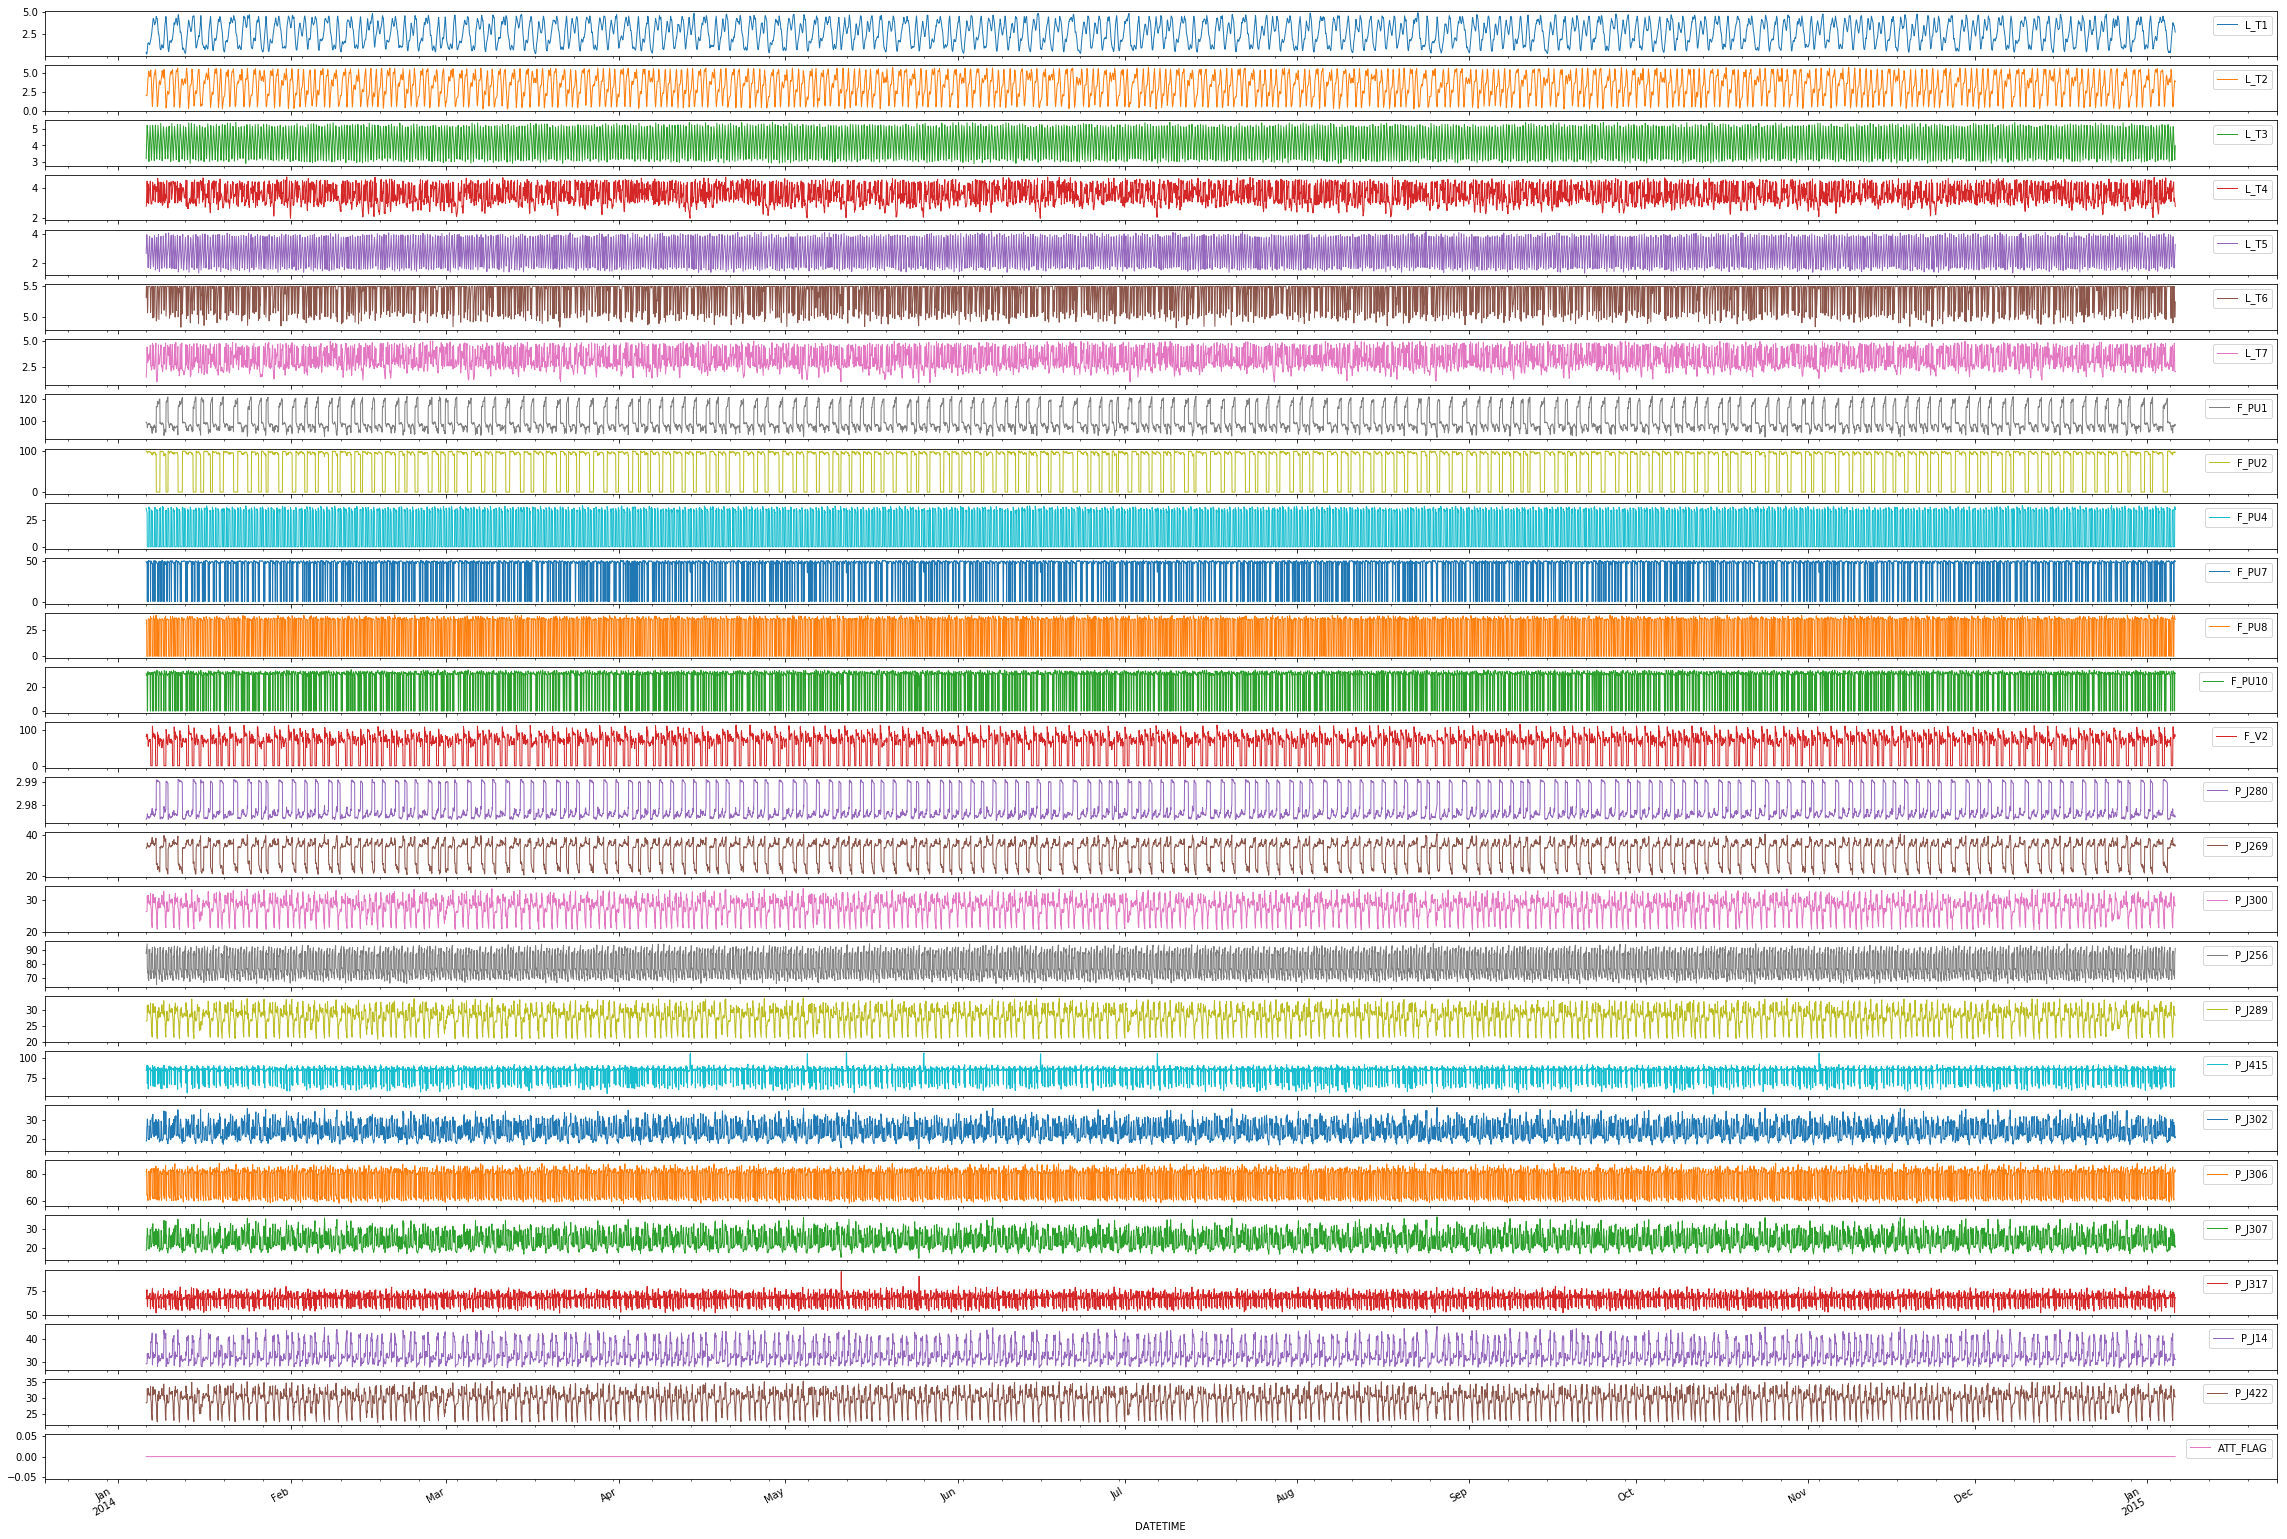

In [229]:
dataToPlot.plot(subplots=True,linewidth=1,kind='line',figsize=(40,30),sharex=True,sharey=False)

### Correlations between time series

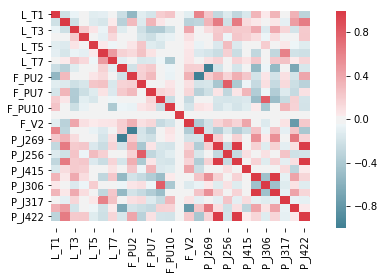

In [13]:
sns.heatmap(dataToPlot.corr(method='spearman'), mask=np.zeros_like(dataToPlot.corr(), dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True))

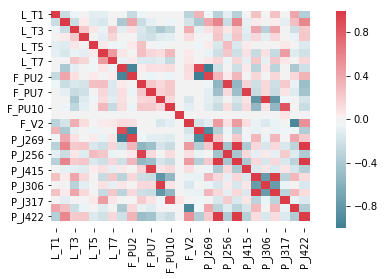

In [14]:
sns.heatmap(dataToPlot.corr(method='pearson'), mask=np.zeros_like(dataToPlot.corr(), dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True))

In [15]:
trainingTable1['P_J422']

DATETIME
2014-01-06 00:00:00    28.487471
2014-01-06 01:00:00    28.454256
2014-01-06 02:00:00    28.454538
2014-01-06 03:00:00    28.549952
2014-01-06 04:00:00    28.674263
2014-01-06 05:00:00    32.849392
2014-01-06 06:00:00    30.908869
2014-01-06 07:00:00    30.800341
2014-01-06 08:00:00    31.039440
2014-01-06 09:00:00    32.882660
2014-01-06 10:00:00    31.481596
2014-01-06 11:00:00    31.658922
2014-01-06 12:00:00    31.321112
2014-01-06 13:00:00    31.074152
2014-01-06 14:00:00    30.927252
2014-01-06 15:00:00    30.892244
2014-01-06 16:00:00    30.770679
2014-01-06 17:00:00    31.247364
2014-01-06 18:00:00    31.522209
2014-01-06 19:00:00    33.494816
2014-01-06 20:00:00    29.684786
2014-01-06 21:00:00    29.166368
2014-01-06 22:00:00    28.662035
2014-01-06 23:00:00    25.280834
2014-01-07 00:00:00    24.465290
2014-01-07 01:00:00    23.752186
2014-01-07 02:00:00    23.102018
2014-01-07 03:00:00    27.970068
2014-01-07 04:00:00    29.829569
2014-01-07 05:00:00    33.322083
 

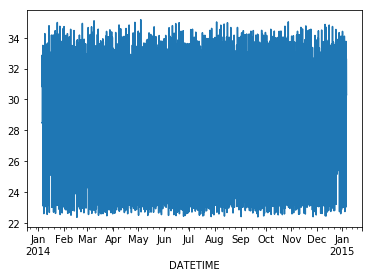

In [16]:
trainingTable1['P_J422'].plot()

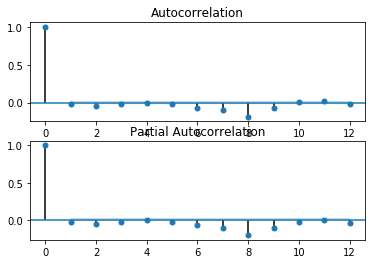

In [17]:
chg_temp = trainingTable1['F_V2'].diff()
chg_temp = chg_temp.dropna()

# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF 
plot_acf(chg_temp, lags=12, ax=axes[0])

# Plot the PACF
plot_pacf(chg_temp, lags=12, ax=axes[1])
plt.show()

In [18]:
# test if sensors are random walk 

columnsSize = dataToPlot.columns.size - 1
columns = list(range(columnsSize))
print(columns)
results = [adfuller(dataToPlot.iloc[:,column]) for column in columns]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


In [19]:
count = 0 
colNames = trainingTable1.columns.values.tolist()
for result in results:
    print('==================================')
    print('Column %s' %colNames[count])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    count = count + 1

Column L_T1
ADF Statistic: -20.615633
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column L_T2
ADF Statistic: -18.612726
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column L_T3
ADF Statistic: -14.375782
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column L_T4
ADF Statistic: -16.582866
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column L_T5
ADF Statistic: -18.509403
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column L_T6
ADF Statistic: -18.364822
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column L_T7
ADF Statistic: -17.489711
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column F_PU1
ADF Statistic: -27.596471
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column S_PU1
ADF Statistic: -27.586431
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column F

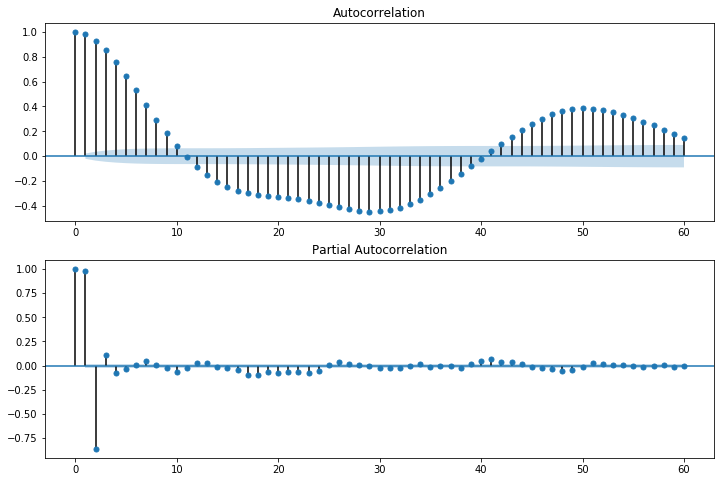

In [20]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(trainingTable1['L_T1'], lags=60, ax=ax1,alpha=0.05)
ax2 = fig.add_subplot(212)
fig = plot_pacf(trainingTable1['L_T1'], lags=60, ax=ax2,alpha=0.05)
plt.show()

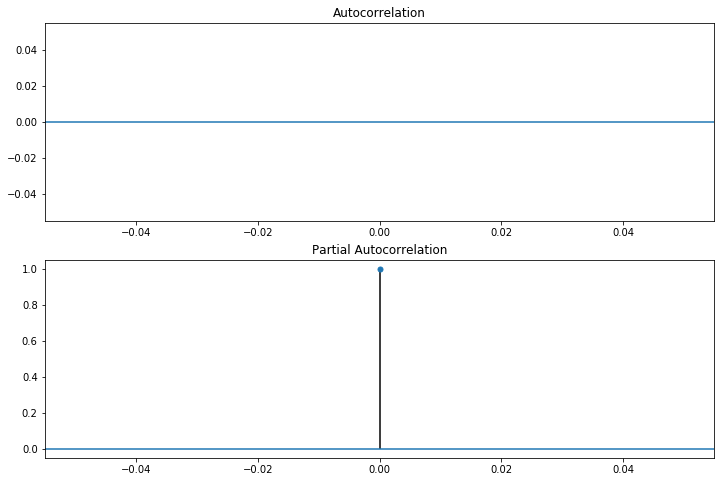

In [29]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(trainingTable1['L_T1'].diff(), lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(trainingTable1['L_T1'].diff(), lags=30, ax=ax2)
plt.show()

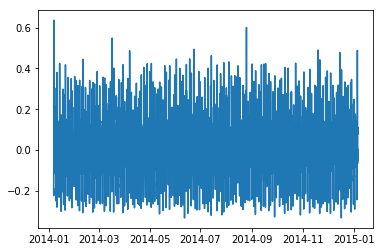

In [22]:
plt.plot(trainingTable1['L_T1'].pct_change())

In [23]:
print(acf(trainingTable1['F_PU1']))

[ 1.          0.88842832  0.7779471   0.67365269  0.5712454   0.46768877
  0.36262662  0.25456042  0.14871147  0.05212462 -0.02901983 -0.10335739
 -0.16900937 -0.22121146 -0.25921387 -0.28397782 -0.29464691 -0.29730426
 -0.29925067 -0.30631712 -0.31379347 -0.32224706 -0.3315234  -0.33890313
 -0.34713295 -0.35686197 -0.3637945  -0.36427606 -0.3605646  -0.3511266
 -0.33958139 -0.32250248 -0.29992968 -0.26948004 -0.23002061 -0.18601731
 -0.14002935 -0.09269629 -0.04445145  0.00326373  0.05444767]


L_T1


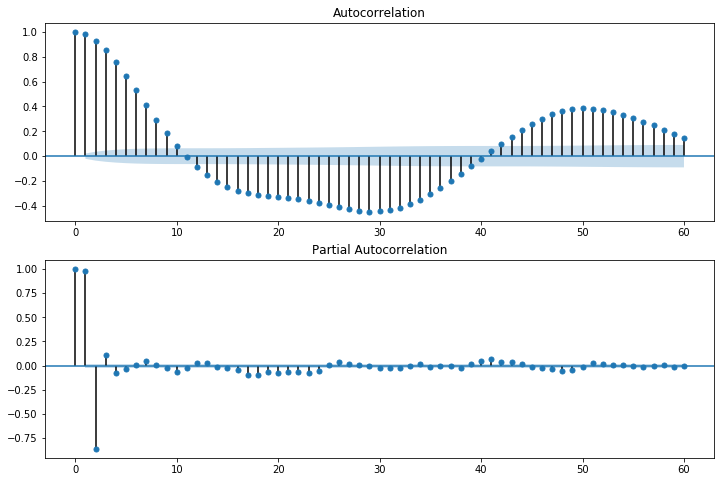

L_T2


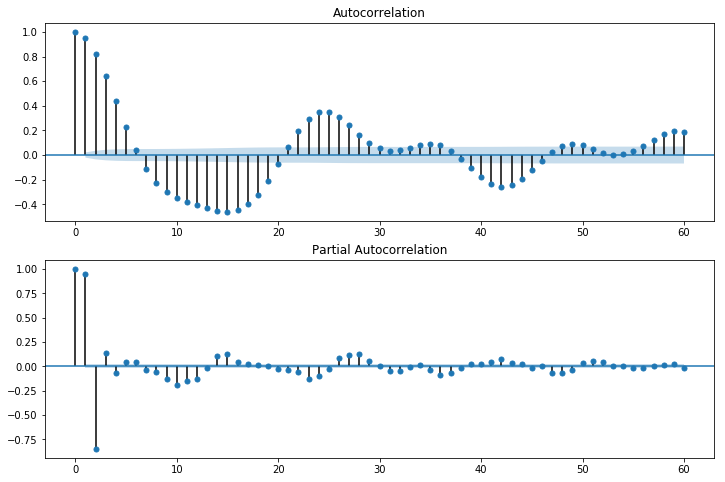

L_T3


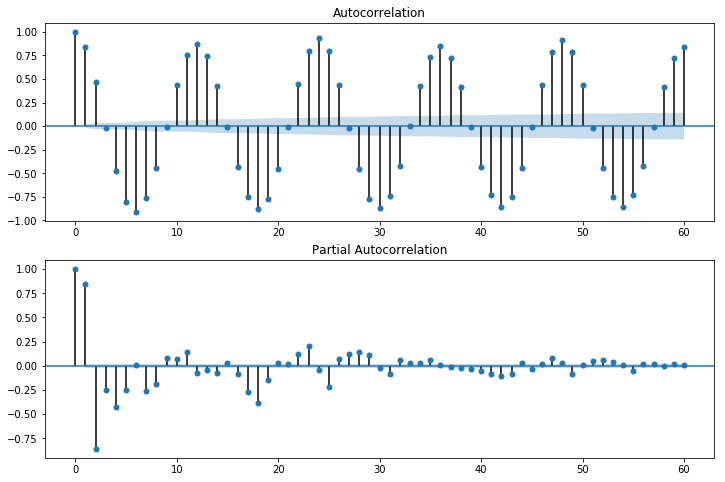

L_T4


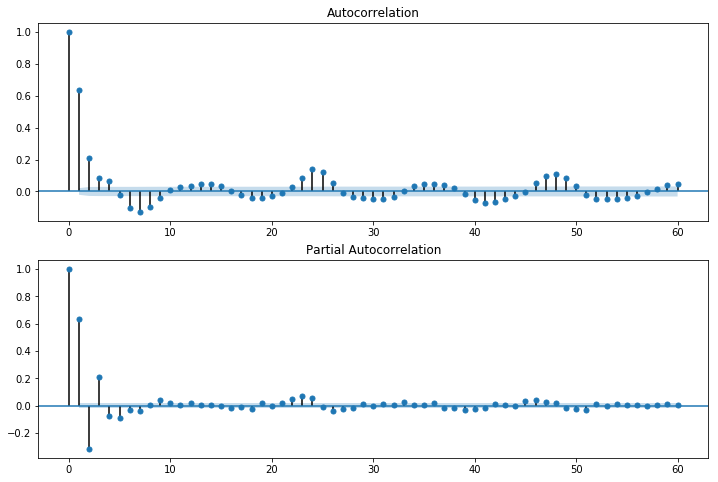

L_T5


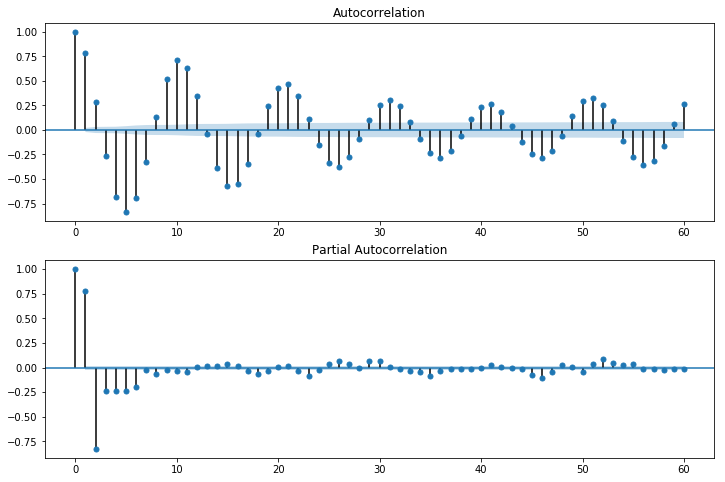

L_T6


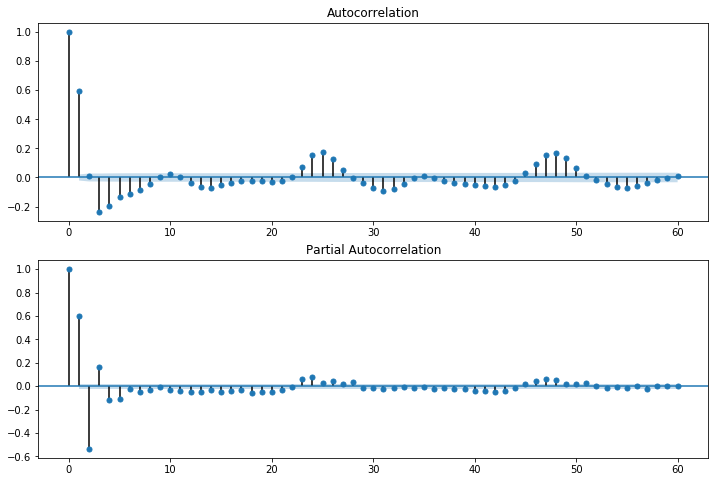

L_T7


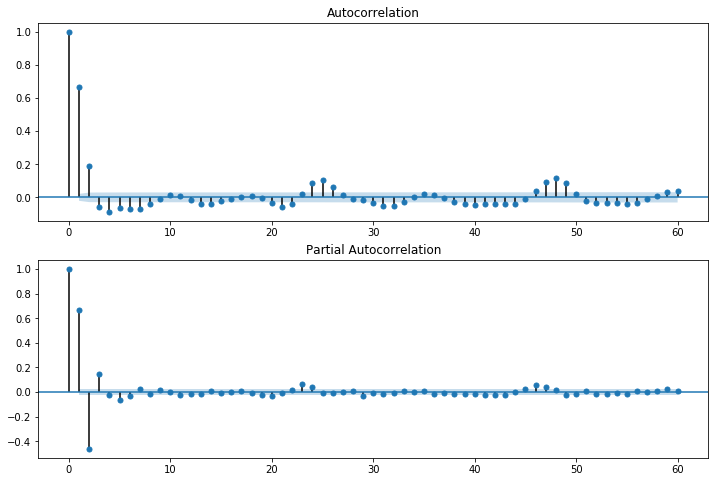

F_PU1


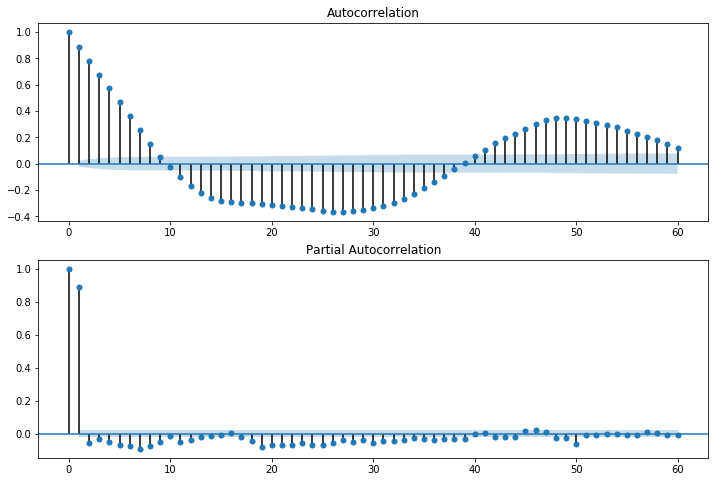

F_PU2


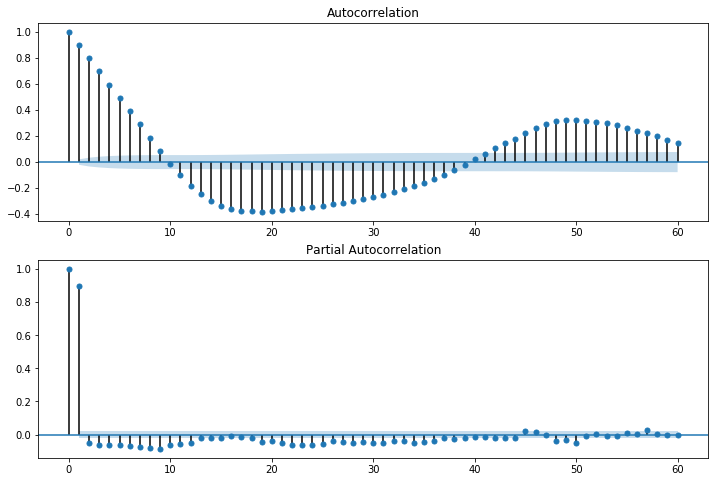

F_PU4


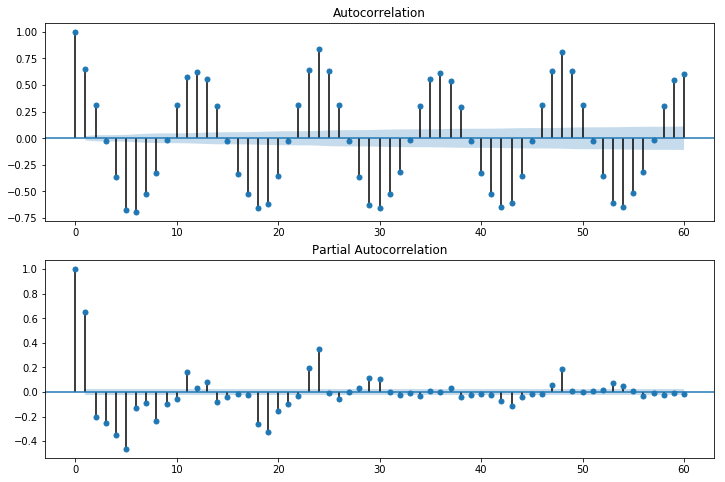

F_PU7


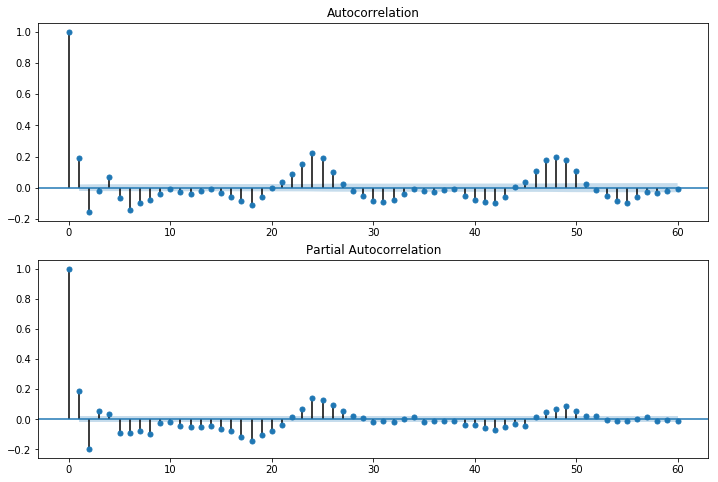

F_PU8


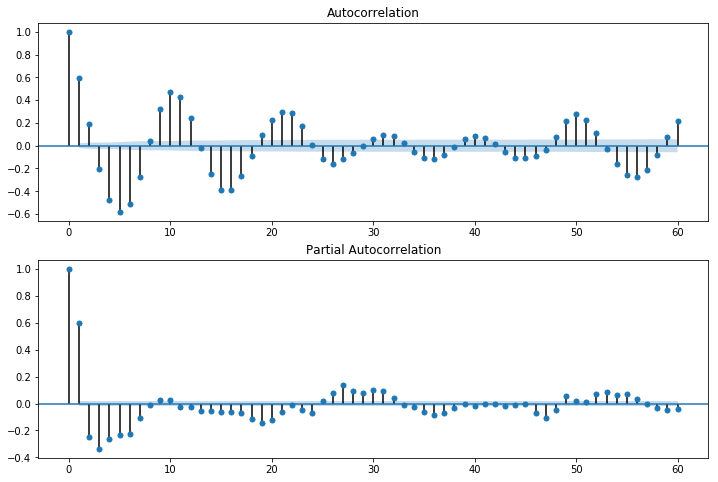

F_PU10


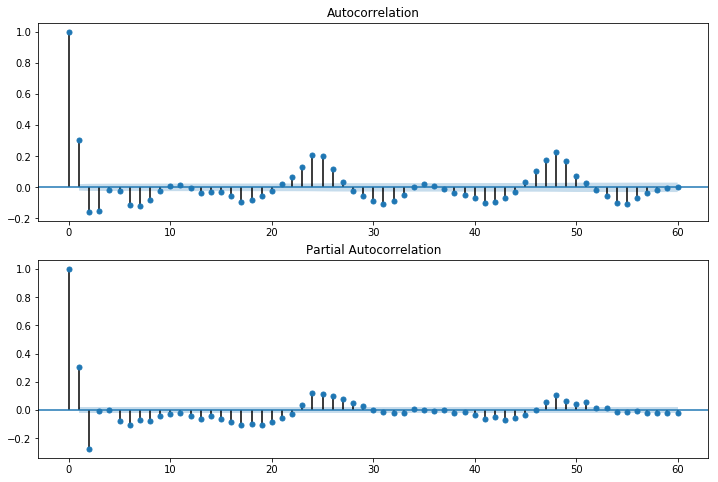

F_PU11


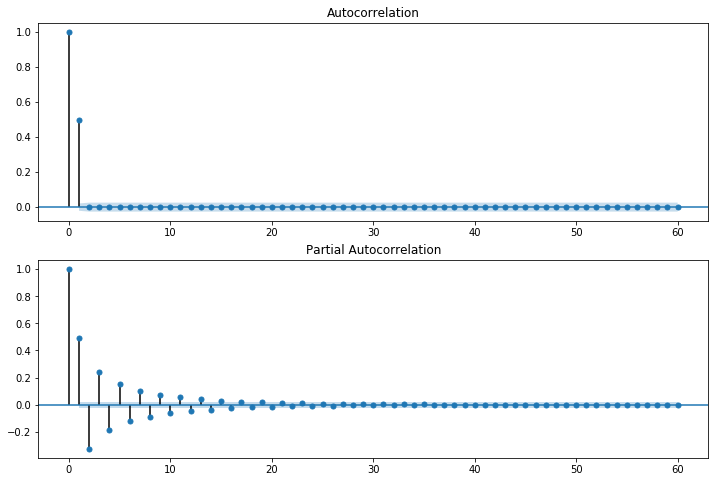

F_V2


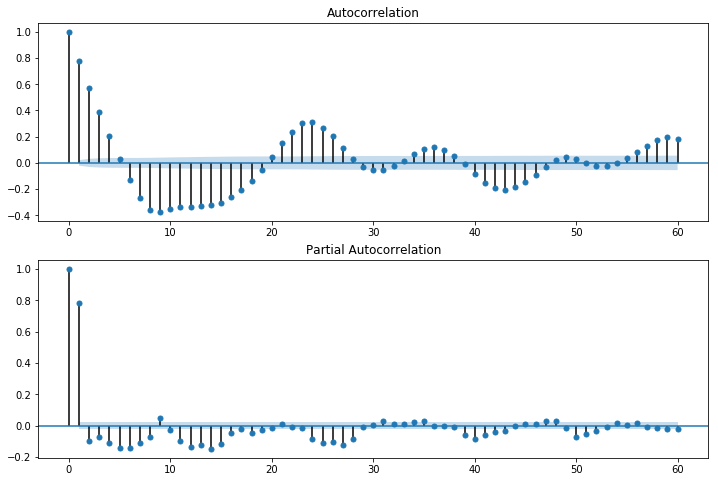

P_J280


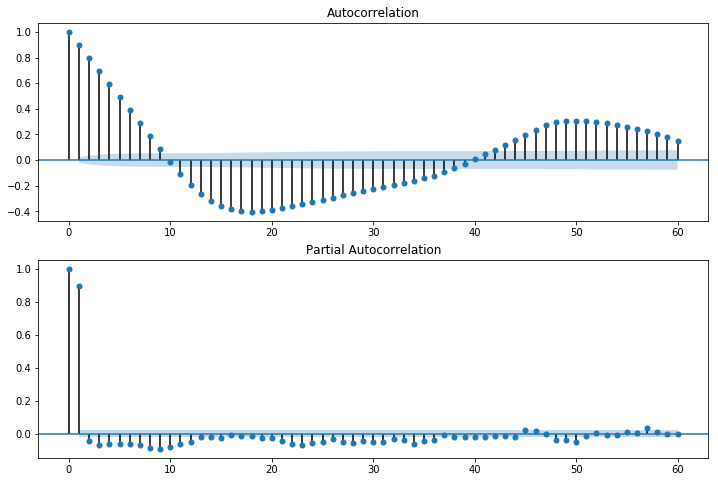

P_J269


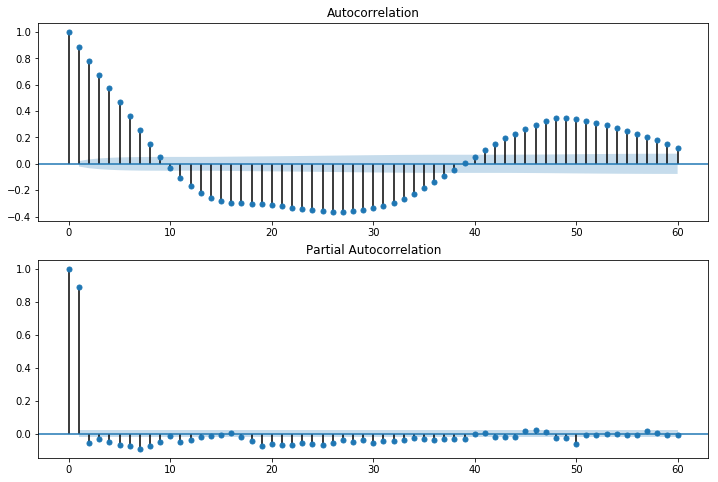

P_J300


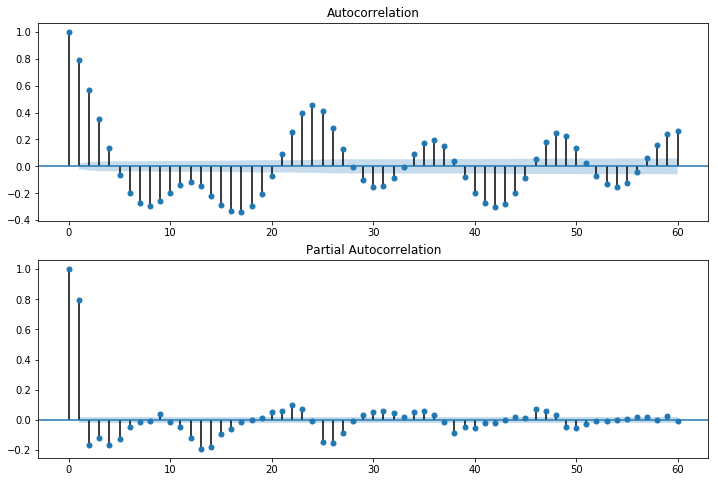

P_J256


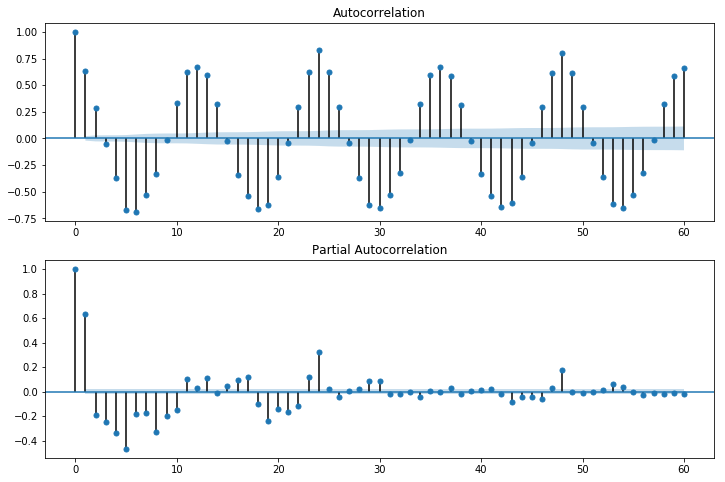

P_J289


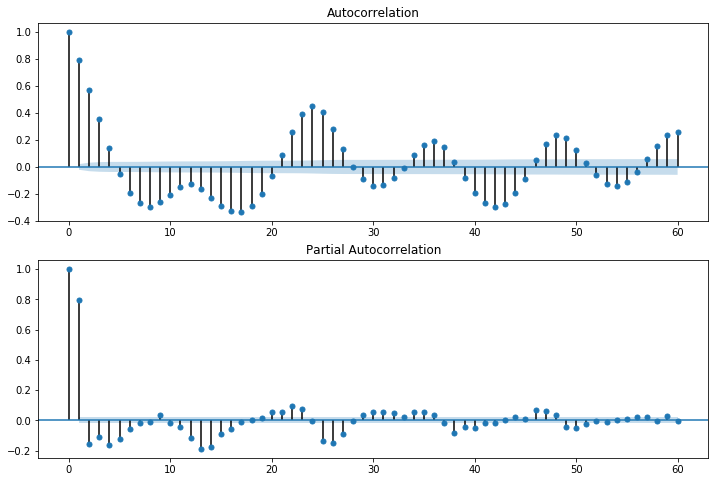

P_J415


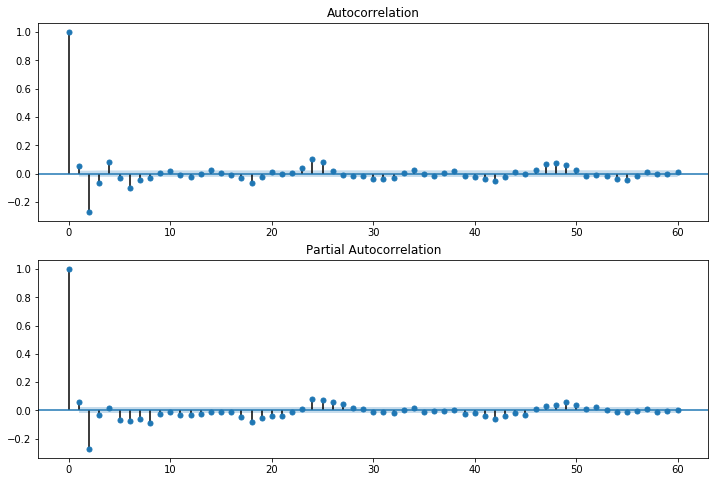

P_J302


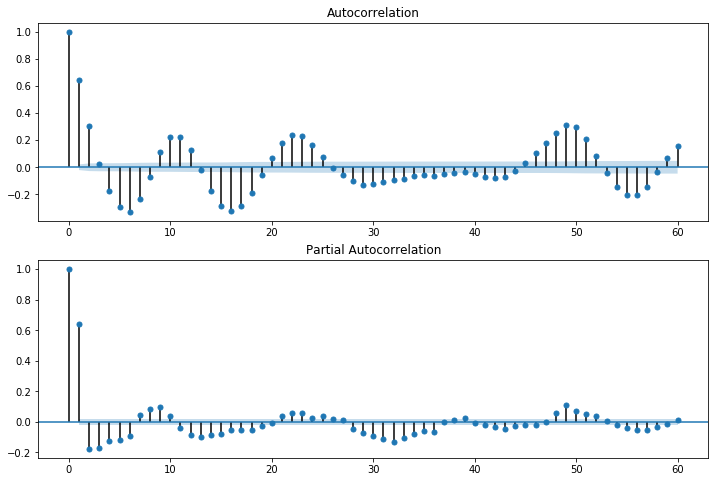

P_J306


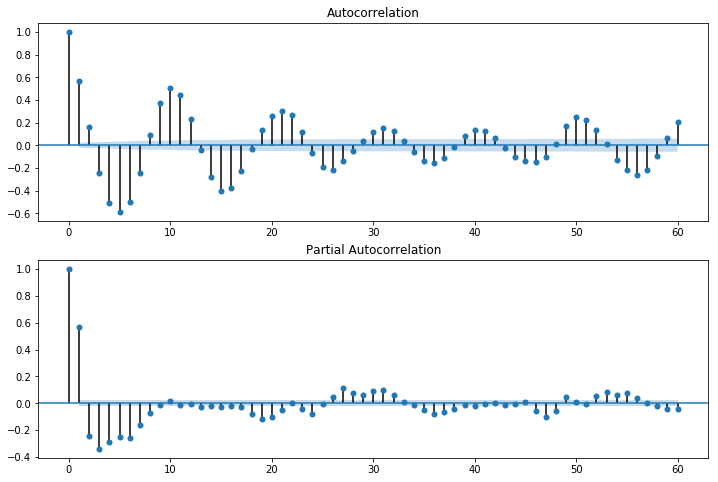

P_J307


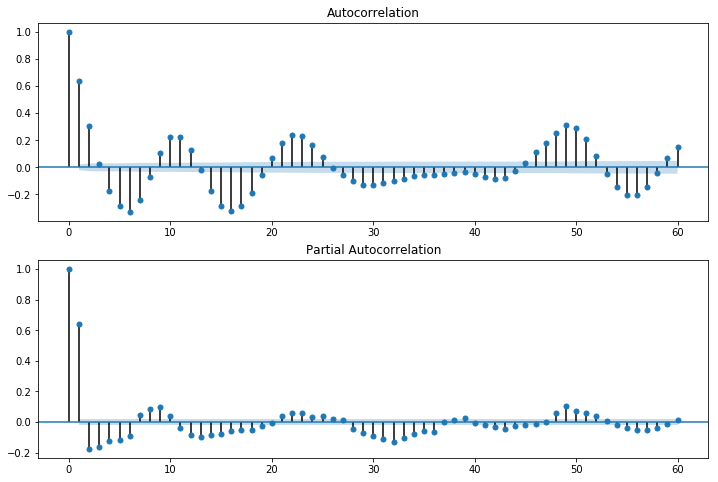

P_J317


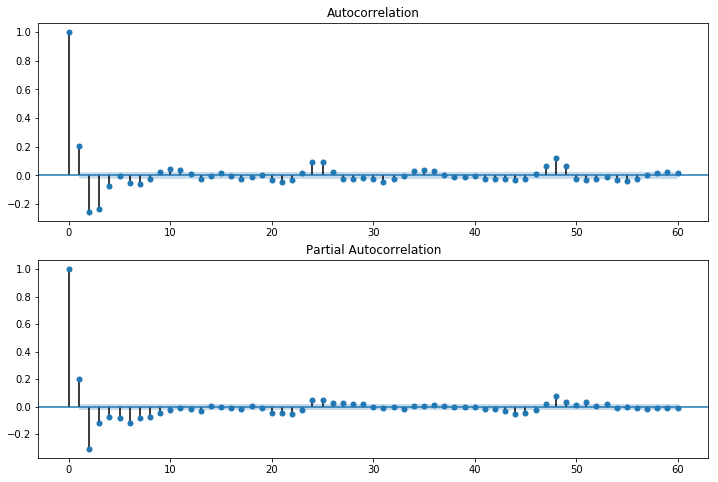

P_J14


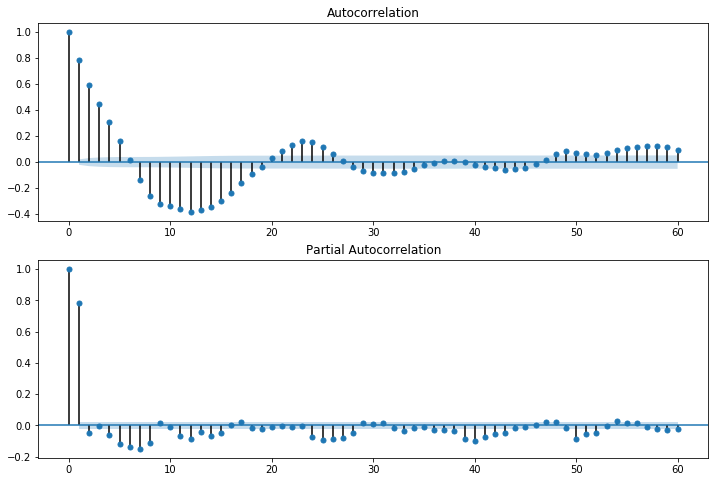

P_J422


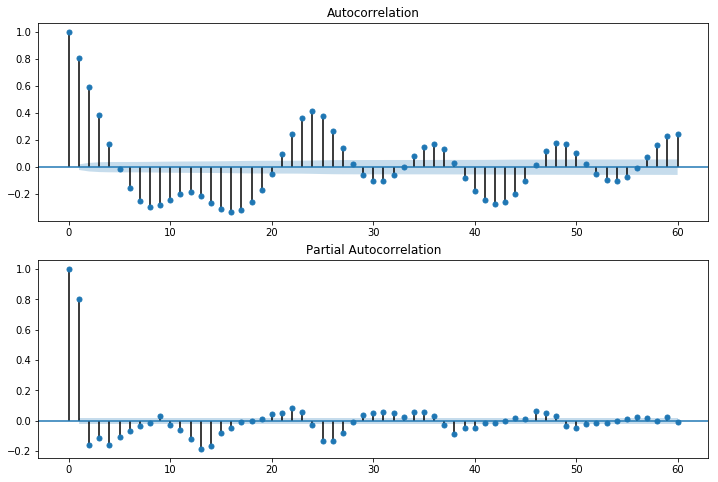

In [24]:
for column in columns:
    print(dataToPlot.iloc[:,column].name)
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(dataToPlot.iloc[:,column], lags=60, ax=ax1,alpha=0.05)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(dataToPlot.iloc[:,column], lags=60, ax=ax2,alpha=0.05)
    plt.show()

series = dataToPlot.iloc[:,1]
one_year = series['14']
groups = one_year.groupby(TimeGrouper('D'))
months = concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(1,31)
months.boxplot()
plt.show()

series = dataToPlot.iloc[:,1]
one_year = series['2014']
groups = one_year.groupby(TimeGrouper('M'))
months = concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(1,13)
months.boxplot()
plt.show()

# parameters are determined based o training data

In [292]:
columnsSize = dataToPlot.columns.size
columns = list(range(columnsSize-1))
#columns = list(range(4))
for column in columns:
    bestAIC = 9999999
    bestAR = -1
    bestMA=-1
    for p in list(range(5)):
        for q in list(range(2)):
            model = ARMA(dataToPlot.iloc[:,column],order=(p,q)).fit(transparams=True)
            if model.aic < bestAIC:
                bestAIC = model.aic
                bestAR = p
                bestMA = q
    print('-------------------')
    print(dataToPlot.iloc[:,column].name)
    print('AIC: {:.2f}'.format(bestAIC))
    print('AR parameter {}'.format(bestAR))
    print('MA parameter {}'.format(bestMA))

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


-------------------
L_T1
AIC: -13386.81
AR parameter 4
MA parameter 1
-------------------
L_T2
AIC: -306.65
AR parameter 4
MA parameter 1
-------------------
L_T3
AIC: -7590.83
AR parameter 4
MA parameter 1


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


-------------------
L_T4
AIC: 8126.12
AR parameter 4
MA parameter 1
-------------------
L_T5
AIC: -588.62
AR parameter 4
MA parameter 1
-------------------
L_T6
AIC: -12762.37
AR parameter 4
MA parameter 1
-------------------
L_T7
AIC: 14061.35
AR parameter 4
MA parameter 1
-------------------
F_PU1
AIC: 50973.83
AR parameter 4
MA parameter 1


ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

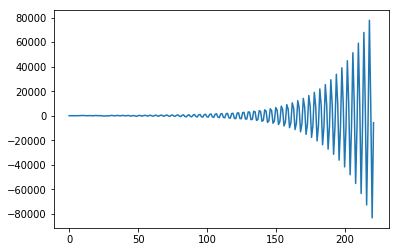

In [294]:
plt.plot(yhat)

# Residuals

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:                   L_T2   No. Observations:                 8761
Model:                     ARMA(5, 1)   Log Likelihood                 161.819
Method:                       css-mle   S.D. of innovations              0.237
Date:                Sat, 02 Jun 2018   AIC                           -307.639
Time:                        22:53:52   BIC                           -251.014
Sample:                    01-06-2014   HQIC                          -288.345
                         - 01-06-2015                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2856      0.018    179.998      0.000       3.250       3.321
ar.L1.L_T2     2.7921      0.015    182.077      0.000       2.762       2.822
ar.L2.L_T2    -2.8680      0.038    -75.488      0.0

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                 0
count  8761.000000
mean     -0.000085
std       0.237848
min      -1.236621
25%      -0.155128
50%      -0.008780
75%       0.131766
max       1.109981


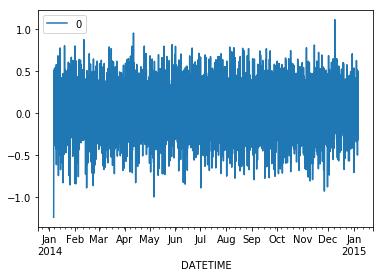

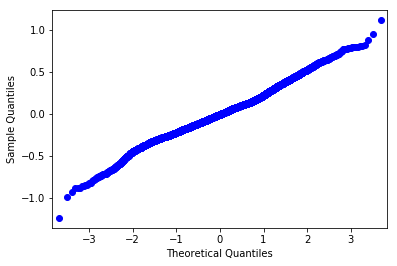

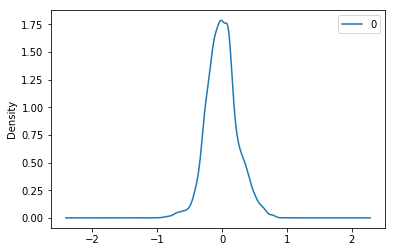

In [293]:
# fit model
model = ARMA(dataToPlot.iloc[:,1], order=(5,1))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

residuals2 = np.array(model_fit.resid)
sm.qqplot(residuals2)

residuals.plot(kind='kde')
print(residuals.describe())

In [40]:
## TODO Report
#In this case : 
##The results show that indeed there is no bias in the prediction (an approximately zero mean in the residuals).



In [41]:
y_train = dataToPlot.iloc[:,-1]
x_train = dataToPlot.iloc[:,:-1]
x_test = dataToPlot2.iloc[:,:-1]
y_test =  dataToPlot2.iloc[:,-1]

In [257]:
dataToPlot.describe()

L_T1         L_T2         L_T3         L_T4         L_T5  \
count  8761.000000  8761.000000  8761.000000  8761.000000  8761.000000   
mean      2.676905     3.285748     4.201820     3.568129     2.748205   
std       1.202940     1.468621     0.678465     0.539656     0.735162   
min       0.320112     0.293876     2.882847     2.002133     1.293241   
25%       1.650647     2.131776     3.623394     3.139640     2.123508   
50%       2.798855     3.498371     4.240439     3.574840     2.758198   
75%       3.754744     4.570782     4.793697     4.009889     3.372392   
max       4.871329     5.663802     5.433022     4.690665     4.162726   

              L_T6         L_T7        F_PU1        F_PU2        F_PU4  \
count  8761.000000  8761.000000  8761.000000  8761.000000  8761.000000   
mean      5.370437     3.302672   100.926032    69.464357    14.555019   
std       0.177459     0.828849    10.048618    42.239742    17.042785   
min       4.824605     1.054194    85.495201     0.000000     0.000000   
25%       5.248147     2.631062    94.342598     0.000000     0.000000   
50%       5.500000     3.252838    96.729073    94.075195     0.000000   
75%       5.500000     3.986883   112.294952    96.614708    34.030491   
max       5.500000     4.999618   122.705627   100.140671    38.296165   

         ...          P_J256       P_J289       P_J415       P_J302  \
count    ...     8761.000000  8761.000000  8761.000000  8761.000000   
mean     ...       79.411082    27.776600    82.737615    24.453808   
std      ...        8.461924     2.720291     7.502937     4.416089   
min      ...       65.059624    20.690191    54.757198    14.797167   
25%      ...       71.978676    26.674088    83.912292    20.516289   
50%      ...       75.879807    28.110842    85.219460    22.969397   
75%      ...       88.221329    29.553995    86.416519    28.457081   
max      ...       94.961258    33.763836   105.951820    36.325947   

            P_J306       P_J307       P_J317        P_J14       P_J422  \
count  8761.000000  8761.000000  8761.000000  8761.000000  8761.000000   
mean     74.459039    24.362250    67.921632    33.755911    29.453266   
std       9.974357     4.438203     5.321227     4.232716     2.658146   
min      58.325397    14.541955    51.697071    27.649677    22.370066   
25%      62.949253    20.409576    66.718307    30.668709    28.432796   
50%      81.176102    22.856150    68.807007    32.222023    29.834288   
75%      82.673698    28.382421    71.218712    38.134647    31.275637   
max      89.053986    36.325947    96.180450    45.388145    35.161724   

       ATT_FLAG  
count    8761.0  
mean        0.0  
std         0.0  
min         0.0  
25%         0.0  
50%         0.0  
75%         0.0  
max         0.0  

[8 rows x 27 columns]

# Performance

In [303]:
## TODO : for all columns , only need to substitute 1 for column
## TODO : put threshold aligned with columns (i=1 would be the threshold for the first column)
thrs = list(range(columnsSize))
for column in columns:
    thrs[column]=0
    sumThrs = 0
    history = [x for x in x_train.iloc[:,column]]#x_train]
    predictions = list()
    errors=  list()
    residuals = []
    thrs=(x_train.iloc[:,column].max() - x_train.iloc[:,column].min())/10
    #yhat = model.predict(x_test.iloc[:,column])
    #predictions=yhat
    TP=0
    FP=0
    for i in range(len(x_test.iloc[:,column])):
        model = ARMA(history,order=(4,1))
        model_fit= model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        obs = x_test.iloc[:,column][i]
        history.append(obs)
        print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
        diff = abs(yhat - obs)
        predictions.append(yhat)
       # errors.append(obs)
    #residuals.append(diff)
        if diff>=thrs:
            print("ANOMALY")
            if y_test[i]==1:
                TP+=1
            else:
                FP+=1
            sumThrs = sumThrs + diff
            #if diff > thrs[column]:
            #    thrs[column] = diff  
    meanThrs = sumThrs / i
    thrs[column]=meanThrs
    print('THRESHOLD FOR COLUMN')
    print(column)
    print(thrs)
    # report performance
    #mse = mean_squared_error(testTable.iloc[:,1], predictions)
    #rmse = sqrt(mse)
    #print('RMSE: %.3f' % rmse)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


>Predicted=2.606, Expected=2.440
>Predicted=2.187, Expected=2.660
ANOMALY
>Predicted=2.939, Expected=3.110
>Predicted=3.505, Expected=3.620


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=4.017, Expected=4.080


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=4.404, Expected=4.530


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=4.840, Expected=4.840


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=5.004, Expected=5.190


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=5.407, Expected=5.220


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=5.111, Expected=5.110
>Predicted=4.922, Expected=4.730
>Predicted=4.309, Expected=4.240
>Predicted=3.770, Expected=3.740
>Predicted=3.291, Expected=3.250


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=2.823, Expected=2.700
>Predicted=2.225, Expected=2.250


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.896, Expected=1.930


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.694, Expected=1.650
>Predicted=1.438, Expected=1.430
>Predicted=1.277, Expected=1.150


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=0.937, Expected=0.930
>Predicted=0.796, Expected=0.840
>Predicted=0.828, Expected=0.700


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=0.622, Expected=0.590
>Predicted=0.558, Expected=0.490
>Predicted=0.468, Expected=0.350


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=0.295, Expected=0.320


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=0.385, Expected=0.440


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=0.632, Expected=0.700


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=0.999, Expected=0.930
>Predicted=1.171, Expected=1.280


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.638, Expected=1.570


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.842, Expected=1.610


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.649, Expected=1.610


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.658, Expected=1.550
>Predicted=1.549, Expected=1.470


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.464, Expected=1.450


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.508, Expected=1.350
>Predicted=1.322, Expected=1.450
>Predicted=1.632, Expected=1.590


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.771, Expected=1.790


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=2.019, Expected=1.930
>Predicted=2.086, Expected=1.910
>Predicted=1.921, Expected=1.870


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.893, Expected=2.030
>Predicted=2.248, Expected=2.180


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=2.348, Expected=2.320
>Predicted=2.476, Expected=2.450
>Predicted=2.594, Expected=2.640
>Predicted=2.839, Expected=2.910
>Predicted=3.169, Expected=3.350


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=3.748, Expected=3.400


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=3.381, Expected=3.590


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=3.773, Expected=3.820


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=4.008, Expected=3.940
>Predicted=4.007, Expected=3.900
>Predicted=3.829, Expected=3.810
>Predicted=3.719, Expected=3.660
>Predicted=3.521, Expected=3.550
>Predicted=3.461, Expected=3.420
>Predicted=3.305, Expected=3.380
>Predicted=3.356, Expected=3.560


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=3.728, Expected=3.720


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=3.822, Expected=3.720


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=3.667, Expected=3.590
>Predicted=3.441, Expected=3.480


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=3.376, Expected=3.380
>Predicted=3.282, Expected=3.700
>Predicted=4.002, Expected=3.990
>Predicted=4.176, Expected=4.140
>Predicted=4.189, Expected=4.330


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=4.437, Expected=4.480
>Predicted=4.534, Expected=4.460
>Predicted=4.353, Expected=4.540
>Predicted=4.557, Expected=4.370


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=4.126, Expected=3.920


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=3.457, Expected=3.630


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=3.380, Expected=3.460
>Predicted=3.301, Expected=3.340
>Predicted=3.210, Expected=3.160
>Predicted=2.966, Expected=2.950
>Predicted=2.743, Expected=2.820
>Predicted=2.700, Expected=2.500


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=2.188, Expected=2.110
>Predicted=1.776, Expected=1.730


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.430, Expected=1.340


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.040, Expected=0.990


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=0.743, Expected=1.040


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.179, Expected=1.080
>Predicted=1.137, Expected=1.130


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.201, Expected=1.230


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.349, Expected=1.290


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.362, Expected=1.240
>Predicted=1.216, Expected=1.190
>Predicted=1.191, Expected=1.100
>Predicted=1.067, Expected=1.000


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=0.969, Expected=0.900
>Predicted=0.877, Expected=0.860


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=0.899, Expected=0.870
>Predicted=0.950, Expected=1.050
>Predicted=1.285, Expected=1.400
>Predicted=1.763, Expected=1.720
>Predicted=2.017, Expected=2.030
>Predicted=2.316, Expected=2.500
>Predicted=2.933, Expected=2.890
>Predicted=3.205, Expected=3.190


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=3.424, Expected=3.410
>Predicted=3.575, Expected=3.670


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=3.881, Expected=3.870
>Predicted=4.007, Expected=4.050
>Predicted=4.171, Expected=4.240
>Predicted=4.367, Expected=4.130
>Predicted=3.962, Expected=4.100
>Predicted=4.063, Expected=4.200


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=4.269, Expected=4.070
>Predicted=3.891, Expected=3.930
>Predicted=3.784, Expected=3.770
>Predicted=3.608, Expected=3.580


KeyboardInterrupt: 

In [ ]:
## TODO : for all columns , only need to substitute 1 for column
## TODO : put threshold aligned with columns (i=1 would be the threshold for the first column)
thrs = list(range(columnsSize))
for column in columns:
    thrs[column]=0
    sumThrs = 0
    history = [x for x in dataToPlot.iloc[:,column]]#x_train]
    predictions = list()
    errors=  list()
    residuals = []
    thrs=(dataToPlot.iloc[:,column].max() - dataToPlot.iloc[:,column].min())/10
    #yhat = model.predict(x_test.iloc[:,column])
    #predictions=yhat
    TP=0
    FP=0
    for i in range(len(testToPlot.iloc[:,column])):
        model = ARMA(history,order=(4,1))
        model_fit= model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        obs = x_test.iloc[:,column][i]
        history.append(obs)
        print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
        diff = abs(yhat - obs)
        predictions.append(yhat)
       # errors.append(obs)
    #residuals.append(diff)
        if diff>=thrs:
            print("ANOMALY")
            if y_test[i]==1:
                TP+=1
            else:
                FP+=1
            sumThrs = sumThrs + diff
            #if diff > thrs[column]:
            #    thrs[column] = diff  
    meanThrs = sumThrs / i
    thrs[column]=meanThrs
    print('THRESHOLD FOR COLUMN')
    print(column)
    print(thrs)
    # report performance
    #mse = mean_squared_error(testTable.iloc[:,1], predictions)
    #rmse = sqrt(mse)
    #print('RMSE: %.3f' % rmse)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


>Predicted=2.606, Expected=2.440
>Predicted=2.187, Expected=2.660
ANOMALY
>Predicted=2.939, Expected=3.110
>Predicted=3.505, Expected=3.620


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=4.017, Expected=4.080


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=4.404, Expected=4.530


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=4.840, Expected=4.840


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=5.004, Expected=5.190


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=5.407, Expected=5.220


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=5.111, Expected=5.110


In [302]:
x_train.iloc[:,column].max()

4.871329308

In [ ]:
print(TP)
print(FP)
#dataToPlot2[dataToPlot2['ATT_FLAG']==1].count()

In [ ]:
yhat = pd.DataFrame(yhat)
yhat

In [270]:
model = ARMA(x_train.iloc[:,column],order=(1,0))
model_fit= model.fit()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [265]:
yhat

array([29.64      , -0.49864303, -1.36720403, ..., 63.55645743,
       49.02085441, 47.18113523])

In [288]:
testToPlot.describe()

L_T1         L_T2         L_T3         L_T4         L_T5  \
count  2089.000000  2089.000000  2089.000000  2089.000000  2089.000000   
mean      2.779449     3.353676     4.198928     3.570369     2.753021   
std       1.211617     1.441290     0.677163     0.543436     0.736856   
min       0.520000     0.310000     2.880000     2.020000     1.330000   
25%       1.770000     2.250000     3.610000     3.140000     2.130000   
50%       2.940000     3.590000     4.230000     3.580000     2.760000   
75%       3.830000     4.570000     4.800000     4.010000     3.390000   
max       6.340000     5.710000     5.430000     4.660000     4.150000   

              L_T6         L_T7        F_PU1        F_PU2        F_PU4  \
count  2089.000000  2089.000000  2089.000000  2089.000000  2089.000000   
mean      5.374840     3.294955   100.263605    67.099746    14.574174   
std       0.172273     0.818310    12.207435    43.313361    17.110415   
min       4.820000     1.240000     0.000000     0.000000     0.000000   
25%       5.260000     2.610000    94.090000     0.000000     0.000000   
50%       5.500000     3.200000    96.520000    93.720000     0.000000   
75%       5.500000     3.990000   111.990000    96.370000    34.120000   
max       5.500000     4.980000   122.440000    99.970000    38.020000   

          ...            P_J300       P_J256       P_J289       P_J415  \
count     ...       2089.000000  2089.000000  2089.000000  2089.000000   
mean      ...         27.982824    79.414744    27.993375    82.866194   
std       ...          2.898099     8.685565     2.878047     7.679057   
min       ...         19.020000    65.350000    19.040000    56.200000   
25%       ...         26.830000    71.870000    26.850000    84.020000   
50%       ...         28.270000    75.790000    28.270000    85.220000   
75%       ...         29.710000    88.310000    29.720000    86.480000   
max       ...         43.130000   106.220000    43.130000   122.930000   

            P_J302       P_J306       P_J307       P_J317        P_J14  \
count  2089.000000  2089.000000  2089.000000  2089.000000  2089.000000   
mean     24.545041    74.377578    24.465232    67.866089    33.712207   
std       4.477267     9.993108     4.464687     5.342564     4.126415   
min      13.380000    58.700000    16.770000    50.970000    27.840000   
25%      20.720000    62.940000    20.630000    66.630000    30.790000   
50%      23.110000    81.140000    22.910000    68.780000    32.210000   
75%      28.470000    82.650000    28.380000    71.290000    37.610000   
max      37.030000    88.270000    37.030000    81.370000    46.320000   

            P_J422  
count  2089.000000  
mean     29.640838  
std       2.685110  
min      20.900000  
25%      28.630000  
50%      30.010000  
75%      31.360000  
max      41.420000  

[8 rows x 26 columns]

In [230]:
## TODO : for all columns , only need to substitute 1 for column
#columnsT = columns[:,-1]
columnsTSize = testToPlot.columns.size
columnsT = range(columnsTSize)
for column in columnsT:
    history = [x for x in dataToPlot.iloc[:,column]]
    predictions = list()
    errors=  list()
    residuals = []
    model = ARMA(dataToPlot.iloc[:,column],order=(4,1))
    model_fit= model.fit()
    yhat = model.predict(testToPlot.iloc[:,column])
    for i in range(len(testToPlot.iloc[:,column])):
        #predict
        predictions.append(yhat[i])
        # observation
        obs = dataToPlot.iloc[:,column][i]
        history.append(obs)
        print('>Predicted=%.3f, Expected=%.3f' % (yhat[i], obs))
        diff = abs(obs - yhat[i])
        errors.append(obs)
        residuals.append(diff)
        if diff > thrs[column]:
            print('ALERT ANOMALY ?')
    # report performance
    mse = mean_squared_error(testToPlot.iloc[:,column], predictions)
    rmse = sqrt(mse)
    print('RMSE: %.3f' % rmse)


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


>Predicted=0.730, Expected=0.510
>Predicted=0.578, Expected=0.413
>Predicted=0.511, Expected=0.320
>Predicted=0.447, Expected=0.333
>Predicted=0.456, Expected=0.483
>Predicted=0.560, Expected=0.791
>Predicted=0.772, Expected=1.187
>Predicted=1.045, Expected=1.420
>Predicted=1.206, Expected=1.535
>Predicted=1.285, Expected=1.577
>Predicted=1.314, Expected=1.559
>Predicted=1.302, Expected=1.481
>Predicted=1.248, Expected=1.465
>Predicted=1.237, Expected=1.484
>Predicted=1.250, Expected=1.384
>Predicted=1.181, Expected=1.352
>Predicted=1.159, Expected=1.455
>Predicted=1.230, Expected=1.532
>Predicted=1.283, Expected=1.663
>Predicted=1.373, Expected=1.839
>Predicted=1.495, Expected=1.904
>Predicted=1.540, Expected=2.114
>Predicted=1.685, Expected=2.286
>Predicted=1.804, Expected=2.417
>Predicted=1.894, Expected=2.607
>Predicted=2.025, Expected=2.878
>Predicted=2.212, Expected=3.236
>Predicted=2.459, Expected=3.538
>Predicted=2.667, Expected=3.711
>Predicted=2.787, Expected=3.970
>Predicted

>Predicted=3.199, Expected=4.211
>Predicted=3.132, Expected=4.021
>Predicted=3.001, Expected=3.675
>Predicted=2.762, Expected=3.283
>Predicted=2.492, Expected=2.858
>Predicted=2.198, Expected=2.395
>Predicted=1.879, Expected=1.912
>Predicted=1.546, Expected=1.449
>Predicted=1.226, Expected=1.002
>Predicted=0.918, Expected=0.854
>Predicted=0.815, Expected=0.734
>Predicted=0.733, Expected=0.636
>Predicted=0.665, Expected=0.562
>Predicted=0.614, Expected=0.575
>Predicted=0.623, Expected=0.830
>Predicted=0.799, Expected=1.100
>Predicted=0.985, Expected=1.261
>Predicted=1.097, Expected=1.530
>Predicted=1.282, Expected=1.665
>Predicted=1.375, Expected=1.695
>Predicted=1.396, Expected=1.620
>Predicted=1.344, Expected=1.494
>Predicted=1.257, Expected=1.444
>Predicted=1.223, Expected=1.415
>Predicted=1.203, Expected=1.473
>Predicted=1.242, Expected=1.561
>Predicted=1.304, Expected=1.656
>Predicted=1.369, Expected=1.746
>Predicted=1.431, Expected=1.689
>Predicted=1.391, Expected=1.649
>Predicted

>Predicted=2.205, Expected=2.381
>Predicted=1.869, Expected=1.952
>Predicted=1.573, Expected=1.718
>Predicted=1.412, Expected=1.629
>Predicted=1.350, Expected=1.475
>Predicted=1.244, Expected=1.367
>Predicted=1.170, Expected=1.275
>Predicted=1.106, Expected=1.241
>Predicted=1.083, Expected=0.998
>Predicted=0.915, Expected=0.975
>Predicted=0.899, Expected=0.995
>Predicted=0.913, Expected=0.919
>Predicted=0.861, Expected=0.877
>Predicted=0.831, Expected=0.828
>Predicted=0.798, Expected=0.904
>Predicted=0.850, Expected=1.029
>Predicted=0.936, Expected=1.164
>Predicted=1.029, Expected=1.420
>Predicted=1.206, Expected=1.412
>Predicted=1.201, Expected=1.430
>Predicted=1.213, Expected=1.354
>Predicted=1.160, Expected=1.310
>Predicted=1.130, Expected=1.200
>Predicted=1.055, Expected=1.053
>Predicted=0.953, Expected=0.948
>Predicted=0.881, Expected=0.969
>Predicted=0.895, Expected=1.137
>Predicted=1.011, Expected=1.403
>Predicted=1.194, Expected=1.795
>Predicted=1.465, Expected=2.361
>Predicted

>Predicted=3.030, Expected=4.059
>Predicted=3.027, Expected=4.004
>Predicted=2.989, Expected=4.020
>Predicted=3.000, Expected=4.021
>Predicted=3.001, Expected=3.953
>Predicted=2.954, Expected=3.946
>Predicted=2.949, Expected=3.990
>Predicted=2.979, Expected=3.915
>Predicted=2.927, Expected=3.853
>Predicted=2.885, Expected=3.732
>Predicted=2.801, Expected=3.634
>Predicted=2.734, Expected=3.637
>Predicted=2.736, Expected=3.955
ALERT ANOMALY ?
>Predicted=2.955, Expected=4.304
ALERT ANOMALY ?
>Predicted=3.196, Expected=4.489
ALERT ANOMALY ?
>Predicted=3.324, Expected=4.460
>Predicted=3.304, Expected=4.351
>Predicted=3.228, Expected=4.199
>Predicted=3.124, Expected=4.059
>Predicted=3.027, Expected=3.984
>Predicted=2.975, Expected=3.491
>Predicted=2.635, Expected=3.131
>Predicted=2.387, Expected=3.041
>Predicted=2.325, Expected=2.984
>Predicted=2.286, Expected=2.840
>Predicted=2.186, Expected=2.659
>Predicted=2.061, Expected=2.460
>Predicted=1.924, Expected=2.244
>Predicted=1.775, Expected=1

>Predicted=8.185, Expected=4.511
ALERT ANOMALY ?
>Predicted=7.313, Expected=4.501
ALERT ANOMALY ?
>Predicted=7.290, Expected=3.980
ALERT ANOMALY ?
>Predicted=6.116, Expected=3.448
ALERT ANOMALY ?
>Predicted=4.921, Expected=2.714
ALERT ANOMALY ?
>Predicted=3.270, Expected=1.852
ALERT ANOMALY ?
>Predicted=1.330, Expected=0.991
>Predicted=-0.607, Expected=0.411
>Predicted=-1.913, Expected=0.604
ALERT ANOMALY ?
>Predicted=-1.478, Expected=0.883
ALERT ANOMALY ?
>Predicted=-0.851, Expected=1.267
ALERT ANOMALY ?
>Predicted=0.013, Expected=1.836
ALERT ANOMALY ?
>Predicted=1.293, Expected=2.236
>Predicted=2.193, Expected=2.439
>Predicted=2.649, Expected=2.561
>Predicted=2.925, Expected=2.478
>Predicted=2.738, Expected=2.288
>Predicted=2.311, Expected=2.233
>Predicted=2.187, Expected=2.189
>Predicted=2.088, Expected=2.204
>Predicted=2.122, Expected=2.426
>Predicted=2.621, Expected=3.113
>Predicted=4.166, Expected=3.862
>Predicted=5.853, Expected=4.273
ALERT ANOMALY ?
>Predicted=6.778, Expected=4

ALERT ANOMALY ?
>Predicted=8.574, Expected=5.095
ALERT ANOMALY ?
>Predicted=8.627, Expected=5.120
ALERT ANOMALY ?
>Predicted=8.682, Expected=5.479
ALERT ANOMALY ?
>Predicted=9.490, Expected=5.367
ALERT ANOMALY ?
>Predicted=9.238, Expected=4.840
ALERT ANOMALY ?
>Predicted=8.053, Expected=4.310
ALERT ANOMALY ?
>Predicted=6.860, Expected=3.783
ALERT ANOMALY ?
>Predicted=5.675, Expected=3.256
ALERT ANOMALY ?
>Predicted=4.488, Expected=2.461
ALERT ANOMALY ?
>Predicted=2.701, Expected=1.591
>Predicted=0.743, Expected=0.733
>Predicted=-1.188, Expected=0.584
ALERT ANOMALY ?
>Predicted=-1.523, Expected=0.657
ALERT ANOMALY ?
>Predicted=-1.359, Expected=0.768
ALERT ANOMALY ?
>Predicted=-1.109, Expected=1.285
ALERT ANOMALY ?
>Predicted=0.054, Expected=2.028
ALERT ANOMALY ?
>Predicted=1.726, Expected=2.734
>Predicted=3.313, Expected=3.055
>Predicted=4.037, Expected=3.353
>Predicted=4.706, Expected=3.549
>Predicted=5.147, Expected=3.616
ALERT ANOMALY ?
>Predicted=5.299, Expected=3.598
ALERT ANOMALY 

ALERT ANOMALY ?
>Predicted=7.008, Expected=3.762
ALERT ANOMALY ?
>Predicted=5.627, Expected=2.887
ALERT ANOMALY ?
>Predicted=3.659, Expected=2.016
ALERT ANOMALY ?
>Predicted=1.699, Expected=1.158
>Predicted=-0.232, Expected=0.550
>Predicted=-1.599, Expected=0.764
ALERT ANOMALY ?
>Predicted=-1.118, Expected=1.041
ALERT ANOMALY ?
>Predicted=-0.495, Expected=1.519
ALERT ANOMALY ?
>Predicted=0.581, Expected=1.941
ALERT ANOMALY ?
>Predicted=1.530, Expected=2.320
>Predicted=2.382, Expected=2.695
>Predicted=3.225, Expected=3.008
>Predicted=3.931, Expected=3.038
>Predicted=3.997, Expected=3.086
>Predicted=4.107, Expected=3.156
>Predicted=4.264, Expected=3.257
>Predicted=4.490, Expected=3.818
>Predicted=5.754, Expected=4.605
>Predicted=7.524, Expected=5.115
ALERT ANOMALY ?
>Predicted=8.670, Expected=5.399
ALERT ANOMALY ?
>Predicted=9.309, Expected=5.154
ALERT ANOMALY ?
>Predicted=8.759, Expected=4.626
ALERT ANOMALY ?
>Predicted=7.570, Expected=4.103
ALERT ANOMALY ?
>Predicted=6.394, Expected=3.

>Predicted=1.821, Expected=2.265
>Predicted=2.258, Expected=2.741
>Predicted=3.330, Expected=3.485
>Predicted=5.004, Expected=4.186
>Predicted=6.580, Expected=4.580
ALERT ANOMALY ?
>Predicted=7.467, Expected=4.947
ALERT ANOMALY ?
>Predicted=8.294, Expected=5.261
ALERT ANOMALY ?
>Predicted=9.000, Expected=5.530
ALERT ANOMALY ?
>Predicted=9.605, Expected=5.434
ALERT ANOMALY ?
>Predicted=9.389, Expected=4.552
ALERT ANOMALY ?
>Predicted=7.404, Expected=3.675
ALERT ANOMALY ?
>Predicted=5.432, Expected=2.809
ALERT ANOMALY ?
>Predicted=3.483, Expected=1.957
ALERT ANOMALY ?
>Predicted=1.565, Expected=1.148
>Predicted=-0.254, Expected=0.641
>Predicted=-1.396, Expected=0.831
ALERT ANOMALY ?
>Predicted=-0.968, Expected=1.396
ALERT ANOMALY ?
>Predicted=0.303, Expected=1.974
ALERT ANOMALY ?
>Predicted=1.603, Expected=2.232
>Predicted=2.184, Expected=2.380
>Predicted=2.516, Expected=2.163
>Predicted=2.029, Expected=2.001
>Predicted=1.664, Expected=1.889
>Predicted=1.412, Expected=1.854
>Predicted=1.

ALERT ANOMALY ?
>Predicted=3.365, Expected=1.888
ALERT ANOMALY ?
>Predicted=1.410, Expected=1.033
>Predicted=-0.514, Expected=0.574
>Predicted=-1.546, Expected=0.719
ALERT ANOMALY ?
>Predicted=-1.219, Expected=0.988
ALERT ANOMALY ?
>Predicted=-0.614, Expected=1.336
ALERT ANOMALY ?
>Predicted=0.167, Expected=1.634
ALERT ANOMALY ?
>Predicted=0.840, Expected=2.126
ALERT ANOMALY ?
>Predicted=1.947, Expected=2.392
>Predicted=2.544, Expected=2.528
>Predicted=2.851, Expected=2.337
>Predicted=2.422, Expected=2.300
>Predicted=2.337, Expected=2.329
>Predicted=2.403, Expected=2.357
>Predicted=2.465, Expected=2.494
>Predicted=2.774, Expected=2.940
>Predicted=3.778, Expected=3.613
>Predicted=5.291, Expected=4.289
>Predicted=6.813, Expected=4.626
ALERT ANOMALY ?
>Predicted=7.572, Expected=4.898
ALERT ANOMALY ?
>Predicted=8.183, Expected=5.097
ALERT ANOMALY ?
>Predicted=8.631, Expected=5.285
ALERT ANOMALY ?
>Predicted=9.053, Expected=5.453
ALERT ANOMALY ?
>Predicted=9.432, Expected=5.495
ALERT ANOMAL

>Predicted=4.442, Expected=2.716
ALERT ANOMALY ?
>Predicted=3.275, Expected=2.193
>Predicted=2.096, Expected=1.676
>Predicted=0.933, Expected=1.160
>Predicted=-0.227, Expected=0.302
>Predicted=-2.159, Expected=0.310
ALERT ANOMALY ?
>Predicted=-2.140, Expected=0.354
ALERT ANOMALY ?
>Predicted=-2.041, Expected=0.522
ALERT ANOMALY ?
>Predicted=-1.662, Expected=1.086
ALERT ANOMALY ?
>Predicted=-0.394, Expected=1.581
ALERT ANOMALY ?
>Predicted=0.719, Expected=1.953
>Predicted=1.556, Expected=2.461
>Predicted=2.700, Expected=3.106
>Predicted=4.150, Expected=3.385
>Predicted=4.778, Expected=3.432
ALERT ANOMALY ?
>Predicted=4.884, Expected=3.522
ALERT ANOMALY ?
>Predicted=5.088, Expected=3.737
ALERT ANOMALY ?
>Predicted=5.571, Expected=3.628
ALERT ANOMALY ?
>Predicted=5.326, Expected=3.494
ALERT ANOMALY ?
>Predicted=5.024, Expected=3.445
ALERT ANOMALY ?
>Predicted=4.914, Expected=3.359
ALERT ANOMALY ?
>Predicted=4.720, Expected=3.459
>Predicted=4.946, Expected=4.003
>Predicted=6.169, Expected=

>Predicted=5.641, Expected=4.538
>Predicted=7.372, Expected=5.265
ALERT ANOMALY ?
>Predicted=9.009, Expected=5.244
ALERT ANOMALY ?
>Predicted=8.960, Expected=4.730
ALERT ANOMALY ?
>Predicted=7.806, Expected=4.209
ALERT ANOMALY ?
>Predicted=6.633, Expected=3.682
ALERT ANOMALY ?
>Predicted=5.446, Expected=3.113
ALERT ANOMALY ?
>Predicted=4.167, Expected=2.252
ALERT ANOMALY ?
>Predicted=2.230, Expected=1.398
>Predicted=0.308, Expected=0.547
>Predicted=-1.607, Expected=0.427
ALERT ANOMALY ?
>Predicted=-1.876, Expected=0.600
ALERT ANOMALY ?
>Predicted=-1.488, Expected=0.944
ALERT ANOMALY ?
>Predicted=-0.713, Expected=1.275
ALERT ANOMALY ?
>Predicted=0.032, Expected=1.561
ALERT ANOMALY ?
>Predicted=0.675, Expected=1.979
ALERT ANOMALY ?
>Predicted=1.616, Expected=2.343
>Predicted=2.434, Expected=2.463
>Predicted=2.705, Expected=2.440
>Predicted=2.653, Expected=2.384
>Predicted=2.527, Expected=2.324
>Predicted=2.392, Expected=2.328
>Predicted=2.401, Expected=2.406
>Predicted=2.577, Expected=2.

ALERT ANOMALY ?
>Predicted=9.558, Expected=5.013
ALERT ANOMALY ?
>Predicted=8.588, Expected=4.782
ALERT ANOMALY ?
>Predicted=7.540, Expected=4.556
ALERT ANOMALY ?
>Predicted=6.518, Expected=4.269
ALERT ANOMALY ?
>Predicted=5.218, Expected=3.968
ALERT ANOMALY ?
>Predicted=3.855, Expected=3.602
ALERT ANOMALY ?
>Predicted=2.198, Expected=3.143
ALERT ANOMALY ?
>Predicted=0.117, Expected=3.303
ALERT ANOMALY ?
>Predicted=0.841, Expected=3.795
ALERT ANOMALY ?
>Predicted=3.070, Expected=4.363
ALERT ANOMALY ?
>Predicted=5.645, Expected=4.914
ALERT ANOMALY ?
>Predicted=8.140, Expected=5.363
ALERT ANOMALY ?
>Predicted=10.172, Expected=4.973
ALERT ANOMALY ?
>Predicted=8.407, Expected=4.590
ALERT ANOMALY ?
>Predicted=6.672, Expected=4.226
ALERT ANOMALY ?
>Predicted=5.024, Expected=3.863
ALERT ANOMALY ?
>Predicted=3.379, Expected=3.500
>Predicted=1.733, Expected=3.060
ALERT ANOMALY ?
>Predicted=-0.258, Expected=3.249
ALERT ANOMALY ?
>Predicted=0.598, Expected=3.723
ALERT ANOMALY ?
>Predicted=2.747, 

>Predicted=6.784, Expected=4.261
ALERT ANOMALY ?
>Predicted=5.180, Expected=3.902
ALERT ANOMALY ?
>Predicted=3.554, Expected=3.502
>Predicted=1.742, Expected=3.025
ALERT ANOMALY ?
>Predicted=-0.416, Expected=3.252
ALERT ANOMALY ?
>Predicted=0.612, Expected=3.566
ALERT ANOMALY ?
>Predicted=2.035, Expected=3.937
ALERT ANOMALY ?
>Predicted=3.715, Expected=4.439
ALERT ANOMALY ?
>Predicted=5.988, Expected=4.982
ALERT ANOMALY ?
>Predicted=8.450, Expected=5.199
ALERT ANOMALY ?
>Predicted=9.430, Expected=5.006
ALERT ANOMALY ?
>Predicted=8.556, Expected=4.824
ALERT ANOMALY ?
>Predicted=7.732, Expected=4.648
ALERT ANOMALY ?
>Predicted=6.934, Expected=4.424
ALERT ANOMALY ?
>Predicted=5.921, Expected=4.174
ALERT ANOMALY ?
>Predicted=4.787, Expected=3.864
ALERT ANOMALY ?
>Predicted=3.385, Expected=3.500
>Predicted=1.737, Expected=3.094
ALERT ANOMALY ?
>Predicted=-0.103, Expected=3.338
ALERT ANOMALY ?
>Predicted=1.002, Expected=3.787
ALERT ANOMALY ?
>Predicted=3.036, Expected=4.171
ALERT ANOMALY ?
>

>Predicted=2.083, Expected=3.112
ALERT ANOMALY ?
>Predicted=-0.022, Expected=3.150
ALERT ANOMALY ?
>Predicted=0.150, Expected=3.662
ALERT ANOMALY ?
>Predicted=2.471, Expected=4.173
ALERT ANOMALY ?
>Predicted=4.784, Expected=4.683
>Predicted=7.092, Expected=5.190
ALERT ANOMALY ?
>Predicted=9.392, Expected=5.030
ALERT ANOMALY ?
>Predicted=8.667, Expected=4.655
ALERT ANOMALY ?
>Predicted=6.967, Expected=4.268
ALERT ANOMALY ?
>Predicted=5.213, Expected=3.892
ALERT ANOMALY ?
>Predicted=3.513, Expected=3.414
>Predicted=1.344, Expected=3.043
ALERT ANOMALY ?
>Predicted=-0.337, Expected=3.447
ALERT ANOMALY ?
>Predicted=1.494, Expected=3.825
ALERT ANOMALY ?
>Predicted=3.209, Expected=4.250
ALERT ANOMALY ?
>Predicted=5.134, Expected=4.717
ALERT ANOMALY ?
>Predicted=7.247, Expected=5.131
ALERT ANOMALY ?
>Predicted=9.123, Expected=5.250
ALERT ANOMALY ?
>Predicted=9.661, Expected=5.012
ALERT ANOMALY ?
>Predicted=8.585, Expected=4.731
ALERT ANOMALY ?
>Predicted=7.311, Expected=4.488
ALERT ANOMALY ?
>

ALERT ANOMALY ?
>Predicted=5.710, Expected=4.948
ALERT ANOMALY ?
>Predicted=8.294, Expected=5.206
ALERT ANOMALY ?
>Predicted=9.464, Expected=5.047
ALERT ANOMALY ?
>Predicted=8.741, Expected=4.867
ALERT ANOMALY ?
>Predicted=7.930, Expected=4.677
ALERT ANOMALY ?
>Predicted=7.069, Expected=4.471
ALERT ANOMALY ?
>Predicted=6.132, Expected=4.204
ALERT ANOMALY ?
>Predicted=4.925, Expected=3.885
ALERT ANOMALY ?
>Predicted=3.477, Expected=3.521
>Predicted=1.828, Expected=3.109
ALERT ANOMALY ?
>Predicted=-0.036, Expected=3.130
ALERT ANOMALY ?
>Predicted=0.060, Expected=3.517
ALERT ANOMALY ?
>Predicted=1.810, Expected=3.912
ALERT ANOMALY ?
>Predicted=3.602, Expected=4.345
ALERT ANOMALY ?
>Predicted=5.565, Expected=4.719
ALERT ANOMALY ?
>Predicted=7.255, Expected=5.139
ALERT ANOMALY ?
>Predicted=9.158, Expected=5.090
ALERT ANOMALY ?
>Predicted=8.940, Expected=4.630
ALERT ANOMALY ?
>Predicted=6.853, Expected=4.169
ALERT ANOMALY ?
>Predicted=4.764, Expected=3.669
ALERT ANOMALY ?
>Predicted=2.501, E

ALERT ANOMALY ?
>Predicted=8.770, Expected=4.684
ALERT ANOMALY ?
>Predicted=7.097, Expected=4.372
ALERT ANOMALY ?
>Predicted=5.685, Expected=3.965
ALERT ANOMALY ?
>Predicted=3.843, Expected=3.535
ALERT ANOMALY ?
>Predicted=1.895, Expected=3.123
ALERT ANOMALY ?
>Predicted=0.026, Expected=3.289
ALERT ANOMALY ?
>Predicted=0.778, Expected=3.683
ALERT ANOMALY ?
>Predicted=2.564, Expected=4.076
ALERT ANOMALY ?
>Predicted=4.346, Expected=4.565
ALERT ANOMALY ?
>Predicted=6.561, Expected=5.048
ALERT ANOMALY ?
>Predicted=8.747, Expected=5.162
ALERT ANOMALY ?
>Predicted=9.264, Expected=4.938
ALERT ANOMALY ?
>Predicted=8.249, Expected=4.727
ALERT ANOMALY ?
>Predicted=7.294, Expected=4.507
ALERT ANOMALY ?
>Predicted=6.298, Expected=4.228
ALERT ANOMALY ?
>Predicted=5.034, Expected=3.870
ALERT ANOMALY ?
>Predicted=3.412, Expected=3.363
>Predicted=1.115, Expected=3.037
ALERT ANOMALY ?
>Predicted=-0.364, Expected=3.557
ALERT ANOMALY ?
>Predicted=1.991, Expected=4.020
ALERT ANOMALY ?
>Predicted=4.090, E

ALERT ANOMALY ?
>Predicted=1.313, Expected=3.023
ALERT ANOMALY ?
>Predicted=-0.424, Expected=3.395
ALERT ANOMALY ?
>Predicted=1.257, Expected=3.813
ALERT ANOMALY ?
>Predicted=3.151, Expected=4.207
ALERT ANOMALY ?
>Predicted=4.936, Expected=4.635
ALERT ANOMALY ?
>Predicted=6.878, Expected=5.053
ALERT ANOMALY ?
>Predicted=8.768, Expected=5.132
ALERT ANOMALY ?
>Predicted=9.126, Expected=4.654
ALERT ANOMALY ?
>Predicted=6.963, Expected=4.194
ALERT ANOMALY ?
>Predicted=4.878, Expected=3.740
ALERT ANOMALY ?
>Predicted=2.822, Expected=3.242
ALERT ANOMALY ?
>Predicted=0.565, Expected=3.175
ALERT ANOMALY ?
>Predicted=0.264, Expected=3.637
ALERT ANOMALY ?
>Predicted=2.356, Expected=4.122
ALERT ANOMALY ?
>Predicted=4.551, Expected=4.653
>Predicted=6.960, Expected=5.141
ALERT ANOMALY ?
>Predicted=9.171, Expected=5.233
ALERT ANOMALY ?
>Predicted=9.586, Expected=4.977
ALERT ANOMALY ?
>Predicted=8.426, Expected=4.772
ALERT ANOMALY ?
>Predicted=7.496, Expected=4.571
ALERT ANOMALY ?
>Predicted=6.587, E

ALERT ANOMALY ?
>Predicted=5.498, Expected=4.855
ALERT ANOMALY ?
>Predicted=7.873, Expected=5.246
ALERT ANOMALY ?
>Predicted=9.646, Expected=5.028
ALERT ANOMALY ?
>Predicted=8.657, Expected=4.820
ALERT ANOMALY ?
>Predicted=7.714, Expected=4.591
ALERT ANOMALY ?
>Predicted=6.679, Expected=4.318
ALERT ANOMALY ?
>Predicted=5.440, Expected=3.912
ALERT ANOMALY ?
>Predicted=3.603, Expected=3.523
>Predicted=1.839, Expected=3.086
ALERT ANOMALY ?
>Predicted=-0.141, Expected=3.345
ALERT ANOMALY ?
>Predicted=1.034, Expected=3.791
ALERT ANOMALY ?
>Predicted=3.055, Expected=4.220
ALERT ANOMALY ?
>Predicted=4.996, Expected=4.625
ALERT ANOMALY ?
>Predicted=6.829, Expected=5.053
ALERT ANOMALY ?
>Predicted=8.770, Expected=5.125
ALERT ANOMALY ?
>Predicted=9.098, Expected=4.753
ALERT ANOMALY ?
>Predicted=7.411, Expected=4.374
ALERT ANOMALY ?
>Predicted=5.694, Expected=4.031
ALERT ANOMALY ?
>Predicted=4.142, Expected=3.591
ALERT ANOMALY ?
>Predicted=2.148, Expected=3.133
ALERT ANOMALY ?
>Predicted=0.073, E

>Predicted=8.450, Expected=5.202
ALERT ANOMALY ?
>Predicted=9.443, Expected=4.771
ALERT ANOMALY ?
>Predicted=7.494, Expected=4.331
ALERT ANOMALY ?
>Predicted=5.497, Expected=3.889
ALERT ANOMALY ?
>Predicted=3.498, Expected=3.425
>Predicted=1.397, Expected=3.030
ALERT ANOMALY ?
>Predicted=-0.394, Expected=3.494
ALERT ANOMALY ?
>Predicted=1.706, Expected=3.981
ALERT ANOMALY ?
>Predicted=3.914, Expected=4.450
ALERT ANOMALY ?
>Predicted=6.040, Expected=4.951
ALERT ANOMALY ?
>Predicted=8.309, Expected=5.199
ALERT ANOMALY ?
>Predicted=9.433, Expected=4.976
ALERT ANOMALY ?
>Predicted=8.419, Expected=4.760
ALERT ANOMALY ?
>Predicted=7.441, Expected=4.599
ALERT ANOMALY ?
>Predicted=6.713, Expected=4.389
ALERT ANOMALY ?
>Predicted=5.760, Expected=4.125
ALERT ANOMALY ?
>Predicted=4.568, Expected=3.794
ALERT ANOMALY ?
>Predicted=3.065, Expected=3.394
ALERT ANOMALY ?
>Predicted=1.256, Expected=3.053
ALERT ANOMALY ?
>Predicted=-0.290, Expected=3.510
ALERT ANOMALY ?
>Predicted=1.779, Expected=3.956
A

ALERT ANOMALY ?
>Predicted=4.309, Expected=3.959
>Predicted=5.540, Expected=4.232
ALERT ANOMALY ?
>Predicted=6.429, Expected=2.963
ALERT ANOMALY ?
>Predicted=2.290, Expected=2.984
ALERT ANOMALY ?
>Predicted=2.360, Expected=3.340
ALERT ANOMALY ?
>Predicted=3.520, Expected=3.579
>Predicted=4.300, Expected=3.868
>Predicted=5.241, Expected=3.870
ALERT ANOMALY ?
>Predicted=5.250, Expected=4.043
ALERT ANOMALY ?
>Predicted=5.812, Expected=4.251
ALERT ANOMALY ?
>Predicted=6.491, Expected=4.418
ALERT ANOMALY ?
>Predicted=7.036, Expected=3.477
ALERT ANOMALY ?
>Predicted=3.967, Expected=3.134
ALERT ANOMALY ?
>Predicted=2.848, Expected=2.995
>Predicted=2.397, Expected=2.927
>Predicted=2.175, Expected=3.015
ALERT ANOMALY ?
>Predicted=2.460, Expected=2.943
>Predicted=2.225, Expected=3.108
ALERT ANOMALY ?
>Predicted=2.765, Expected=3.213
>Predicted=3.107, Expected=3.615
>Predicted=4.417, Expected=4.355
>Predicted=6.830, Expected=4.014
ALERT ANOMALY ?
>Predicted=5.718, Expected=3.186
ALERT ANOMALY ?
>

ALERT ANOMALY ?
>Predicted=4.660, Expected=4.443
>Predicted=7.115, Expected=3.383
ALERT ANOMALY ?
>Predicted=3.660, Expected=3.346
>Predicted=3.539, Expected=3.806
>Predicted=5.041, Expected=4.007
ALERT ANOMALY ?
>Predicted=5.695, Expected=4.212
ALERT ANOMALY ?
>Predicted=6.363, Expected=4.125
ALERT ANOMALY ?
>Predicted=6.080, Expected=4.269
ALERT ANOMALY ?
>Predicted=6.550, Expected=4.338
ALERT ANOMALY ?
>Predicted=6.774, Expected=4.411
ALERT ANOMALY ?
>Predicted=7.012, Expected=3.541
ALERT ANOMALY ?
>Predicted=4.176, Expected=2.926
ALERT ANOMALY ?
>Predicted=2.170, Expected=3.191
ALERT ANOMALY ?
>Predicted=3.034, Expected=3.484
>Predicted=3.990, Expected=3.694
>Predicted=4.675, Expected=3.607
ALERT ANOMALY ?
>Predicted=4.392, Expected=3.408
ALERT ANOMALY ?
>Predicted=3.741, Expected=3.096
ALERT ANOMALY ?
>Predicted=2.727, Expected=2.573
>Predicted=1.020, Expected=2.712
ALERT ANOMALY ?
>Predicted=1.475, Expected=3.093
ALERT ANOMALY ?
>Predicted=2.715, Expected=3.676
ALERT ANOMALY ?
>P

>Predicted=6.943, Expected=4.081
ALERT ANOMALY ?
>Predicted=5.938, Expected=2.993
ALERT ANOMALY ?
>Predicted=2.390, Expected=2.950
>Predicted=2.248, Expected=3.117
ALERT ANOMALY ?
>Predicted=2.795, Expected=3.233
>Predicted=3.172, Expected=3.342
>Predicted=3.528, Expected=3.675
>Predicted=4.612, Expected=3.621
ALERT ANOMALY ?
>Predicted=4.435, Expected=3.912
>Predicted=5.385, Expected=4.200
ALERT ANOMALY ?
>Predicted=6.324, Expected=4.508
ALERT ANOMALY ?
>Predicted=7.328, Expected=3.155
ALERT ANOMALY ?
>Predicted=2.919, Expected=2.845
>Predicted=1.906, Expected=3.032
ALERT ANOMALY ?
>Predicted=2.518, Expected=3.099
ALERT ANOMALY ?
>Predicted=2.736, Expected=3.087
>Predicted=2.695, Expected=3.127
>Predicted=2.828, Expected=3.403
ALERT ANOMALY ?
>Predicted=3.727, Expected=3.935
>Predicted=5.459, Expected=4.474
ALERT ANOMALY ?
>Predicted=7.218, Expected=3.992
ALERT ANOMALY ?
>Predicted=5.647, Expected=3.052
ALERT ANOMALY ?
>Predicted=2.581, Expected=3.676
ALERT ANOMALY ?
>Predicted=4.615,

ALERT ANOMALY ?
>Predicted=2.481, Expected=3.790
ALERT ANOMALY ?
>Predicted=4.988, Expected=4.203
ALERT ANOMALY ?
>Predicted=6.335, Expected=4.271
ALERT ANOMALY ?
>Predicted=6.557, Expected=4.255
ALERT ANOMALY ?
>Predicted=6.503, Expected=4.374
ALERT ANOMALY ?
>Predicted=6.891, Expected=3.627
ALERT ANOMALY ?
>Predicted=4.455, Expected=3.245
ALERT ANOMALY ?
>Predicted=3.213, Expected=3.264
>Predicted=3.275, Expected=3.411
>Predicted=3.753, Expected=3.513
>Predicted=4.086, Expected=3.882
>Predicted=5.287, Expected=4.292
ALERT ANOMALY ?
>Predicted=6.624, Expected=4.224
ALERT ANOMALY ?
>Predicted=6.403, Expected=2.973
ALERT ANOMALY ?
>Predicted=2.326, Expected=3.038
ALERT ANOMALY ?
>Predicted=2.536, Expected=2.945
>Predicted=2.233, Expected=2.583
>Predicted=1.052, Expected=2.587
ALERT ANOMALY ?
>Predicted=1.066, Expected=2.775
ALERT ANOMALY ?
>Predicted=1.678, Expected=3.099
ALERT ANOMALY ?
>Predicted=2.736, Expected=3.733
ALERT ANOMALY ?
>Predicted=4.801, Expected=4.332
>Predicted=6.755, 

ALERT ANOMALY ?
>Predicted=5.974, Expected=3.063
ALERT ANOMALY ?
>Predicted=2.616, Expected=3.287
ALERT ANOMALY ?
>Predicted=3.348, Expected=3.383
>Predicted=3.660, Expected=3.390
>Predicted=3.684, Expected=3.239
>Predicted=3.193, Expected=3.160
>Predicted=2.933, Expected=3.291
>Predicted=3.360, Expected=3.218
>Predicted=3.123, Expected=3.249
>Predicted=3.223, Expected=3.112
>Predicted=2.777, Expected=2.985
>Predicted=2.363, Expected=2.793
>Predicted=1.738, Expected=2.623
ALERT ANOMALY ?
>Predicted=1.184, Expected=2.543
ALERT ANOMALY ?
>Predicted=0.922, Expected=2.701
ALERT ANOMALY ?
>Predicted=1.437, Expected=2.888
ALERT ANOMALY ?
>Predicted=2.049, Expected=3.093
ALERT ANOMALY ?
>Predicted=2.717, Expected=3.385
ALERT ANOMALY ?
>Predicted=3.668, Expected=4.047
>Predicted=5.826, Expected=4.177
ALERT ANOMALY ?
>Predicted=6.251, Expected=3.230
ALERT ANOMALY ?
>Predicted=3.161, Expected=3.408
>Predicted=3.742, Expected=4.083
>Predicted=5.943, Expected=4.508
ALERT ANOMALY ?
>Predicted=7.330

ALERT ANOMALY ?
>Predicted=2.704, Expected=3.223
>Predicted=3.138, Expected=3.387
>Predicted=3.675, Expected=3.605
>Predicted=4.385, Expected=4.054
>Predicted=5.849, Expected=4.301
ALERT ANOMALY ?
>Predicted=6.655, Expected=3.871
ALERT ANOMALY ?
>Predicted=5.253, Expected=2.579
ALERT ANOMALY ?
>Predicted=1.041, Expected=2.398
ALERT ANOMALY ?
>Predicted=0.451, Expected=2.366
ALERT ANOMALY ?
>Predicted=0.345, Expected=2.327
ALERT ANOMALY ?
>Predicted=0.218, Expected=2.534
ALERT ANOMALY ?
>Predicted=0.893, Expected=2.830
ALERT ANOMALY ?
>Predicted=1.858, Expected=3.320
ALERT ANOMALY ?
>Predicted=3.455, Expected=3.961
>Predicted=5.545, Expected=4.294
ALERT ANOMALY ?
>Predicted=6.631, Expected=3.384
ALERT ANOMALY ?
>Predicted=3.665, Expected=3.206
>Predicted=3.085, Expected=3.816
ALERT ANOMALY ?
>Predicted=5.073, Expected=4.433
ALERT ANOMALY ?
>Predicted=7.082, Expected=3.561
ALERT ANOMALY ?
>Predicted=4.242, Expected=2.886
ALERT ANOMALY ?
>Predicted=2.042, Expected=2.832
ALERT ANOMALY ?
>P

>Predicted=3.340, Expected=3.911
>Predicted=5.384, Expected=4.400
ALERT ANOMALY ?
>Predicted=6.978, Expected=3.580
ALERT ANOMALY ?
>Predicted=4.302, Expected=3.272
ALERT ANOMALY ?
>Predicted=3.301, Expected=3.831
>Predicted=5.123, Expected=4.404
ALERT ANOMALY ?
>Predicted=6.991, Expected=3.015
ALERT ANOMALY ?
>Predicted=2.462, Expected=3.238
ALERT ANOMALY ?
>Predicted=3.188, Expected=3.355
>Predicted=3.568, Expected=3.434
>Predicted=3.828, Expected=3.691
>Predicted=4.665, Expected=4.016
ALERT ANOMALY ?
>Predicted=5.723, Expected=3.927
ALERT ANOMALY ?
>Predicted=5.434, Expected=4.067
ALERT ANOMALY ?
>Predicted=5.890, Expected=4.331
ALERT ANOMALY ?
>Predicted=6.750, Expected=4.143
ALERT ANOMALY ?
>Predicted=6.138, Expected=3.038
ALERT ANOMALY ?
>Predicted=2.538, Expected=2.898
>Predicted=2.080, Expected=2.754
ALERT ANOMALY ?
>Predicted=1.610, Expected=2.556
ALERT ANOMALY ?
>Predicted=0.966, Expected=2.392
ALERT ANOMALY ?
>Predicted=0.430, Expected=2.339
ALERT ANOMALY ?
>Predicted=0.258, 

ALERT ANOMALY ?
>Predicted=7.251, Expected=3.343
ALERT ANOMALY ?
>Predicted=3.531, Expected=3.264
>Predicted=3.272, Expected=4.060
ALERT ANOMALY ?
>Predicted=5.868, Expected=4.145
ALERT ANOMALY ?
>Predicted=6.146, Expected=3.167
ALERT ANOMALY ?
>Predicted=2.958, Expected=3.354
>Predicted=3.566, Expected=3.441
>Predicted=3.851, Expected=3.045
ALERT ANOMALY ?
>Predicted=2.558, Expected=3.030
>Predicted=2.510, Expected=3.255
ALERT ANOMALY ?
>Predicted=3.243, Expected=3.722
>Predicted=4.766, Expected=3.880
ALERT ANOMALY ?
>Predicted=5.282, Expected=3.895
ALERT ANOMALY ?
>Predicted=5.329, Expected=3.843
ALERT ANOMALY ?
>Predicted=5.161, Expected=4.021
ALERT ANOMALY ?
>Predicted=5.739, Expected=4.387
ALERT ANOMALY ?
>Predicted=6.936, Expected=4.463
ALERT ANOMALY ?
>Predicted=7.181, Expected=3.263
ALERT ANOMALY ?
>Predicted=3.269, Expected=3.128
>Predicted=2.829, Expected=2.744
>Predicted=1.578, Expected=2.513
ALERT ANOMALY ?
>Predicted=0.824, Expected=2.428
ALERT ANOMALY ?
>Predicted=0.548, 

>Predicted=-2.709, Expected=1.298
ALERT ANOMALY ?
>Predicted=-6.006, Expected=1.761
ALERT ANOMALY ?
>Predicted=-4.228, Expected=2.216
ALERT ANOMALY ?
>Predicted=-2.480, Expected=2.654
ALERT ANOMALY ?
>Predicted=-0.800, Expected=3.114
ALERT ANOMALY ?
>Predicted=0.966, Expected=3.459
ALERT ANOMALY ?
>Predicted=2.292, Expected=3.897
ALERT ANOMALY ?
>Predicted=3.972, Expected=3.432
>Predicted=2.188, Expected=2.770
>Predicted=-0.355, Expected=1.980
ALERT ANOMALY ?
>Predicted=-3.388, Expected=1.505
ALERT ANOMALY ?
>Predicted=-5.210, Expected=1.819
ALERT ANOMALY ?
>Predicted=-4.007, Expected=2.035
ALERT ANOMALY ?
>Predicted=-3.176, Expected=2.353
ALERT ANOMALY ?
>Predicted=-1.955, Expected=2.817
ALERT ANOMALY ?
>Predicted=-0.172, Expected=3.432
ALERT ANOMALY ?
>Predicted=2.188, Expected=3.999
ALERT ANOMALY ?
>Predicted=4.367, Expected=3.858
>Predicted=3.824, Expected=3.507
>Predicted=2.476, Expected=3.028
>Predicted=0.639, Expected=2.549
ALERT ANOMALY ?
>Predicted=-1.201, Expected=1.845
ALERT

>Predicted=-4.206, Expected=2.031
ALERT ANOMALY ?
>Predicted=-3.193, Expected=2.276
ALERT ANOMALY ?
>Predicted=-2.250, Expected=2.570
ALERT ANOMALY ?
>Predicted=-1.121, Expected=2.862
ALERT ANOMALY ?
>Predicted=-0.001, Expected=3.207
ALERT ANOMALY ?
>Predicted=1.326, Expected=3.542
ALERT ANOMALY ?
>Predicted=2.611, Expected=3.862
ALERT ANOMALY ?
>Predicted=3.838, Expected=3.691
>Predicted=3.183, Expected=3.073
>Predicted=0.811, Expected=2.478
ALERT ANOMALY ?
>Predicted=-1.476, Expected=2.007
ALERT ANOMALY ?
>Predicted=-3.285, Expected=1.607
ALERT ANOMALY ?
>Predicted=-4.819, Expected=2.061
ALERT ANOMALY ?
>Predicted=-3.077, Expected=2.828
ALERT ANOMALY ?
>Predicted=-0.130, Expected=3.419
ALERT ANOMALY ?
>Predicted=2.138, Expected=3.814
ALERT ANOMALY ?
>Predicted=3.656, Expected=3.608
>Predicted=2.865, Expected=2.865
>Predicted=0.010, Expected=2.075
ALERT ANOMALY ?
>Predicted=-3.024, Expected=1.586
ALERT ANOMALY ?
>Predicted=-4.899, Expected=2.124
ALERT ANOMALY ?
>Predicted=-2.835, Expe

>Predicted=-0.935, Expected=2.080
ALERT ANOMALY ?
>Predicted=-3.005, Expected=1.557
ALERT ANOMALY ?
>Predicted=-5.013, Expected=1.937
ALERT ANOMALY ?
>Predicted=-3.554, Expected=2.548
ALERT ANOMALY ?
>Predicted=-1.207, Expected=3.280
ALERT ANOMALY ?
>Predicted=1.605, Expected=3.683
ALERT ANOMALY ?
>Predicted=3.153, Expected=3.897
>Predicted=3.975, Expected=3.012
ALERT ANOMALY ?
>Predicted=0.576, Expected=2.363
ALERT ANOMALY ?
>Predicted=-1.915, Expected=1.730
ALERT ANOMALY ?
>Predicted=-4.347, Expected=1.540
ALERT ANOMALY ?
>Predicted=-5.077, Expected=1.992
ALERT ANOMALY ?
>Predicted=-3.340, Expected=2.473
ALERT ANOMALY ?
>Predicted=-1.494, Expected=2.987
ALERT ANOMALY ?
>Predicted=0.481, Expected=3.444
ALERT ANOMALY ?
>Predicted=2.236, Expected=3.876
ALERT ANOMALY ?
>Predicted=3.892, Expected=3.782
>Predicted=3.531, Expected=2.830
>Predicted=-0.123, Expected=1.979
ALERT ANOMALY ?
>Predicted=-3.393, Expected=1.449
ALERT ANOMALY ?
>Predicted=-5.426, Expected=1.774
ALERT ANOMALY ?
>Predi

>Predicted=-1.489, Expected=1.910
ALERT ANOMALY ?
>Predicted=-3.657, Expected=1.661
ALERT ANOMALY ?
>Predicted=-4.612, Expected=2.185
ALERT ANOMALY ?
>Predicted=-2.600, Expected=2.532
ALERT ANOMALY ?
>Predicted=-1.268, Expected=3.025
ALERT ANOMALY ?
>Predicted=0.624, Expected=3.246
ALERT ANOMALY ?
>Predicted=1.473, Expected=3.594
ALERT ANOMALY ?
>Predicted=2.809, Expected=4.077
ALERT ANOMALY ?
>Predicted=4.665, Expected=3.286
ALERT ANOMALY ?
>Predicted=1.627, Expected=2.530
ALERT ANOMALY ?
>Predicted=-1.277, Expected=1.810
ALERT ANOMALY ?
>Predicted=-4.041, Expected=1.709
ALERT ANOMALY ?
>Predicted=-4.427, Expected=2.071
ALERT ANOMALY ?
>Predicted=-3.038, Expected=2.403
ALERT ANOMALY ?
>Predicted=-1.765, Expected=2.594
ALERT ANOMALY ?
>Predicted=-1.029, Expected=2.918
ALERT ANOMALY ?
>Predicted=0.215, Expected=3.228
ALERT ANOMALY ?
>Predicted=1.404, Expected=3.711
ALERT ANOMALY ?
>Predicted=3.260, Expected=3.895
>Predicted=3.967, Expected=3.400
>Predicted=2.067, Expected=2.970
ALERT AN

ALERT ANOMALY ?
>Predicted=3.107, Expected=4.084
ALERT ANOMALY ?
>Predicted=4.693, Expected=3.431
ALERT ANOMALY ?
>Predicted=2.183, Expected=2.807
>Predicted=-0.211, Expected=2.083
ALERT ANOMALY ?
>Predicted=-2.994, Expected=1.359
ALERT ANOMALY ?
>Predicted=-5.770, Expected=1.859
ALERT ANOMALY ?
>Predicted=-3.854, Expected=2.294
ALERT ANOMALY ?
>Predicted=-2.182, Expected=2.674
ALERT ANOMALY ?
>Predicted=-0.724, Expected=3.001
ALERT ANOMALY ?
>Predicted=0.532, Expected=3.329
ALERT ANOMALY ?
>Predicted=1.792, Expected=3.522
ALERT ANOMALY ?
>Predicted=2.532, Expected=3.713
ALERT ANOMALY ?
>Predicted=3.267, Expected=3.904
>Predicted=4.001, Expected=3.440
>Predicted=2.218, Expected=2.985
>Predicted=0.472, Expected=2.582
ALERT ANOMALY ?
>Predicted=-1.074, Expected=2.231
ALERT ANOMALY ?
>Predicted=-2.425, Expected=1.835
ALERT ANOMALY ?
>Predicted=-3.946, Expected=1.697
ALERT ANOMALY ?
>Predicted=-4.474, Expected=2.482
ALERT ANOMALY ?
>Predicted=-1.461, Expected=3.112
ALERT ANOMALY ?
>Predict

>Predicted=-0.931, Expected=2.785
ALERT ANOMALY ?
>Predicted=-0.297, Expected=2.933
ALERT ANOMALY ?
>Predicted=0.271, Expected=3.090
ALERT ANOMALY ?
>Predicted=0.874, Expected=3.305
ALERT ANOMALY ?
>Predicted=1.702, Expected=3.731
ALERT ANOMALY ?
>Predicted=3.336, Expected=3.925
>Predicted=4.082, Expected=3.353
>Predicted=1.885, Expected=2.902
ALERT ANOMALY ?
>Predicted=0.154, Expected=2.511
ALERT ANOMALY ?
>Predicted=-1.348, Expected=2.061
ALERT ANOMALY ?
>Predicted=-3.075, Expected=1.513
ALERT ANOMALY ?
>Predicted=-5.182, Expected=1.778
ALERT ANOMALY ?
>Predicted=-4.162, Expected=2.147
ALERT ANOMALY ?
>Predicted=-2.748, Expected=2.471
ALERT ANOMALY ?
>Predicted=-1.503, Expected=2.856
ALERT ANOMALY ?
>Predicted=-0.023, Expected=3.250
ALERT ANOMALY ?
>Predicted=1.490, Expected=3.753
ALERT ANOMALY ?
>Predicted=3.420, Expected=3.745
>Predicted=3.388, Expected=2.909
>Predicted=0.180, Expected=2.281
ALERT ANOMALY ?
>Predicted=-2.230, Expected=1.523
ALERT ANOMALY ?
>Predicted=-5.143, Expect

>Predicted=0.339, Expected=2.634
ALERT ANOMALY ?
>Predicted=-0.876, Expected=2.184
ALERT ANOMALY ?
>Predicted=-2.606, Expected=1.472
ALERT ANOMALY ?
>Predicted=-5.338, Expected=1.970
ALERT ANOMALY ?
>Predicted=-3.424, Expected=2.328
ALERT ANOMALY ?
>Predicted=-2.052, Expected=2.721
ALERT ANOMALY ?
>Predicted=-0.542, Expected=3.184
ALERT ANOMALY ?
>Predicted=1.236, Expected=3.739
ALERT ANOMALY ?
>Predicted=3.368, Expected=3.702
>Predicted=3.224, Expected=3.020
>Predicted=0.605, Expected=2.445
ALERT ANOMALY ?
>Predicted=-1.601, Expected=1.756
ALERT ANOMALY ?
>Predicted=-4.247, Expected=1.614
ALERT ANOMALY ?
>Predicted=-4.795, Expected=2.042
ALERT ANOMALY ?
>Predicted=-3.150, Expected=2.306
ALERT ANOMALY ?
>Predicted=-2.135, Expected=2.510
ALERT ANOMALY ?
>Predicted=-1.351, Expected=2.777
ALERT ANOMALY ?
>Predicted=-0.325, Expected=3.050
ALERT ANOMALY ?
>Predicted=0.721, Expected=3.293
ALERT ANOMALY ?
>Predicted=1.654, Expected=3.633
ALERT ANOMALY ?
>Predicted=2.960, Expected=3.817
ALERT 

>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.499
>Predicted=5.495, Expected=5.056
ALERT ANOMALY ?
>Predicted=3.059, Expected=4.936
ALERT ANOMALY ?
>Predicted=2.398, Expected=4.969
ALERT ANOMALY ?
>Predicted=2.577, Expected=4.977
ALERT ANOMALY ?
>Predicted=2.622, Expected=5.124
ALERT ANOMALY ?
>Predicted=3.433, Expected=5.265
ALERT ANOMALY ?
>Predicted=4.206, Expected=5.500
ALERT ANOMALY ?
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.431
>Predicted=5.123, Expected=5.197
>Predicted=3.834, Expected=4.960
ALERT ANOMALY ?
>Predicted=2.531, Expected=5.119
ALERT ANOMALY ?
>Predicted=3.405, Expected=5.350
ALERT ANOMALY ?
>Predicted=4.673, Expected=5.469
ALERT ANOMALY ?
>Predicted=5.331, Expected=5.500
ALERT ANOMALY ?
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500

>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.372
>Predicted=4.798, Expected=5.103
ALERT ANOMALY ?
>Predicted=3.314, Expected=5.098
ALERT ANOMALY ?
>Predicted=3.289, Expected=5.386
ALERT ANOMALY ?
>Predicted=4.876, Expected=5.500
ALERT ANOMALY ?
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.132
ALERT ANOMALY ?
>Predicted=3.478, Expected=5.066
ALERT ANOMALY ?
>Predicted=3.114, Expected=5.220
ALERT ANOMALY ?
>Predicted=3.959, Expected=5.489
ALERT ANOMALY ?
>Predicted=5.442, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.271
ALERT ANOMALY 

>Predicted=4.472, Expected=5.500
ALERT ANOMALY ?
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.431
>Predicted=5.120, Expected=5.027
>Predicted=2.897, Expected=5.164
ALERT ANOMALY ?
>Predicted=3.652, Expected=5.500
ALERT ANOMALY ?
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.403
>Predicted=4.966, Expected=4.999
>Predicted=2.743, Expected=5.234
ALERT ANOMALY ?
>Predicted=4.040, Expected=5.455
ALERT ANOMALY ?
>Predicted=5.253, Expected=5.500
ALERT ANOMALY ?
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.424
>Predicted=5.083, Expected=5.167
>Predicted=3.667, Expected=4.952
ALERT ANOMALY ?
>Predicted=2.487, Expected=5.326
ALERT ANOMALY ?
>Predicted=4.541, Expected=5.500
ALERT ANOMALY ?
>Predicted=5.500, Expected=5.409
>Predicted=5.000, Expected=5.03

ALERT ANOMALY ?
>Predicted=5.252, Expected=5.500
ALERT ANOMALY ?
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.464
>Predicted=5.300, Expected=5.049
ALERT ANOMALY ?
>Predicted=3.021, Expected=5.007
ALERT ANOMALY ?
>Predicted=2.786, Expected=5.172
ALERT ANOMALY ?
>Predicted=3.699, Expected=5.190
ALERT ANOMALY ?
>Predicted=3.793, Expected=5.217
ALERT ANOMALY ?
>Predicted=3.946, Expected=5.312
ALERT ANOMALY ?
>Predicted=4.466, Expected=5.487
ALERT ANOMALY ?
>Predicted=5.428, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.338
ALERT ANOMALY ?
>Predicted=4.610, Expected=5.069
ALERT ANOMALY ?
>Predicted=3.131, Expected=5.106
ALERT ANOMALY ?
>Predicted=3.332, Expected=5.348
ALERT ANOMALY ?
>Predicted=4.663, Expected=5.500
ALERT ANOMALY ?
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500,

>Predicted=2.980, Expected=5.149
ALERT ANOMALY ?
>Predicted=3.570, Expected=5.146
ALERT ANOMALY ?
>Predicted=3.552, Expected=5.259
ALERT ANOMALY ?
>Predicted=4.175, Expected=5.348
ALERT ANOMALY ?
>Predicted=4.666, Expected=5.469
ALERT ANOMALY ?
>Predicted=5.331, Expected=5.500
ALERT ANOMALY ?
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.445
>Predicted=5.199, Expected=5.178
>Predicted=3.731, Expected=4.930
ALERT ANOMALY ?
>Predicted=2.367, Expected=5.177
ALERT ANOMALY ?
>Predicted=3.726, Expected=5.323
ALERT ANOMALY ?
>Predicted=4.526, Expected=5.395
ALERT ANOMALY ?
>Predicted=4.925, Expected=5.448
ALERT ANOMALY ?
>Predicted=5.214, Expected=5.500
ALERT ANOMALY ?
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.319
ALERT ANOMALY ?
>Predicted=4.504, Expected=4.920


>Predicted=5.500, Expected=5.461
>Predicted=5.283, Expected=5.500
ALERT ANOMALY ?
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.422
>Predicted=5.068, Expected=5.171
>Predicted=3.689, Expected=4.933
ALERT ANOMALY ?
>Predicted=2.383, Expected=5.168
ALERT ANOMALY ?
>Predicted=3.674, Expected=5.441
ALERT ANOMALY ?
>Predicted=5.177, Expected=5.500
ALERT ANOMALY ?
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.493
>Predicted=5.463, Expected=5.035
ALERT ANOMALY ?
>Predicted=2.941, Expected=5.224
ALERT ANOMALY ?
>Predicted=3.979, Expected=5.441
ALERT ANOMALY ?
>Predicted=5.177, Expected=5.500
ALERT ANOMALY ?
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.50

ALERT ANOMALY ?
>Predicted=3.635, Expected=4.990
ALERT ANOMALY ?
>Predicted=2.696, Expected=5.376
ALERT ANOMALY ?
>Predicted=4.819, Expected=5.500
ALERT ANOMALY ?
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.086
ALERT ANOMALY ?
>Predicted=3.221, Expected=5.096
ALERT ANOMALY ?
>Predicted=3.279, Expected=5.264
ALERT ANOMALY ?
>Predicted=4.204, Expected=5.500
ALERT ANOMALY ?
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.492
>Predicted=5.457, Expected=5.136
ALERT ANOMALY ?
>Predicted=3.500, Expected=5.084
ALERT ANOMALY ?
>Predicted=3.212, Expected=5.341
ALERT ANOMALY ?
>Predicted=4.627, Expected=5.436
ALERT ANOMALY ?
>Predicted=5.148, Expected=5.500
ALERT ANOMALY ?
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
>Predicted=5.500, Expected=5.500
RMSE: 1.128
>Predicted=4.280, Expected=1.562
ALERT ANOMALY ?
>Predicted=-8.711, Expected=1.852
ALERT ANOMALY ?
>Predicted=-7.326, Ex

>Predicted=2.436, Expected=2.815
>Predicted=-2.725, Expected=2.860
ALERT ANOMALY ?
>Predicted=-2.508, Expected=3.550
ALERT ANOMALY ?
>Predicted=0.790, Expected=4.680
ALERT ANOMALY ?
>Predicted=6.192, Expected=3.836
ALERT ANOMALY ?
>Predicted=2.155, Expected=1.813
>Predicted=-7.512, Expected=1.904
ALERT ANOMALY ?
>Predicted=-7.078, Expected=2.009
ALERT ANOMALY ?
>Predicted=-6.573, Expected=2.076
ALERT ANOMALY ?
>Predicted=-6.253, Expected=2.818
ALERT ANOMALY ?
>Predicted=-2.709, Expected=3.417
ALERT ANOMALY ?
>Predicted=0.156, Expected=4.004
ALERT ANOMALY ?
>Predicted=2.961, Expected=4.180
ALERT ANOMALY ?
>Predicted=3.801, Expected=4.624
>Predicted=5.926, Expected=3.973
ALERT ANOMALY ?
>Predicted=2.811, Expected=2.177
>Predicted=-5.774, Expected=2.129
ALERT ANOMALY ?
>Predicted=-6.003, Expected=1.951
ALERT ANOMALY ?
>Predicted=-6.855, Expected=1.931
ALERT ANOMALY ?
>Predicted=-6.949, Expected=1.923
ALERT ANOMALY ?
>Predicted=-6.985, Expected=2.229
ALERT ANOMALY ?
>Predicted=-5.522, Expe

ALERT ANOMALY ?
>Predicted=5.196, Expected=4.347
>Predicted=4.599, Expected=3.189
ALERT ANOMALY ?
>Predicted=-0.934, Expected=2.782
ALERT ANOMALY ?
>Predicted=-2.879, Expected=3.273
ALERT ANOMALY ?
>Predicted=-0.534, Expected=3.705
ALERT ANOMALY ?
>Predicted=1.530, Expected=4.279
ALERT ANOMALY ?
>Predicted=4.274, Expected=4.490
>Predicted=5.286, Expected=4.797
>Predicted=6.753, Expected=3.596
ALERT ANOMALY ?
>Predicted=1.012, Expected=2.604
ALERT ANOMALY ?
>Predicted=-3.729, Expected=2.612
ALERT ANOMALY ?
>Predicted=-3.692, Expected=2.661
ALERT ANOMALY ?
>Predicted=-3.460, Expected=2.901
ALERT ANOMALY ?
>Predicted=-2.314, Expected=3.094
ALERT ANOMALY ?
>Predicted=-1.387, Expected=3.526
ALERT ANOMALY ?
>Predicted=0.676, Expected=3.875
ALERT ANOMALY ?
>Predicted=2.344, Expected=4.212
ALERT ANOMALY ?
>Predicted=3.956, Expected=4.497
>Predicted=5.319, Expected=4.741
>Predicted=6.482, Expected=4.529
ALERT ANOMALY ?
>Predicted=5.469, Expected=4.301
ALERT ANOMALY ?
>Predicted=4.381, Expected=

ALERT ANOMALY ?
>Predicted=-2.645, Expected=3.119
ALERT ANOMALY ?
>Predicted=-1.272, Expected=3.671
ALERT ANOMALY ?
>Predicted=1.369, Expected=4.093
ALERT ANOMALY ?
>Predicted=3.387, Expected=4.522
ALERT ANOMALY ?
>Predicted=5.437, Expected=4.348
ALERT ANOMALY ?
>Predicted=4.607, Expected=4.539
>Predicted=5.516, Expected=3.893
ALERT ANOMALY ?
>Predicted=2.432, Expected=2.536
>Predicted=-4.056, Expected=2.824
ALERT ANOMALY ?
>Predicted=-2.680, Expected=3.101
ALERT ANOMALY ?
>Predicted=-1.357, Expected=3.684
ALERT ANOMALY ?
>Predicted=1.432, Expected=3.815
ALERT ANOMALY ?
>Predicted=2.057, Expected=3.531
ALERT ANOMALY ?
>Predicted=0.701, Expected=3.173
ALERT ANOMALY ?
>Predicted=-1.013, Expected=3.033
ALERT ANOMALY ?
>Predicted=-1.682, Expected=2.786
ALERT ANOMALY ?
>Predicted=-2.861, Expected=3.103
ALERT ANOMALY ?
>Predicted=-1.345, Expected=4.100
ALERT ANOMALY ?
>Predicted=3.419, Expected=4.988
ALERT ANOMALY ?
>Predicted=7.662, Expected=3.695
ALERT ANOMALY ?
>Predicted=1.482, Expected=

>Predicted=-0.157, Expected=4.329
ALERT ANOMALY ?
>Predicted=4.515, Expected=4.473
>Predicted=5.204, Expected=4.898
>Predicted=7.232, Expected=3.046
ALERT ANOMALY ?
>Predicted=-1.619, Expected=2.743
ALERT ANOMALY ?
>Predicted=-3.067, Expected=3.480
ALERT ANOMALY ?
>Predicted=0.458, Expected=3.667
ALERT ANOMALY ?
>Predicted=1.349, Expected=3.913
ALERT ANOMALY ?
>Predicted=2.524, Expected=4.347
ALERT ANOMALY ?
>Predicted=4.599, Expected=4.630
>Predicted=5.953, Expected=2.697
ALERT ANOMALY ?
>Predicted=-3.287, Expected=2.043
ALERT ANOMALY ?
>Predicted=-6.413, Expected=2.154
ALERT ANOMALY ?
>Predicted=-5.880, Expected=1.798
ALERT ANOMALY ?
>Predicted=-7.582, Expected=1.525
ALERT ANOMALY ?
>Predicted=-8.890, Expected=1.476
ALERT ANOMALY ?
>Predicted=-9.121, Expected=1.738
ALERT ANOMALY ?
>Predicted=-7.871, Expected=2.047
ALERT ANOMALY ?
>Predicted=-6.392, Expected=3.253
ALERT ANOMALY ?
>Predicted=-0.631, Expected=4.698
ALERT ANOMALY ?
>Predicted=6.277, Expected=4.238
ALERT ANOMALY ?
>Predic

>Predicted=-2.184, Expected=2.739
ALERT ANOMALY ?
>Predicted=-3.088, Expected=2.620
ALERT ANOMALY ?
>Predicted=-3.656, Expected=2.772
ALERT ANOMALY ?
>Predicted=-2.928, Expected=2.944
ALERT ANOMALY ?
>Predicted=-2.105, Expected=3.589
ALERT ANOMALY ?
>Predicted=0.976, Expected=4.272
ALERT ANOMALY ?
>Predicted=4.242, Expected=4.921
>Predicted=7.342, Expected=2.787
ALERT ANOMALY ?
>Predicted=-2.856, Expected=2.653
ALERT ANOMALY ?
>Predicted=-3.495, Expected=2.861
ALERT ANOMALY ?
>Predicted=-2.503, Expected=3.006
ALERT ANOMALY ?
>Predicted=-1.808, Expected=3.028
ALERT ANOMALY ?
>Predicted=-1.703, Expected=3.209
ALERT ANOMALY ?
>Predicted=-0.838, Expected=2.641
ALERT ANOMALY ?
>Predicted=-3.556, Expected=2.687
ALERT ANOMALY ?
>Predicted=-3.333, Expected=3.360
ALERT ANOMALY ?
>Predicted=-0.119, Expected=4.486
ALERT ANOMALY ?
>Predicted=5.266, Expected=3.929
ALERT ANOMALY ?
>Predicted=2.600, Expected=3.147
>Predicted=-1.137, Expected=2.346
ALERT ANOMALY ?
>Predicted=-4.964, Expected=3.476
ALE

ALERT ANOMALY ?
>Predicted=4.762, Expected=3.377
ALERT ANOMALY ?
>Predicted=-0.038, Expected=2.420
ALERT ANOMALY ?
>Predicted=-4.609, Expected=3.016
ALERT ANOMALY ?
>Predicted=-1.762, Expected=2.780
ALERT ANOMALY ?
>Predicted=-2.888, Expected=2.710
ALERT ANOMALY ?
>Predicted=-3.226, Expected=3.007
ALERT ANOMALY ?
>Predicted=-1.807, Expected=3.605
ALERT ANOMALY ?
>Predicted=1.053, Expected=4.588
ALERT ANOMALY ?
>Predicted=5.753, Expected=4.339
ALERT ANOMALY ?
>Predicted=4.560, Expected=2.356
ALERT ANOMALY ?
>Predicted=-4.917, Expected=2.738
ALERT ANOMALY ?
>Predicted=-3.093, Expected=2.926
ALERT ANOMALY ?
>Predicted=-2.193, Expected=3.018
ALERT ANOMALY ?
>Predicted=-1.754, Expected=2.534
ALERT ANOMALY ?
>Predicted=-4.066, Expected=2.120
ALERT ANOMALY ?
>Predicted=-6.044, Expected=1.858
ALERT ANOMALY ?
>Predicted=-7.297, Expected=1.985
ALERT ANOMALY ?
>Predicted=-6.692, Expected=1.912
ALERT ANOMALY ?
>Predicted=-7.038, Expected=2.492
ALERT ANOMALY ?
>Predicted=-4.266, Expected=3.037
ALER

>Predicted=-2.647, Expected=2.954
ALERT ANOMALY ?
>Predicted=-2.058, Expected=3.796
ALERT ANOMALY ?
>Predicted=1.965, Expected=4.760
ALERT ANOMALY ?
>Predicted=6.574, Expected=3.712
ALERT ANOMALY ?
>Predicted=1.566, Expected=2.606
ALERT ANOMALY ?
>Predicted=-3.724, Expected=2.628
ALERT ANOMALY ?
>Predicted=-3.618, Expected=2.556
ALERT ANOMALY ?
>Predicted=-3.961, Expected=2.539
ALERT ANOMALY ?
>Predicted=-4.040, Expected=2.478
ALERT ANOMALY ?
>Predicted=-4.332, Expected=2.711
ALERT ANOMALY ?
>Predicted=-3.221, Expected=2.615
ALERT ANOMALY ?
>Predicted=-3.678, Expected=2.280
ALERT ANOMALY ?
>Predicted=-5.280, Expected=2.182
ALERT ANOMALY ?
>Predicted=-5.748, Expected=2.103
ALERT ANOMALY ?
>Predicted=-6.128, Expected=2.078
ALERT ANOMALY ?
>Predicted=-6.243, Expected=1.799
ALERT ANOMALY ?
>Predicted=-7.577, Expected=1.910
ALERT ANOMALY ?
>Predicted=-7.051, Expected=2.253
ALERT ANOMALY ?
>Predicted=-5.408, Expected=2.597
ALERT ANOMALY ?
>Predicted=-3.763, Expected=2.719
ALERT ANOMALY ?
>Pr

ALERT ANOMALY ?
>Predicted=-33.775, Expected=97.351
ALERT ANOMALY ?
>Predicted=-55.727, Expected=94.135
ALERT ANOMALY ?
>Predicted=-370.694, Expected=95.258
ALERT ANOMALY ?
>Predicted=-260.742, Expected=96.947
ALERT ANOMALY ?
>Predicted=-95.260, Expected=96.970
ALERT ANOMALY ?
>Predicted=-93.023, Expected=97.156
ALERT ANOMALY ?
>Predicted=-74.787, Expected=97.814
ALERT ANOMALY ?
>Predicted=-10.384, Expected=97.177
ALERT ANOMALY ?
>Predicted=-72.824, Expected=96.730
ALERT ANOMALY ?
>Predicted=-116.512, Expected=98.117
ALERT ANOMALY ?
>Predicted=19.255, Expected=97.754
ALERT ANOMALY ?
>Predicted=-16.236, Expected=97.208
ALERT ANOMALY ?
>Predicted=-69.737, Expected=97.485
ALERT ANOMALY ?
>Predicted=-42.644, Expected=96.876
ALERT ANOMALY ?
>Predicted=-102.279, Expected=96.692
ALERT ANOMALY ?
>Predicted=-120.322, Expected=96.626
ALERT ANOMALY ?
>Predicted=-126.795, Expected=94.206
ALERT ANOMALY ?
>Predicted=-363.802, Expected=94.616
ALERT ANOMALY ?
>Predicted=-323.641, Expected=95.126
ALERT

ALERT ANOMALY ?
>Predicted=63.695, Expected=98.028
ALERT ANOMALY ?
>Predicted=10.563, Expected=97.421
ALERT ANOMALY ?
>Predicted=-48.885, Expected=97.180
ALERT ANOMALY ?
>Predicted=-72.490, Expected=97.073
ALERT ANOMALY ?
>Predicted=-82.990, Expected=98.602
ALERT ANOMALY ?
>Predicted=66.842, Expected=98.093
ALERT ANOMALY ?
>Predicted=16.940, Expected=98.278
ALERT ANOMALY ?
>Predicted=35.051, Expected=98.009
ALERT ANOMALY ?
>Predicted=8.726, Expected=98.584
ALERT ANOMALY ?
>Predicted=65.041, Expected=98.145
ALERT ANOMALY ?
>Predicted=22.015, Expected=97.954
ALERT ANOMALY ?
>Predicted=3.373, Expected=96.584
ALERT ANOMALY ?
>Predicted=-130.876, Expected=96.186
ALERT ANOMALY ?
>Predicted=-169.841, Expected=93.688
ALERT ANOMALY ?
>Predicted=-414.521, Expected=89.339
ALERT ANOMALY ?
>Predicted=-840.523, Expected=89.035
ALERT ANOMALY ?
>Predicted=-870.251, Expected=90.812
ALERT ANOMALY ?
>Predicted=-696.187, Expected=90.881
ALERT ANOMALY ?
>Predicted=-689.424, Expected=92.701
ALERT ANOMALY ?


ALERT ANOMALY ?
>Predicted=-28.345, Expected=96.860
ALERT ANOMALY ?
>Predicted=-103.789, Expected=96.101
ALERT ANOMALY ?
>Predicted=-178.209, Expected=93.744
ALERT ANOMALY ?
>Predicted=-409.017, Expected=92.541
ALERT ANOMALY ?
>Predicted=-526.828, Expected=92.636
ALERT ANOMALY ?
>Predicted=-517.571, Expected=92.171
ALERT ANOMALY ?
>Predicted=-563.111, Expected=91.437
ALERT ANOMALY ?
>Predicted=-634.978, Expected=93.741
ALERT ANOMALY ?
>Predicted=-409.330, Expected=91.264
ALERT ANOMALY ?
>Predicted=-651.935, Expected=90.021
ALERT ANOMALY ?
>Predicted=-773.704, Expected=87.300
ALERT ANOMALY ?
>Predicted=-1040.225, Expected=90.663
ALERT ANOMALY ?
>Predicted=-710.833, Expected=112.982
ALERT ANOMALY ?
>Predicted=1475.296, Expected=119.056
ALERT ANOMALY ?
>Predicted=2070.267, Expected=118.998
ALERT ANOMALY ?
>Predicted=2064.630, Expected=118.472
ALERT ANOMALY ?
>Predicted=2013.023, Expected=119.168
ALERT ANOMALY ?
>Predicted=2081.207, Expected=118.403
ALERT ANOMALY ?
>Predicted=2006.333, Exp

>Predicted=-90.137, Expected=96.891
ALERT ANOMALY ?
>Predicted=-100.748, Expected=98.321
ALERT ANOMALY ?
>Predicted=39.272, Expected=97.127
ALERT ANOMALY ?
>Predicted=-77.687, Expected=96.947
ALERT ANOMALY ?
>Predicted=-95.294, Expected=96.617
ALERT ANOMALY ?
>Predicted=-127.633, Expected=96.806
ALERT ANOMALY ?
>Predicted=-109.139, Expected=96.952
ALERT ANOMALY ?
>Predicted=-94.854, Expected=94.754
ALERT ANOMALY ?
>Predicted=-310.125, Expected=94.108
ALERT ANOMALY ?
>Predicted=-373.402, Expected=94.424
ALERT ANOMALY ?
>Predicted=-342.442, Expected=93.686
ALERT ANOMALY ?
>Predicted=-414.714, Expected=94.182
ALERT ANOMALY ?
>Predicted=-366.179, Expected=90.879
ALERT ANOMALY ?
>Predicted=-689.684, Expected=90.203
ALERT ANOMALY ?
>Predicted=-755.894, Expected=86.143
ALERT ANOMALY ?
>Predicted=-1153.532, Expected=93.369
ALERT ANOMALY ?
>Predicted=-445.791, Expected=93.712
ALERT ANOMALY ?
>Predicted=-412.143, Expected=94.331
ALERT ANOMALY ?
>Predicted=-351.579, Expected=93.525
ALERT ANOMALY 

>Predicted=-102.727, Expected=97.160
ALERT ANOMALY ?
>Predicted=-74.473, Expected=97.087
ALERT ANOMALY ?
>Predicted=-81.605, Expected=96.580
ALERT ANOMALY ?
>Predicted=-131.261, Expected=95.571
ALERT ANOMALY ?
>Predicted=-230.124, Expected=95.854
ALERT ANOMALY ?
>Predicted=-202.318, Expected=94.715
ALERT ANOMALY ?
>Predicted=-313.956, Expected=94.259
ALERT ANOMALY ?
>Predicted=-358.550, Expected=94.058
ALERT ANOMALY ?
>Predicted=-378.314, Expected=94.785
ALERT ANOMALY ?
>Predicted=-307.037, Expected=94.550
ALERT ANOMALY ?
>Predicted=-330.091, Expected=92.137
ALERT ANOMALY ?
>Predicted=-566.455, Expected=92.975
ALERT ANOMALY ?
>Predicted=-484.390, Expected=90.379
ALERT ANOMALY ?
>Predicted=-738.653, Expected=90.107
ALERT ANOMALY ?
>Predicted=-765.266, Expected=112.035
ALERT ANOMALY ?
>Predicted=1382.602, Expected=112.856
ALERT ANOMALY ?
>Predicted=1462.960, Expected=113.354
ALERT ANOMALY ?
>Predicted=1511.721, Expected=112.613
ALERT ANOMALY ?
>Predicted=1439.218, Expected=116.940
ALERT 

ALERT ANOMALY ?
>Predicted=-437.178, Expected=93.432
ALERT ANOMALY ?
>Predicted=-439.551, Expected=92.140
ALERT ANOMALY ?
>Predicted=-566.136, Expected=89.155
ALERT ANOMALY ?
>Predicted=-858.561, Expected=91.015
ALERT ANOMALY ?
>Predicted=-676.363, Expected=89.463
ALERT ANOMALY ?
>Predicted=-828.355, Expected=115.991
ALERT ANOMALY ?
>Predicted=1770.056, Expected=118.769
ALERT ANOMALY ?
>Predicted=2042.140, Expected=118.287
ALERT ANOMALY ?
>Predicted=1994.916, Expected=118.952
ALERT ANOMALY ?
>Predicted=2060.132, Expected=121.801
ALERT ANOMALY ?
>Predicted=2339.113, Expected=119.400
ALERT ANOMALY ?
>Predicted=2104.003, Expected=120.239
ALERT ANOMALY ?
>Predicted=2186.112, Expected=120.525
ALERT ANOMALY ?
>Predicted=2214.207, Expected=120.502
ALERT ANOMALY ?
>Predicted=2211.947, Expected=97.909
ALERT ANOMALY ?
>Predicted=-1.099, Expected=97.794
ALERT ANOMALY ?
>Predicted=-12.373, Expected=97.502
ALERT ANOMALY ?
>Predicted=-40.965, Expected=96.659
ALERT ANOMALY ?
>Predicted=-123.470, Expe

>Predicted=2282.841, Expected=121.806
ALERT ANOMALY ?
>Predicted=2339.596, Expected=121.793
ALERT ANOMALY ?
>Predicted=2338.391, Expected=98.984
ALERT ANOMALY ?
>Predicted=104.181, Expected=98.833
>Predicted=89.400, Expected=98.513
ALERT ANOMALY ?
>Predicted=58.101, Expected=98.048
ALERT ANOMALY ?
>Predicted=12.514, Expected=97.502
ALERT ANOMALY ?
>Predicted=-40.953, Expected=95.170
ALERT ANOMALY ?
>Predicted=-269.376, Expected=95.635
ALERT ANOMALY ?
>Predicted=-223.838, Expected=96.145
ALERT ANOMALY ?
>Predicted=-173.859, Expected=96.586
ALERT ANOMALY ?
>Predicted=-130.660, Expected=96.518
ALERT ANOMALY ?
>Predicted=-137.332, Expected=96.693
ALERT ANOMALY ?
>Predicted=-120.207, Expected=96.288
ALERT ANOMALY ?
>Predicted=-159.816, Expected=96.307
ALERT ANOMALY ?
>Predicted=-157.994, Expected=97.316
ALERT ANOMALY ?
>Predicted=-59.133, Expected=96.574
ALERT ANOMALY ?
>Predicted=-131.814, Expected=95.876
ALERT ANOMALY ?
>Predicted=-200.236, Expected=96.715
ALERT ANOMALY ?
>Predicted=-118.

ALERT ANOMALY ?
>Predicted=-357.387, Expected=95.807
ALERT ANOMALY ?
>Predicted=-207.010, Expected=95.094
ALERT ANOMALY ?
>Predicted=-276.759, Expected=94.550
ALERT ANOMALY ?
>Predicted=-330.071, Expected=95.130
ALERT ANOMALY ?
>Predicted=-273.247, Expected=94.343
ALERT ANOMALY ?
>Predicted=-350.406, Expected=95.206
ALERT ANOMALY ?
>Predicted=-265.821, Expected=95.251
ALERT ANOMALY ?
>Predicted=-261.422, Expected=95.005
ALERT ANOMALY ?
>Predicted=-285.505, Expected=90.669
ALERT ANOMALY ?
>Predicted=-710.205, Expected=91.333
ALERT ANOMALY ?
>Predicted=-645.200, Expected=91.363
ALERT ANOMALY ?
>Predicted=-642.253, Expected=112.865
ALERT ANOMALY ?
>Predicted=1463.901, Expected=112.295
ALERT ANOMALY ?
>Predicted=1408.027, Expected=113.298
ALERT ANOMALY ?
>Predicted=1506.237, Expected=113.379
ALERT ANOMALY ?
>Predicted=1514.194, Expected=112.632
ALERT ANOMALY ?
>Predicted=1440.999, Expected=118.695
ALERT ANOMALY ?
>Predicted=2034.867, Expected=117.674
ALERT ANOMALY ?
>Predicted=1934.857, Ex

ALERT ANOMALY ?
>Predicted=-189.911, Expected=96.471
ALERT ANOMALY ?
>Predicted=-141.957, Expected=96.694
ALERT ANOMALY ?
>Predicted=-120.064, Expected=96.649
ALERT ANOMALY ?
>Predicted=-124.527, Expected=96.709
ALERT ANOMALY ?
>Predicted=-118.653, Expected=96.680
ALERT ANOMALY ?
>Predicted=-121.436, Expected=96.396
ALERT ANOMALY ?
>Predicted=-149.303, Expected=96.551
ALERT ANOMALY ?
>Predicted=-134.117, Expected=95.847
ALERT ANOMALY ?
>Predicted=-203.098, Expected=94.353
ALERT ANOMALY ?
>Predicted=-349.415, Expected=92.935
ALERT ANOMALY ?
>Predicted=-488.322, Expected=94.025
ALERT ANOMALY ?
>Predicted=-381.547, Expected=94.875
ALERT ANOMALY ?
>Predicted=-298.276, Expected=94.883
ALERT ANOMALY ?
>Predicted=-297.455, Expected=90.859
ALERT ANOMALY ?
>Predicted=-691.638, Expected=91.740
ALERT ANOMALY ?
>Predicted=-605.351, Expected=91.639
ALERT ANOMALY ?
>Predicted=-615.175, Expected=90.763
ALERT ANOMALY ?
>Predicted=-700.988, Expected=113.127
ALERT ANOMALY ?
>Predicted=1489.522, Expected

>Predicted=2.607, Expected=97.659
ALERT ANOMALY ?
>Predicted=-27.508, Expected=96.716
ALERT ANOMALY ?
>Predicted=-119.938, Expected=94.408
ALERT ANOMALY ?
>Predicted=-346.049, Expected=95.359
ALERT ANOMALY ?
>Predicted=-252.906, Expected=95.567
ALERT ANOMALY ?
>Predicted=-232.518, Expected=91.731
ALERT ANOMALY ?
>Predicted=-608.297, Expected=93.199
ALERT ANOMALY ?
>Predicted=-464.496, Expected=93.685
ALERT ANOMALY ?
>Predicted=-416.850, Expected=92.854
ALERT ANOMALY ?
>Predicted=-498.287, Expected=91.619
ALERT ANOMALY ?
>Predicted=-619.271, Expected=92.042
ALERT ANOMALY ?
>Predicted=-577.813, Expected=91.985
ALERT ANOMALY ?
>Predicted=-583.423, Expected=91.166
ALERT ANOMALY ?
>Predicted=-663.661, Expected=95.128
ALERT ANOMALY ?
>Predicted=-275.471, Expected=94.966
ALERT ANOMALY ?
>Predicted=-291.411, Expected=95.902
ALERT ANOMALY ?
>Predicted=-199.628, Expected=95.975
ALERT ANOMALY ?
>Predicted=-192.556, Expected=96.141
ALERT ANOMALY ?
>Predicted=-176.240, Expected=96.137
ALERT ANOMALY

>Predicted=-207.284, Expected=93.443
ALERT ANOMALY ?
>Predicted=-440.598, Expected=91.801
ALERT ANOMALY ?
>Predicted=-601.455, Expected=92.319
ALERT ANOMALY ?
>Predicted=-550.675, Expected=94.156
ALERT ANOMALY ?
>Predicted=-370.703, Expected=92.533
ALERT ANOMALY ?
>Predicted=-529.760, Expected=92.532
ALERT ANOMALY ?
>Predicted=-529.852, Expected=91.339
ALERT ANOMALY ?
>Predicted=-646.698, Expected=95.895
ALERT ANOMALY ?
>Predicted=-200.345, Expected=95.110
ALERT ANOMALY ?
>Predicted=-277.260, Expected=94.390
ALERT ANOMALY ?
>Predicted=-347.757, Expected=93.441
ALERT ANOMALY ?
>Predicted=-440.793, Expected=91.740
ALERT ANOMALY ?
>Predicted=-607.393, Expected=92.969
ALERT ANOMALY ?
>Predicted=-487.014, Expected=94.238
ALERT ANOMALY ?
>Predicted=-362.715, Expected=94.813
ALERT ANOMALY ?
>Predicted=-306.375, Expected=95.270
ALERT ANOMALY ?
>Predicted=-261.584, Expected=95.095
ALERT ANOMALY ?
>Predicted=-278.697, Expected=95.419
ALERT ANOMALY ?
>Predicted=-246.951, Expected=94.978
ALERT ANO

>Predicted=-591.543, Expected=92.002
ALERT ANOMALY ?
>Predicted=-581.756, Expected=91.418
ALERT ANOMALY ?
>Predicted=-638.925, Expected=90.179
ALERT ANOMALY ?
>Predicted=-760.321, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=98.879
ALERT ANOMALY ?
>Predicted=91.951, Expected=98.671
>Predicted=71.661, Expected=97.269
>Predicted=-65.742, Expected=96.948
ALERT ANOMALY ?
>Predicted=-97.210, Expected=93.944
ALERT ANOMALY ?
>Predicted=-391.533, Expected=9

ALERT ANOMALY ?
>Predicted=84.114, Expected=98.449
>Predicted=49.859, Expected=98.116
ALERT ANOMALY ?
>Predicted=17.262, Expected=97.132
ALERT ANOMALY ?
>Predicted=-79.128, Expected=96.978
ALERT ANOMALY ?
>Predicted=-94.222, Expected=96.646
ALERT ANOMALY ?
>Predicted=-126.809, Expected=96.828
ALERT ANOMALY ?
>Predicted=-108.985, Expected=95.726
ALERT ANOMALY ?
>Predicted=-216.874, Expected=95.788
ALERT ANOMALY ?
>Predicted=-210.862, Expected=97.352
ALERT ANOMALY ?
>Predicted=-57.600, Expected=96.860
ALERT ANOMALY ?
>Predicted=-105.829, Expected=96.639
ALERT ANOMALY ?
>Predicted=-127.421, Expected=97.116
ALERT ANOMALY ?
>Predicted=-80.750, Expected=93.432
ALERT ANOMALY ?
>Predicted=-441.604, Expected=93.936
ALERT ANOMALY ?
>Predicted=-392.235, Expected=93.673
ALERT ANOMALY ?
>Predicted=-418.060, Expected=93.346
ALERT ANOMALY ?
>Predicted=-450.040, Expected=92.161
ALERT ANOMALY ?
>Predicted=-566.175, Expected=91.143
ALERT ANOMALY ?
>Predicted=-665.886, Expected=90.302
ALERT ANOMALY ?
>Pr

>Predicted=-53.871, Expected=96.653
ALERT ANOMALY ?
>Predicted=-126.052, Expected=95.980
ALERT ANOMALY ?
>Predicted=-192.047, Expected=97.879
ALERT ANOMALY ?
>Predicted=-6.018, Expected=97.375
ALERT ANOMALY ?
>Predicted=-55.364, Expected=96.976
ALERT ANOMALY ?
>Predicted=-94.491, Expected=97.301
ALERT ANOMALY ?
>Predicted=-62.616, Expected=97.162
ALERT ANOMALY ?
>Predicted=-76.259, Expected=95.713
ALERT ANOMALY ?
>Predicted=-218.149, Expected=91.231
ALERT ANOMALY ?
>Predicted=-657.257, Expected=92.956
ALERT ANOMALY ?
>Predicted=-488.308, Expected=92.493
ALERT ANOMALY ?
>Predicted=-533.683, Expected=93.515
ALERT ANOMALY ?
>Predicted=-433.558, Expected=91.835
ALERT ANOMALY ?
>Predicted=-598.060, Expected=92.069
ALERT ANOMALY ?
>Predicted=-575.137, Expected=90.376
ALERT ANOMALY ?
>Predicted=-741.084, Expected=95.467
ALERT ANOMALY ?
>Predicted=-242.310, Expected=94.731
ALERT ANOMALY ?
>Predicted=-314.423, Expected=93.759
ALERT ANOMALY ?
>Predicted=-409.660, Expected=91.910
ALERT ANOMALY ?


>Predicted=-278.989, Expected=93.612
ALERT ANOMALY ?
>Predicted=-423.988, Expected=93.820
ALERT ANOMALY ?
>Predicted=-403.641, Expected=87.268
ALERT ANOMALY ?
>Predicted=-1045.566, Expected=89.776
ALERT ANOMALY ?
>Predicted=-799.820, Expected=89.102
ALERT ANOMALY ?
>Predicted=-865.857, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANO

>Predicted=-209.779, Expected=96.277
ALERT ANOMALY ?
>Predicted=-162.897, Expected=97.189
ALERT ANOMALY ?
>Predicted=-73.611, Expected=97.157
ALERT ANOMALY ?
>Predicted=-76.681, Expected=97.551
ALERT ANOMALY ?
>Predicted=-38.126, Expected=96.785
ALERT ANOMALY ?
>Predicted=-113.120, Expected=96.683
ALERT ANOMALY ?
>Predicted=-123.104, Expected=95.764
ALERT ANOMALY ?
>Predicted=-213.176, Expected=95.926
ALERT ANOMALY ?
>Predicted=-197.291, Expected=95.297
ALERT ANOMALY ?
>Predicted=-258.951, Expected=94.587
ALERT ANOMALY ?
>Predicted=-328.481, Expected=94.913
ALERT ANOMALY ?
>Predicted=-296.597, Expected=93.829
ALERT ANOMALY ?
>Predicted=-402.800, Expected=89.271
ALERT ANOMALY ?
>Predicted=-849.260, Expected=91.165
ALERT ANOMALY ?
>Predicted=-663.736, Expected=90.767
ALERT ANOMALY ?
>Predicted=-702.711, Expected=91.994
ALERT ANOMALY ?
>Predicted=-582.560, Expected=91.477
ALERT ANOMALY ?
>Predicted=-633.202, Expected=0.000
ALERT ANOMALY ?
>Predicted=-9595.182, Expected=0.000
ALERT ANOMALY

>Predicted=-1000.556, Expected=89.876
ALERT ANOMALY ?
>Predicted=-790.029, Expected=92.423
ALERT ANOMALY ?
>Predicted=-540.524, Expected=93.662
ALERT ANOMALY ?
>Predicted=-419.158, Expected=91.700
ALERT ANOMALY ?
>Predicted=-611.290, Expected=91.638
ALERT ANOMALY ?
>Predicted=-617.385, Expected=90.723
ALERT ANOMALY ?
>Predicted=-707.088, Expected=89.748
ALERT ANOMALY ?
>Predicted=-802.558, Expected=95.060
ALERT ANOMALY ?
>Predicted=-282.124, Expected=95.502
ALERT ANOMALY ?
>Predicted=-238.878, Expected=94.662
ALERT ANOMALY ?
>Predicted=-321.142, Expected=95.055
ALERT ANOMALY ?
>Predicted=-282.595, Expected=95.734
ALERT ANOMALY ?
>Predicted=-216.094, Expected=95.375
ALERT ANOMALY ?
>Predicted=-251.302, Expected=95.941
ALERT ANOMALY ?
>Predicted=-195.884, Expected=96.686
ALERT ANOMALY ?
>Predicted=-122.851, Expected=96.793
ALERT ANOMALY ?
>Predicted=-112.336, Expected=96.552
ALERT ANOMALY ?
>Predicted=-136.030, Expected=96.139
ALERT ANOMALY ?
>Predicted=-176.447, Expected=95.212
ALERT AN

ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=35.171
ALERT ANOMALY ?
>Predicted=75.161, Expected=34.901
ALERT ANOMALY ?
>Predicted=65.968, Expected=33.718
ALERT ANOMALY ?
>Predicted=25.726, Expected=32.558
ALERT ANOMALY ?
>Predicted=-13.732, Expected=33.131
ALERT ANOMALY ?
>Predicted=5.763, Expected=33.589
ALERT ANOMALY ?
>Predicted=21.355, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=36.424
ALER

ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=36.805
ALERT ANOMALY ?
>Predicted=130.737, Expected=36.574
ALERT ANOMALY ?
>Predicted=122.901, Expected=36.051
ALERT ANOMALY ?
>Predicted=105.081, Expected=35.236
ALERT ANOMALY ?
>Predicted=77.375, Expected=35.216
ALERT ANOMALY ?
>Predicted=76.676, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=34.701
ALERT ANOMALY ?
>Predicted=59.176, Expected=33.460
A

ALERT ANOMALY ?
>Predicted=17.320, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=36.241
ALERT ANOMALY ?
>Predicted=111.560, Expected=34.714
ALERT ANOMALY ?
>Predicted=59.598, Expected=34.018
ALERT ANOMALY ?
>Predicted=35.918, Expected=34.071
>Predicted=37.726, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Pr

>Predicted=-84.522, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=36.157
ALERT ANOMALY ?
>Predicted=108.702, Expected=36.090
ALERT ANOMALY ?
>Predicted=106.433, Expected=35.133
ALERT ANOMALY ?
>Predicted=73.858, Expected=36.190
ALERT ANOMALY ?
>Predicted=109.812, Expected=34.765
ALERT ANOMALY ?
>Predicted=61.351, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=34.998
ALERT ANOMALY ?
>

>Predicted=37.912, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=35.943
ALERT ANOMALY ?
>Predicted=101.406, Expected=35.206
ALERT ANOMALY ?
>Predicted=76.345, Expected=35.223
ALERT ANOMALY ?
>Predicted=76.942, Expected=33.256
ALERT ANOMALY ?
>Predicted=10.002, Expected=33.495
ALERT ANOMALY ?
>Predicted=18.128, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Pred

ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=36.580
ALERT ANOMALY ?
>Predicted=123.105, Expected=36.707
ALERT ANOMALY ?
>Predicted=127.405, Expected=36.319
ALERT ANOMALY ?
>Predicted=114.226, Expected=34.644
ALERT ANOMALY ?
>Predicted=57.224, Expected=35.772
ALERT ANOMALY ?
>Predicted=95.616, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=34.981
ALERT ANOMALY ?
>Predicted=68.696, Expected=33.634
ALERT ANOMALY ?
>Predicted=22.860, Expected=33.742
ALERT ANOMALY ?
>Predicted=26.536, Expected=35.028
ALERT

>Predicted=39.822, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=36.694
ALERT ANOMALY ?
>Predicted=126.975, Expected=35.107
ALERT ANOMALY ?
>Predicted=72.979, Expected=35.202
ALERT ANOMALY ?
>Predicted=76.222, Expected=34.032
ALERT ANOMALY ?
>Predicted=36.420, Expected=32.991
ALERT ANOMALY ?
>Predicted=0.986, Expected=0.000
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, 

ALERT ANOMALY ?
>Predicted=23.829, Expected=32.478
ALERT ANOMALY ?
>Predicted=-16.458, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=36.759
ALERT ANOMALY ?
>Predicted=129.193, Expected=38.078
ALERT ANOMALY ?
>Predicted=174.056, Expected=35.815
ALERT ANOMALY ?
>Predicted=97.077, Expected=35.887
ALERT ANOMALY ?
>Predicted=99.525, Expected=35.594
ALERT ANOMALY ?
>Predicted=89.533, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT ANOMALY ?
>Predicted=-1121.359, Expected=0.000
ALERT

ALERT ANOMALY ?
>Predicted=52.065, Expected=49.492
>Predicted=35.542, Expected=49.754
ALERT ANOMALY ?
>Predicted=48.505, Expected=49.628
>Predicted=42.240, Expected=49.339
>Predicted=27.964, Expected=47.800
ALERT ANOMALY ?
>Predicted=-48.222, Expected=47.320
ALERT ANOMALY ?
>Predicted=-71.982, Expected=46.785
ALERT ANOMALY ?
>Predicted=-98.480, Expected=47.429
ALERT ANOMALY ?
>Predicted=-66.595, Expected=0.000
ALERT ANOMALY ?
>Predicted=-2414.330, Expected=0.000
ALERT ANOMALY ?
>Predicted=-2414.330, Expected=48.475
ALERT ANOMALY ?
>Predicted=-14.823, Expected=48.495
ALERT ANOMALY ?
>Predicted=-13.836, Expected=49.352
ALERT ANOMALY ?
>Predicted=28.578, Expected=0.000
ALERT ANOMALY ?
>Predicted=-2414.330, Expected=49.986
ALERT ANOMALY ?
>Predicted=59.990, Expected=50.190
>Predicted=70.096, Expected=50.067
ALERT ANOMALY ?
>Predicted=64.000, Expected=49.268
ALERT ANOMALY ?
>Predicted=24.438, Expected=49.488
ALERT ANOMALY ?
>Predicted=35.313, Expected=49.269
ALERT ANOMALY ?
>Predicted=24.46

>Predicted=-1.467, Expected=48.145
ALERT ANOMALY ?
>Predicted=-31.147, Expected=47.931
ALERT ANOMALY ?
>Predicted=-41.758, Expected=48.094
ALERT ANOMALY ?
>Predicted=-33.676, Expected=0.000
ALERT ANOMALY ?
>Predicted=-2414.330, Expected=0.000
ALERT ANOMALY ?
>Predicted=-2414.330, Expected=48.658
ALERT ANOMALY ?
>Predicted=-5.773, Expected=0.000
>Predicted=-2414.330, Expected=0.000
ALERT ANOMALY ?
>Predicted=-2414.330, Expected=50.831
ALERT ANOMALY ?
>Predicted=101.799, Expected=50.867
ALERT ANOMALY ?
>Predicted=103.567, Expected=50.153
ALERT ANOMALY ?
>Predicted=68.254, Expected=48.809
ALERT ANOMALY ?
>Predicted=1.701, Expected=48.263
ALERT ANOMALY ?
>Predicted=-25.301, Expected=48.122
ALERT ANOMALY ?
>Predicted=-32.267, Expected=47.726
ALERT ANOMALY ?
>Predicted=-51.899, Expected=47.672
ALERT ANOMALY ?
>Predicted=-54.543, Expected=49.324
ALERT ANOMALY ?
>Predicted=27.191, Expected=49.856
ALERT ANOMALY ?
>Predicted=53.555, Expected=49.895
>Predicted=55.467, Expected=49.821
>Predicted=5

ALERT ANOMALY ?
>Predicted=82.400, Expected=50.127
ALERT ANOMALY ?
>Predicted=66.941, Expected=50.042
ALERT ANOMALY ?
>Predicted=62.762, Expected=49.530
ALERT ANOMALY ?
>Predicted=37.423, Expected=50.133
ALERT ANOMALY ?
>Predicted=67.261, Expected=49.480
ALERT ANOMALY ?
>Predicted=34.910, Expected=49.708
ALERT ANOMALY ?
>Predicted=46.225, Expected=49.645
>Predicted=43.092, Expected=0.000
ALERT ANOMALY ?
>Predicted=-2414.330, Expected=0.000
ALERT ANOMALY ?
>Predicted=-2414.330, Expected=50.764
ALERT ANOMALY ?
>Predicted=98.469, Expected=50.956
ALERT ANOMALY ?
>Predicted=107.996, Expected=50.687
ALERT ANOMALY ?
>Predicted=94.667, Expected=50.538
ALERT ANOMALY ?
>Predicted=87.296, Expected=50.027
ALERT ANOMALY ?
>Predicted=61.998, Expected=49.216
ALERT ANOMALY ?
>Predicted=21.857, Expected=48.968
ALERT ANOMALY ?
>Predicted=9.590, Expected=48.511
ALERT ANOMALY ?
>Predicted=-13.019, Expected=0.000
ALERT ANOMALY ?
>Predicted=-2414.330, Expected=0.000
ALERT ANOMALY ?
>Predicted=-2414.330, Exp

ALERT ANOMALY ?
>Predicted=55.910, Expected=50.404
>Predicted=80.691, Expected=50.088
ALERT ANOMALY ?
>Predicted=65.039, Expected=50.065
ALERT ANOMALY ?
>Predicted=63.890, Expected=0.000
ALERT ANOMALY ?
>Predicted=-2414.330, Expected=50.429
ALERT ANOMALY ?
>Predicted=81.890, Expected=49.191
ALERT ANOMALY ?
>Predicted=20.636, Expected=48.482
ALERT ANOMALY ?
>Predicted=-14.463, Expected=48.348
ALERT ANOMALY ?
>Predicted=-21.110, Expected=47.563
ALERT ANOMALY ?
>Predicted=-59.961, Expected=46.707
ALERT ANOMALY ?
>Predicted=-102.327, Expected=45.315
ALERT ANOMALY ?
>Predicted=-171.245, Expected=47.891
ALERT ANOMALY ?
>Predicted=-43.717, Expected=0.000
ALERT ANOMALY ?
>Predicted=-2414.330, Expected=48.760
ALERT ANOMALY ?
>Predicted=-0.686, Expected=49.588
ALERT ANOMALY ?
>Predicted=40.260, Expected=50.353
>Predicted=78.152, Expected=50.556
ALERT ANOMALY ?
>Predicted=88.178, Expected=50.439
ALERT ANOMALY ?
>Predicted=82.387, Expected=49.203
ALERT ANOMALY ?
>Predicted=21.202, Expected=0.000
A

ALERT ANOMALY ?
>Predicted=69.039, Expected=50.278
ALERT ANOMALY ?
>Predicted=74.449, Expected=50.597
ALERT ANOMALY ?
>Predicted=90.242, Expected=49.871
ALERT ANOMALY ?
>Predicted=54.288, Expected=50.049
>Predicted=63.073, Expected=49.521
ALERT ANOMALY ?
>Predicted=36.954, Expected=48.408
>Predicted=-18.152, Expected=48.465
ALERT ANOMALY ?
>Predicted=-15.319, Expected=48.535
ALERT ANOMALY ?
>Predicted=-11.839, Expected=0.000
ALERT ANOMALY ?
>Predicted=-2414.330, Expected=0.000
ALERT ANOMALY ?
>Predicted=-2414.330, Expected=49.688
ALERT ANOMALY ?
>Predicted=45.201, Expected=49.667
>Predicted=44.173, Expected=50.119
>Predicted=66.547, Expected=0.000
ALERT ANOMALY ?
>Predicted=-2414.330, Expected=50.504
ALERT ANOMALY ?
>Predicted=85.597, Expected=48.303
ALERT ANOMALY ?
>Predicted=-23.348, Expected=48.559
ALERT ANOMALY ?
>Predicted=-10.637, Expected=47.807
ALERT ANOMALY ?
>Predicted=-47.888, Expected=47.186
ALERT ANOMALY ?
>Predicted=-78.609, Expected=46.994
ALERT ANOMALY ?
>Predicted=-88.

ALERT ANOMALY ?
>Predicted=-2414.330, Expected=49.514
ALERT ANOMALY ?
>Predicted=36.609, Expected=49.399
ALERT ANOMALY ?
>Predicted=30.910, Expected=49.887
ALERT ANOMALY ?
>Predicted=55.059, Expected=49.477
>Predicted=34.786, Expected=0.000
ALERT ANOMALY ?
>Predicted=-2414.330, Expected=49.757
ALERT ANOMALY ?
>Predicted=48.648, Expected=50.410
>Predicted=80.983, Expected=50.057
ALERT ANOMALY ?
>Predicted=63.486, Expected=49.346
ALERT ANOMALY ?
>Predicted=28.297, Expected=49.862
ALERT ANOMALY ?
>Predicted=53.836, Expected=49.938
>Predicted=57.580, Expected=49.721
>Predicted=46.848, Expected=49.548
>Predicted=38.281, Expected=0.000
ALERT ANOMALY ?
>Predicted=-2414.330, Expected=50.908
ALERT ANOMALY ?
>Predicted=105.636, Expected=50.941
ALERT ANOMALY ?
>Predicted=107.244, Expected=50.727
ALERT ANOMALY ?
>Predicted=96.668, Expected=50.941
ALERT ANOMALY ?
>Predicted=107.273, Expected=50.415
ALERT ANOMALY ?
>Predicted=81.234, Expected=48.528
ALERT ANOMALY ?
>Predicted=-12.217, Expected=49.46

>Predicted=113.535, Expected=50.874
ALERT ANOMALY ?
>Predicted=103.919, Expected=50.850
ALERT ANOMALY ?
>Predicted=102.721, Expected=50.478
ALERT ANOMALY ?
>Predicted=84.355, Expected=50.324
ALERT ANOMALY ?
>Predicted=76.692, Expected=50.449
ALERT ANOMALY ?
>Predicted=82.883, Expected=50.328
ALERT ANOMALY ?
>Predicted=76.897, Expected=50.503
ALERT ANOMALY ?
>Predicted=85.564, Expected=50.982
ALERT ANOMALY ?
>Predicted=109.263, Expected=50.971
ALERT ANOMALY ?
>Predicted=108.746, Expected=50.922
ALERT ANOMALY ?
>Predicted=106.331, Expected=51.176
ALERT ANOMALY ?
>Predicted=118.901, Expected=50.916
ALERT ANOMALY ?
>Predicted=106.018, Expected=50.476
ALERT ANOMALY ?
>Predicted=84.253, Expected=50.055
ALERT ANOMALY ?
>Predicted=63.392, Expected=48.897
ALERT ANOMALY ?
>Predicted=6.088, Expected=48.993
ALERT ANOMALY ?
>Predicted=10.813, Expected=48.313
ALERT ANOMALY ?
>Predicted=-22.858, Expected=0.000
ALERT ANOMALY ?
>Predicted=-2414.330, Expected=0.000
ALERT ANOMALY ?
>Predicted=-2414.330, 

>Predicted=70.694, Expected=50.026
ALERT ANOMALY ?
>Predicted=61.956, Expected=50.381
ALERT ANOMALY ?
>Predicted=79.511, Expected=50.578
ALERT ANOMALY ?
>Predicted=89.280, Expected=50.239
ALERT ANOMALY ?
>Predicted=72.525, Expected=50.427
ALERT ANOMALY ?
>Predicted=81.792, Expected=50.008
ALERT ANOMALY ?
>Predicted=61.075, Expected=49.385
ALERT ANOMALY ?
>Predicted=30.227, Expected=49.135
ALERT ANOMALY ?
>Predicted=17.838, Expected=0.000
ALERT ANOMALY ?
>Predicted=-2414.330, Expected=48.806
ALERT ANOMALY ?
>Predicted=1.584, Expected=48.376
ALERT ANOMALY ?
>Predicted=-19.712, Expected=0.000
ALERT ANOMALY ?
>Predicted=-2414.330, Expected=49.051
ALERT ANOMALY ?
>Predicted=13.685, Expected=50.132
ALERT ANOMALY ?
>Predicted=67.195, Expected=50.123
ALERT ANOMALY ?
>Predicted=66.743, Expected=50.013
ALERT ANOMALY ?
>Predicted=61.298, Expected=48.427
ALERT ANOMALY ?
>Predicted=-17.215, Expected=47.691
ALERT ANOMALY ?
>Predicted=-53.635, Expected=47.136
ALERT ANOMALY ?
>Predicted=-81.078, Expec

ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=34.893
>Predicted=33.900, Expected=34.934
>Predicted=33.900, Expected=36.769
>Predicted=33.900, Expected=36.694
>Predicted=33.900, Expected=34.077
>Predicted=33.900, Expected=34.683
>Predicted=33.900, Expected=34.453
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=35.452
>Predicted=33.900, Expected=35.144
>Predicted=33.900, Expected=35.423
>Predicted=33.900, Expected=34.970
>Predicted=33.900, Expected=34.831
>Predicted=33.900, Expected=34.555
>Predicted=33.900, Expected=34.522
>Predicted=33.900, Expected=33.803
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicte

>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=34.607
>Predicted=33.900, Expected=35.122
>Predicted=33.900, Expected=35.799
>Predicted=33.900, Expected=35.316
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=36.215
>Predicted=33.900, Expected=35.841
>Predicted=33.900, Expected=34.366
>Predicted=33.900, Expected=34.514
>Predicted=33.900, Expected=34.733
>Predicted=33.900, Expected=34.289
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=34.675
>Predicted=33.900, Expected=35.116
>Predicted=33.900, Expected=34.680
>Predicted=33.900, Expected=36.255
>Predicted=33.900, Expected=35.802
>Predicted=33.900, Expect

ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=35.092
>Predicted=33.900, Expected=37.274
>Predicted=33.900, Expected=36.975
>Predicted=33.900, Expected=34.852
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=38.155
>Predicted=33.900, Expected=35.985
>Predicted=33.900, Expected=36.201
>Predicted=33.900, Expected=35.681
>Predicted=33.900, Expected=35.510
>Predicted=33.900, Expected=34.930
>Predicted=33.900, Expected=34.884
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=36.073
>Predicted=33.900, Expected=36.132
>Predicted=33.900, Expected=3

>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=36.445
>Predicted=33.900, Expected=36.264
>Predicted=33.900, Expected=36.246
>Predicted=33.900, Expected=35.979
>Predicted=33.900, Expected=35.728
>Predicted=33.900, Expected=34.242
>Predicted=33.900, Expected=34.279
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=34.704
>Predicted=33.900, Expected=34.273
>Predicted=33.900, Expected=34.699
>Predicted=33.900, Expected=34.154
>Predicted=33.900, Expected=35.077
>Predicted=33.900, Expected=34.772
>Predicted=33.900, Expected=36.387
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted

ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=35.042
>Predicted=33.900, Expected=35.022
>Predicted=33.900, Expected=35.474
>Predicted=33.900, Expected=35.251
>Predicted=33.900, Expected=35.302
>Predicted=33.900, Expected=35.087
>Predicted=33.900, Expected=34.394
>Predicted=33.900, Expected=34.263
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=36.344
>Predicted=33.900, Expected=38.565
>Predicted=33.900, Expected=38.267
>Predicted=33.900, Expected=36.021
>Predicted=33.900, Expected=35.641
>Predicted=33.900, Expected=35.468
>Predicted=33.900, Expected=0.000
ALERT ANOM

>Predicted=33.900, Expected=34.842
>Predicted=33.900, Expected=34.823
>Predicted=33.900, Expected=34.347
>Predicted=33.900, Expected=34.278
>Predicted=33.900, Expected=35.081
>Predicted=33.900, Expected=34.202
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=35.360
>Predicted=33.900, Expected=34.491
>Predicted=33.900, Expected=35.204
>Predicted=33.900, Expected=35.057
>Predicted=33.900, Expected=35.072
>Predicted=33.900, Expected=34.472
>Predicted=33.900, Expected=34.056
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=0.000
ALERT ANOMALY ?
>Predicted=33.900, Expected=36.245
>Predicted

ALERT ANOMALY ?
>Predicted=86.515, Expected=30.253
ALERT ANOMALY ?
>Predicted=56.425, Expected=28.930
ALERT ANOMALY ?
>Predicted=15.900, Expected=30.388
ALERT ANOMALY ?
>Predicted=60.540, Expected=29.369
ALERT ANOMALY ?
>Predicted=29.326, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=31.736
ALERT ANOMALY ?
>Predicted=101.856, Expected=31.830
ALERT ANOMALY ?
>Predicted=104.706, Expected=29.542
ALERT ANOMALY ?
>Predicted=34.648, Expected=29.526
>Predicted=34.151, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=30.410
ALERT ANOMALY ?
>Predicted=61.232, Expected=30.702
ALERT ANOMALY ?
>Predicted=70.182, Expected=30.769
ALERT ANOMALY ?
>Predicted=72.236, Expected=32.448
ALERT ANOMALY ?
>Predicted=123.664, Expected=32.227
ALERT ANOMALY ?
>Predicted=116.887, Expected=32.095
ALERT ANOMALY ?
>Predicted=112.843, Expected=30.727
ALERT ANOMALY ?
>Predicted=70.933, Exp

ALERT ANOMALY ?
>Predicted=64.774, Expected=32.316
ALERT ANOMALY ?
>Predicted=119.600, Expected=32.060
ALERT ANOMALY ?
>Predicted=111.769, Expected=31.148
ALERT ANOMALY ?
>Predicted=83.834, Expected=29.466
ALERT ANOMALY ?
>Predicted=32.325, Expected=30.018
>Predicted=49.209, Expected=30.361
ALERT ANOMALY ?
>Predicted=59.711, Expected=30.197
ALERT ANOMALY ?
>Predicted=54.709, Expected=30.199
ALERT ANOMALY ?
>Predicted=54.751, Expected=30.048
ALERT ANOMALY ?
>Predicted=50.147, Expected=29.943
ALERT ANOMALY ?
>Predicted=46.908, Expected=30.168
ALERT ANOMALY ?
>Predicted=53.809, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=32.601
ALERT ANOMALY ?
>Predicted=128.336, Expected=32.501
ALERT ANOMALY ?
>Predicted=125.273, Expected=30.682
ALERT ANOMALY ?
>Predicted=69.548, Expected=29.976
ALERT ANOMALY ?
>Predicted=47.938, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expe

ALERT ANOMALY ?
>Predicted=73.853, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=31.266
ALERT ANOMALY ?
>Predicted=87.444, Expected=31.290
ALERT ANOMALY ?
>Predicted=88.174, Expected=31.226
ALERT ANOMALY ?
>Predicted=86.218, Expected=31.188
ALERT ANOMALY ?
>Predicted=85.044, Expected=31.270
ALERT ANOMALY ?
>Predicted=87.557, Expected=30.801
ALERT ANOMALY ?
>Predicted=73.199, Expected=30.739
ALERT ANOMALY ?
>Predicted=71.305, Expected=32.487
ALERT ANOMALY ?
>Predicted=124.844, Expected=32.683
ALERT ANOMALY ?
>Predicted=130.851, Expected=32.544
ALERT ANOMALY ?
>Predicted=126.592, Expected=30.450
ALERT ANOMALY ?
>Predicted=62.451, Expected=30.354
ALERT ANOMALY ?
>Predicted=59.501, Expected=30.415
ALERT ANOMALY ?
>Predicted=61.381, Expected=30.056
ALERT ANOMALY ?
>Predicted=50.377, Expected=30.090
ALERT ANOMALY ?
>Predicted=51.420, Expected=29.655
ALERT ANOMALY ?
>Predicted=38.101, Expected=29.408
ALERT ANOMALY ?
>Predicted

ALERT ANOMALY ?
>Predicted=64.017, Expected=30.385
ALERT ANOMALY ?
>Predicted=60.470, Expected=28.839
ALERT ANOMALY ?
>Predicted=13.101, Expected=29.705
ALERT ANOMALY ?
>Predicted=39.618, Expected=30.700
ALERT ANOMALY ?
>Predicted=70.102, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=32.356
ALERT ANOMALY ?
>Predicted=120.830, Expected=32.613
ALERT ANOMALY ?
>Predicted=128.709, Expected=31.284
ALERT ANOMALY ?
>Predicted=87.982, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=31.372
ALERT ANOMALY ?
>Predicted=90.696, Expected=31.395
ALERT ANOMALY ?
>Predicted=91.409, Expected=30.945
ALERT ANOMALY ?
>Predicted=77.601, Expected=32.647
ALERT ANOMALY ?
>Predicted=129.738, Expected=31.238
ALERT ANOMALY ?
>Predicted=86.599, Expected=31.553
ALERT ANOMALY ?
>Predicted=96.227, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=30.727
ALERT ANOMALY ?
>Predic

>Predicted=132.955, Expected=32.417
ALERT ANOMALY ?
>Predicted=122.714, Expected=32.219
ALERT ANOMALY ?
>Predicted=116.645, Expected=30.102
ALERT ANOMALY ?
>Predicted=51.800, Expected=30.106
ALERT ANOMALY ?
>Predicted=51.916, Expected=30.411
ALERT ANOMALY ?
>Predicted=61.271, Expected=30.350
ALERT ANOMALY ?
>Predicted=59.392, Expected=29.959
ALERT ANOMALY ?
>Predicted=47.398, Expected=30.007
ALERT ANOMALY ?
>Predicted=48.878, Expected=30.280
ALERT ANOMALY ?
>Predicted=57.243, Expected=30.563
ALERT ANOMALY ?
>Predicted=65.898, Expected=30.161
ALERT ANOMALY ?
>Predicted=53.597, Expected=29.946
ALERT ANOMALY ?
>Predicted=47.014, Expected=30.180
ALERT ANOMALY ?
>Predicted=54.189, Expected=30.535
ALERT ANOMALY ?
>Predicted=65.061, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=30.102
ALERT ANOMALY ?
>Predicted=51.795, Expected=30.246
ALERT ANOMALY ?
>Predicted=56.199, Expected=29.168
ALERT ANOMALY ?
>Predicted=23.195, Expecte

ALERT ANOMALY ?
>Predicted=39.711, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=31.253
ALERT ANOMALY ?
>Predicted=87.051, Expected=31.230
ALERT ANOMALY ?
>Predicted=86.347, Expected=31.172
ALERT ANOMALY ?
>Predicted=84.562, Expected=30.897
ALERT ANOMALY ?
>Predicted=76.132, Expected=31.382
ALERT ANOMALY ?
>Predicted=90.994, Expected=32.682
ALERT ANOMALY ?
>Predicted=130.814, Expected=32.136
ALERT ANOMALY ?
>Predicted=114.078, Expected=31.797
ALERT ANOMALY ?
>Predicted=103.700, Expected=31.425
ALERT ANOMALY ?
>Predicted=92.319, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=31.186
ALERT ANOMALY ?
>Predicted=84.999, Expected=31.338
ALERT ANOMALY ?
>Predicted=89.658, Expected=31.055
ALERT ANOMALY ?
>Predicted=80.981, Expected=30.268
ALERT ANOMALY ?
>Predicted=56.864, Expected=30.571
ALERT ANOMALY ?
>Predicted=66.153, Expected=32.165
ALERT ANOMALY ?
>Predict

>Predicted=97.066, Expected=31.905
ALERT ANOMALY ?
>Predicted=107.019, Expected=30.451
ALERT ANOMALY ?
>Predicted=62.487, Expected=30.570
ALERT ANOMALY ?
>Predicted=66.120, Expected=30.392
ALERT ANOMALY ?
>Predicted=60.670, Expected=30.419
ALERT ANOMALY ?
>Predicted=61.490, Expected=29.388
ALERT ANOMALY ?
>Predicted=29.925, Expected=29.576
>Predicted=35.682, Expected=29.854
>Predicted=44.189, Expected=29.853
ALERT ANOMALY ?
>Predicted=44.153, Expected=30.193
ALERT ANOMALY ?
>Predicted=54.594, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=31.999
ALERT ANOMALY ?
>Predicted=109.887, Expected=31.910
ALERT ANOMALY ?
>Predicted=107.173, Expected=29.439
ALERT ANOMALY ?
>Predicted=31.474, Expected=29.882
>Predicted=45.038, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=31.098
ALERT ANOMALY ?
>Predicted=82.305, Expected=31.247
ALERT ANOMALY ?
>Predicted=86.853, Expected=31.151
ALERT ANOMALY ?
>Predicted=83.912, Exp

ALERT ANOMALY ?
>Predicted=51.941, Expected=30.067
ALERT ANOMALY ?
>Predicted=50.710, Expected=29.956
ALERT ANOMALY ?
>Predicted=47.320, Expected=29.945
ALERT ANOMALY ?
>Predicted=46.972, Expected=30.178
ALERT ANOMALY ?
>Predicted=54.122, Expected=29.927
ALERT ANOMALY ?
>Predicted=46.430, Expected=31.320
ALERT ANOMALY ?
>Predicted=89.095, Expected=30.957
ALERT ANOMALY ?
>Predicted=77.982, Expected=31.249
ALERT ANOMALY ?
>Predicted=86.918, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=30.801
ALERT ANOMALY ?
>Predicted=73.192, Expected=30.820
ALERT ANOMALY ?
>Predicted=73.788, Expected=30.816
ALERT ANOMALY ?
>Predicted=73.664, Expected=30.764
ALERT ANOMALY ?
>Predicted=72.083, Expected=30.817
ALERT ANOMALY ?
>Predicted=73.703, Expected=30.595
ALERT ANOMALY ?
>Predicted=66.891, Expected=29.643
ALERT ANOMALY ?
>Predicted=37.726, Expected=30.870
>Predicted=75.300, Expected=29.881
ALERT ANOMALY ?
>Predicted=45.016, Expected=0.000
ALERT ANOMALY ?
>Predicted=-870.233, Expected=0

>Predicted=-799.579, Expected=63.291
ALERT ANOMALY ?
>Predicted=-1416.011, Expected=58.105
ALERT ANOMALY ?
>Predicted=-1859.126, Expected=61.888
ALERT ANOMALY ?
>Predicted=-1535.902, Expected=80.215
ALERT ANOMALY ?
>Predicted=30.008, Expected=80.768
ALERT ANOMALY ?
>Predicted=77.233, Expected=83.846
ALERT ANOMALY ?
>Predicted=340.229, Expected=87.327
ALERT ANOMALY ?
>Predicted=637.621, Expected=87.037
ALERT ANOMALY ?
>Predicted=612.876, Expected=72.102
ALERT ANOMALY ?
>Predicted=-663.227, Expected=65.338
ALERT ANOMALY ?
>Predicted=-1241.117, Expected=73.940
ALERT ANOMALY ?
>Predicted=-506.125, Expected=71.188
ALERT ANOMALY ?
>Predicted=-741.317, Expected=67.673
ALERT ANOMALY ?
>Predicted=-1041.600, Expected=67.737
ALERT ANOMALY ?
>Predicted=-1036.108, Expected=63.016
ALERT ANOMALY ?
>Predicted=-1439.549, Expected=69.955
ALERT ANOMALY ?
>Predicted=-846.673, Expected=74.407
ALERT ANOMALY ?
>Predicted=-466.291, Expected=63.005
ALERT ANOMALY ?
>Predicted=-1440.445, Expected=71.522
ALERT AN

ALERT ANOMALY ?
>Predicted=-783.820, Expected=78.150
ALERT ANOMALY ?
>Predicted=-146.445, Expected=74.084
ALERT ANOMALY ?
>Predicted=-493.891, Expected=55.801
ALERT ANOMALY ?
>Predicted=-2055.928, Expected=67.715
ALERT ANOMALY ?
>Predicted=-1037.995, Expected=69.061
ALERT ANOMALY ?
>Predicted=-923.063, Expected=72.185
ALERT ANOMALY ?
>Predicted=-656.096, Expected=68.892
ALERT ANOMALY ?
>Predicted=-937.486, Expected=72.653
ALERT ANOMALY ?
>Predicted=-616.127, Expected=75.164
ALERT ANOMALY ?
>Predicted=-401.550, Expected=73.359
ALERT ANOMALY ?
>Predicted=-555.832, Expected=71.376
ALERT ANOMALY ?
>Predicted=-725.266, Expected=56.108
ALERT ANOMALY ?
>Predicted=-2029.747, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, Expect

ALERT ANOMALY ?
>Predicted=-251.546, Expected=72.887
ALERT ANOMALY ?
>Predicted=-596.162, Expected=73.096
ALERT ANOMALY ?
>Predicted=-578.270, Expected=54.932
ALERT ANOMALY ?
>Predicted=-2130.223, Expected=52.735
ALERT ANOMALY ?
>Predicted=-2317.903, Expected=63.209
ALERT ANOMALY ?
>Predicted=-1423.008, Expected=63.520
ALERT ANOMALY ?
>Predicted=-1396.464, Expected=66.932
ALERT ANOMALY ?
>Predicted=-1104.929, Expected=67.733
ALERT ANOMALY ?
>Predicted=-1036.491, Expected=71.985
ALERT ANOMALY ?
>Predicted=-673.198, Expected=73.125
ALERT ANOMALY ?
>Predicted=-575.830, Expected=74.342
ALERT ANOMALY ?
>Predicted=-471.841, Expected=76.158
ALERT ANOMALY ?
>Predicted=-316.629, Expected=62.672
ALERT ANOMALY ?
>Predicted=-1468.866, Expected=62.679
ALERT ANOMALY ?
>Predicted=-1468.335, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, E

>Predicted=344.527, Expected=82.976
ALERT ANOMALY ?
>Predicted=265.909, Expected=92.734
ALERT ANOMALY ?
>Predicted=1099.584, Expected=93.516
ALERT ANOMALY ?
>Predicted=1166.392, Expected=82.430
ALERT ANOMALY ?
>Predicted=219.183, Expected=69.802
ALERT ANOMALY ?
>Predicted=-859.714, Expected=77.325
ALERT ANOMALY ?
>Predicted=-216.985, Expected=72.909
ALERT ANOMALY ?
>Predicted=-594.274, Expected=71.041
ALERT ANOMALY ?
>Predicted=-753.821, Expected=66.689
ALERT ANOMALY ?
>Predicted=-1125.697, Expected=68.000
ALERT ANOMALY ?
>Predicted=-1013.697, Expected=67.097
ALERT ANOMALY ?
>Predicted=-1090.812, Expected=63.482
ALERT ANOMALY ?
>Predicted=-1399.701, Expected=69.986
ALERT ANOMALY ?
>Predicted=-843.998, Expected=72.394
ALERT ANOMALY ?
>Predicted=-638.219, Expected=73.820
ALERT ANOMALY ?
>Predicted=-516.452, Expected=72.676
ALERT ANOMALY ?
>Predicted=-614.143, Expected=68.357
ALERT ANOMALY ?
>Predicted=-983.188, Expected=67.409
ALERT ANOMALY ?
>Predicted=-1064.202, Expected=63.689
ALERT A

ALERT ANOMALY ?
>Predicted=-1308.867, Expected=80.549
ALERT ANOMALY ?
>Predicted=58.501, Expected=72.871
ALERT ANOMALY ?
>Predicted=-597.485, Expected=75.505
ALERT ANOMALY ?
>Predicted=-372.414, Expected=73.887
ALERT ANOMALY ?
>Predicted=-510.677, Expected=72.374
ALERT ANOMALY ?
>Predicted=-639.941, Expected=70.245
ALERT ANOMALY ?
>Predicted=-821.897, Expected=69.132
ALERT ANOMALY ?
>Predicted=-916.988, Expected=64.691
ALERT ANOMALY ?
>Predicted=-1296.428, Expected=63.855
ALERT ANOMALY ?
>Predicted=-1367.863, Expected=66.240
ALERT ANOMALY ?
>Predicted=-1164.027, Expected=69.826
ALERT ANOMALY ?
>Predicted=-857.649, Expected=71.569
ALERT ANOMALY ?
>Predicted=-708.724, Expected=73.334
ALERT ANOMALY ?
>Predicted=-557.926, Expected=76.196
ALERT ANOMALY ?
>Predicted=-313.404, Expected=72.108
ALERT ANOMALY ?
>Predicted=-662.660, Expected=57.333
ALERT ANOMALY ?
>Predicted=-1925.080, Expected=60.526
ALERT ANOMALY ?
>Predicted=-1652.267, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, Expec

>Predicted=-1003.856, Expected=64.298
ALERT ANOMALY ?
>Predicted=-1330.004, Expected=84.706
ALERT ANOMALY ?
>Predicted=413.684, Expected=86.890
ALERT ANOMALY ?
>Predicted=600.326, Expected=86.222
ALERT ANOMALY ?
>Predicted=543.250, Expected=89.656
ALERT ANOMALY ?
>Predicted=836.578, Expected=89.677
ALERT ANOMALY ?
>Predicted=838.425, Expected=82.993
ALERT ANOMALY ?
>Predicted=267.303, Expected=81.828
ALERT ANOMALY ?
>Predicted=167.830, Expected=64.458
ALERT ANOMALY ?
>Predicted=-1316.294, Expected=59.846
ALERT ANOMALY ?
>Predicted=-1710.387, Expected=74.409
ALERT ANOMALY ?
>Predicted=-466.075, Expected=73.133
ALERT ANOMALY ?
>Predicted=-575.121, Expected=70.987
ALERT ANOMALY ?
>Predicted=-758.496, Expected=70.160
ALERT ANOMALY ?
>Predicted=-829.085, Expected=72.819
ALERT ANOMALY ?
>Predicted=-601.953, Expected=69.378
ALERT ANOMALY ?
>Predicted=-895.912, Expected=73.306
ALERT ANOMALY ?
>Predicted=-560.355, Expected=72.864
ALERT ANOMALY ?
>Predicted=-598.099, Expected=74.354
ALERT ANOMAL

>Predicted=-6823.596, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, Expected=112.051
ALERT ANOMALY ?
>Predicted=2750.043, Expected=111.072
ALERT ANOMALY ?
>Predicted=2666.436, Expected=99.961
ALERT ANOMALY ?
>Predicted=1717.051, Expected=97.394
ALERT ANOMALY ?
>Predicted=1497.751, Expected=92.964
ALERT ANOMALY ?
>Predicted=1119.250, Expected=91.207
ALERT ANOMALY ?
>Predicted=969.142, Expected=71.403
ALERT ANOMALY ?
>Predicted=-722.962, Expected=83.071
ALERT ANOMALY ?
>Predicted=273.965, Expected=87.470
ALERT ANOMALY ?
>Predicted=649.826, Expected=82.821
ALERT ANOMALY ?
>Predicted=252.638, Expected=89.817
ALERT ANOMALY ?
>Predicted=850.331, Expected=91.708
ALERT ANOMA

ALERT ANOMALY ?
>Predicted=2191.307, Expected=96.452
ALERT ANOMALY ?
>Predicted=1417.301, Expected=96.343
ALERT ANOMALY ?
>Predicted=1407.938, Expected=93.914
ALERT ANOMALY ?
>Predicted=1200.382, Expected=91.618
ALERT ANOMALY ?
>Predicted=1004.245, Expected=85.574
ALERT ANOMALY ?
>Predicted=487.817, Expected=91.510
ALERT ANOMALY ?
>Predicted=994.981, Expected=89.000
ALERT ANOMALY ?
>Predicted=780.528, Expected=89.005
ALERT ANOMALY ?
>Predicted=781.029, Expected=90.451
ALERT ANOMALY ?
>Predicted=904.558, Expected=89.278
ALERT ANOMALY ?
>Predicted=804.331, Expected=85.931
ALERT ANOMALY ?
>Predicted=518.348, Expected=87.949
ALERT ANOMALY ?
>Predicted=690.757, Expected=71.226
ALERT ANOMALY ?
>Predicted=-738.020, Expected=61.780
ALERT ANOMALY ?
>Predicted=-1545.137, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, Expected=0.000
ALERT ANOMALY ?
>Predicted=-6823.596, Expected=0.000
A

>Predicted=2.982, Expected=2.974
>Predicted=2.983, Expected=2.975
>Predicted=2.984, Expected=2.975
>Predicted=2.984, Expected=2.976
>Predicted=2.989, Expected=2.976
>Predicted=2.987, Expected=2.975
>Predicted=2.985, Expected=2.975
>Predicted=2.985, Expected=2.975
>Predicted=2.985, Expected=2.975
>Predicted=2.984, Expected=2.975
>Predicted=2.985, Expected=2.975
>Predicted=2.985, Expected=2.974
>Predicted=2.983, Expected=2.975
>Predicted=2.984, Expected=2.975
>Predicted=2.985, Expected=2.975
>Predicted=2.984, Expected=2.975
>Predicted=2.985, Expected=2.975
>Predicted=2.985, Expected=2.975
>Predicted=2.985, Expected=2.976
>Predicted=2.989, Expected=2.976
>Predicted=2.988, Expected=2.976
>Predicted=2.988, Expected=2.976
>Predicted=2.989, Expected=2.977
>Predicted=2.992, Expected=2.978
>Predicted=2.992, Expected=2.979
>Predicted=2.996, Expected=2.976
>Predicted=2.988, Expected=2.977
>Predicted=2.990, Expected=2.977
>Predicted=2.992, Expected=2.977
>Predicted=2.991, Expected=2.976
>Predicted

>Predicted=2.982, Expected=2.974
>Predicted=2.982, Expected=2.974
>Predicted=2.983, Expected=2.974
>Predicted=2.983, Expected=2.974
>Predicted=2.983, Expected=2.975
>Predicted=2.984, Expected=2.975
>Predicted=2.985, Expected=2.975
>Predicted=2.986, Expected=2.977
>Predicted=2.989, Expected=2.977
>Predicted=2.991, Expected=2.977
>Predicted=2.991, Expected=2.977
>Predicted=2.992, Expected=2.978
>Predicted=2.993, Expected=2.977
>Predicted=2.989, Expected=2.978
>Predicted=2.993, Expected=2.978
>Predicted=2.994, Expected=2.979
>Predicted=2.998, Expected=2.978
>Predicted=2.994, Expected=2.991
>Predicted=3.032, Expected=2.990
>Predicted=3.029, Expected=2.990
>Predicted=3.029, Expected=2.990
>Predicted=3.029, Expected=2.990
>Predicted=3.029, Expected=2.990
>Predicted=3.029, Expected=2.990
>Predicted=3.029, Expected=2.990
>Predicted=3.028, Expected=2.990
>Predicted=3.028, Expected=2.974
>Predicted=2.982, Expected=2.974
>Predicted=2.982, Expected=2.974
>Predicted=2.983, Expected=2.975
>Predicted

>Predicted=2.993, Expected=2.976
>Predicted=2.986, Expected=2.975
>Predicted=2.986, Expected=2.975
>Predicted=2.985, Expected=2.975
>Predicted=2.985, Expected=2.975
>Predicted=2.985, Expected=2.975
>Predicted=2.985, Expected=2.975
>Predicted=2.985, Expected=2.975
>Predicted=2.985, Expected=2.976
>Predicted=2.987, Expected=2.976
>Predicted=2.987, Expected=2.976
>Predicted=2.988, Expected=2.976
>Predicted=2.989, Expected=2.976
>Predicted=2.989, Expected=2.976
>Predicted=2.988, Expected=2.976
>Predicted=2.988, Expected=2.977
>Predicted=2.992, Expected=2.977
>Predicted=2.990, Expected=2.978
>Predicted=2.994, Expected=2.978
>Predicted=2.994, Expected=2.991
>Predicted=3.032, Expected=2.991
>Predicted=3.032, Expected=2.991
>Predicted=3.032, Expected=2.991
>Predicted=3.032, Expected=2.990
>Predicted=3.030, Expected=2.990
>Predicted=3.029, Expected=2.990
>Predicted=3.030, Expected=2.990
>Predicted=3.030, Expected=2.990
>Predicted=3.029, Expected=2.990
>Predicted=3.029, Expected=2.990
>Predicted

>Predicted=3.032, Expected=2.991
>Predicted=3.032, Expected=2.991
>Predicted=3.032, Expected=2.991
>Predicted=3.032, Expected=2.990
>Predicted=3.029, Expected=2.990
>Predicted=3.029, Expected=2.990
>Predicted=3.028, Expected=2.990
>Predicted=3.028, Expected=2.990
>Predicted=3.028, Expected=2.989
>Predicted=3.028, Expected=2.989
>Predicted=3.028, Expected=2.974
>Predicted=2.982, Expected=2.974
>Predicted=2.982, Expected=2.974
>Predicted=2.983, Expected=2.975
>Predicted=2.983, Expected=2.975
>Predicted=2.984, Expected=2.976
>Predicted=2.987, Expected=2.976
>Predicted=2.987, Expected=2.975
>Predicted=2.986, Expected=2.975
>Predicted=2.985, Expected=2.975
>Predicted=2.986, Expected=2.975
>Predicted=2.985, Expected=2.975
>Predicted=2.986, Expected=2.975
>Predicted=2.986, Expected=2.975
>Predicted=2.984, Expected=2.975
>Predicted=2.985, Expected=2.976
>Predicted=2.986, Expected=2.975
>Predicted=2.985, Expected=2.975
>Predicted=2.986, Expected=2.975
>Predicted=2.985, Expected=2.978
>Predicted

>Predicted=2.987, Expected=2.976
>Predicted=2.989, Expected=2.977
>Predicted=2.992, Expected=2.977
>Predicted=2.990, Expected=2.977
>Predicted=2.990, Expected=2.977
>Predicted=2.989, Expected=2.977
>Predicted=2.991, Expected=2.977
>Predicted=2.991, Expected=2.977
>Predicted=2.991, Expected=2.975
>Predicted=2.986, Expected=2.975
>Predicted=2.985, Expected=2.975
>Predicted=2.986, Expected=2.975
>Predicted=2.986, Expected=2.975
>Predicted=2.985, Expected=2.975
>Predicted=2.985, Expected=2.975
>Predicted=2.985, Expected=2.975
>Predicted=2.985, Expected=2.975
>Predicted=2.986, Expected=2.975
>Predicted=2.986, Expected=2.976
>Predicted=2.987, Expected=2.976
>Predicted=2.989, Expected=2.977
>Predicted=2.991, Expected=2.976
>Predicted=2.989, Expected=2.976
>Predicted=2.988, Expected=2.976
>Predicted=2.988, Expected=2.978
>Predicted=2.993, Expected=2.977
>Predicted=2.992, Expected=2.978
>Predicted=2.992, Expected=2.978
>Predicted=2.993, Expected=2.991
>Predicted=3.032, Expected=2.991
>Predicted

ALERT ANOMALY ?
>Predicted=-208.759, Expected=25.963
ALERT ANOMALY ?
>Predicted=-224.610, Expected=26.783
ALERT ANOMALY ?
>Predicted=-196.671, Expected=24.626
ALERT ANOMALY ?
>Predicted=-270.159, Expected=23.209
ALERT ANOMALY ?
>Predicted=-318.443, Expected=23.077
ALERT ANOMALY ?
>Predicted=-322.944, Expected=23.179
ALERT ANOMALY ?
>Predicted=-319.462, Expected=22.828
ALERT ANOMALY ?
>Predicted=-331.411, Expected=21.274
ALERT ANOMALY ?
>Predicted=-384.351, Expected=20.846
ALERT ANOMALY ?
>Predicted=-398.929, Expected=20.650
ALERT ANOMALY ?
>Predicted=-405.625, Expected=21.177
ALERT ANOMALY ?
>Predicted=-387.667, Expected=33.744
ALERT ANOMALY ?
>Predicted=40.490, Expected=34.272
ALERT ANOMALY ?
>Predicted=58.485, Expected=34.484
ALERT ANOMALY ?
>Predicted=65.698, Expected=35.106
ALERT ANOMALY ?
>Predicted=86.881, Expected=35.123
ALERT ANOMALY ?
>Predicted=87.466, Expected=35.658
ALERT ANOMALY ?
>Predicted=105.689, Expected=35.176
ALERT ANOMALY ?
>Predicted=89.272, Expected=34.733
ALERT 

ALERT ANOMALY ?
>Predicted=-361.167, Expected=33.655
ALERT ANOMALY ?
>Predicted=37.462, Expected=34.125
ALERT ANOMALY ?
>Predicted=53.478, Expected=34.115
ALERT ANOMALY ?
>Predicted=53.133, Expected=34.054
ALERT ANOMALY ?
>Predicted=51.048, Expected=34.719
ALERT ANOMALY ?
>Predicted=73.695, Expected=34.937
ALERT ANOMALY ?
>Predicted=81.149, Expected=35.391
ALERT ANOMALY ?
>Predicted=96.597, Expected=35.347
ALERT ANOMALY ?
>Predicted=95.097, Expected=35.167
ALERT ANOMALY ?
>Predicted=88.963, Expected=34.953
ALERT ANOMALY ?
>Predicted=81.682, Expected=34.731
ALERT ANOMALY ?
>Predicted=74.103, Expected=34.518
ALERT ANOMALY ?
>Predicted=66.845, Expected=34.549
ALERT ANOMALY ?
>Predicted=67.916, Expected=34.353
ALERT ANOMALY ?
>Predicted=61.248, Expected=34.339
ALERT ANOMALY ?
>Predicted=60.776, Expected=34.718
ALERT ANOMALY ?
>Predicted=73.675, Expected=35.317
ALERT ANOMALY ?
>Predicted=94.083, Expected=37.315
ALERT ANOMALY ?
>Predicted=162.169, Expected=38.430
ALERT ANOMALY ?
>Predicted=2

>Predicted=98.252, Expected=34.422
ALERT ANOMALY ?
>Predicted=63.598, Expected=34.576
ALERT ANOMALY ?
>Predicted=68.841, Expected=34.601
ALERT ANOMALY ?
>Predicted=69.672, Expected=34.812
ALERT ANOMALY ?
>Predicted=76.866, Expected=34.565
ALERT ANOMALY ?
>Predicted=68.462, Expected=38.078
ALERT ANOMALY ?
>Predicted=188.141, Expected=36.956
ALERT ANOMALY ?
>Predicted=149.907, Expected=37.824
ALERT ANOMALY ?
>Predicted=179.492, Expected=37.737
ALERT ANOMALY ?
>Predicted=176.546, Expected=37.648
ALERT ANOMALY ?
>Predicted=173.495, Expected=37.641
ALERT ANOMALY ?
>Predicted=173.272, Expected=37.563
ALERT ANOMALY ?
>Predicted=170.597, Expected=37.089
ALERT ANOMALY ?
>Predicted=154.442, Expected=34.909
ALERT ANOMALY ?
>Predicted=80.199, Expected=34.616
ALERT ANOMALY ?
>Predicted=70.201, Expected=35.060
ALERT ANOMALY ?
>Predicted=85.310, Expected=35.176
ALERT ANOMALY ?
>Predicted=89.282, Expected=35.514
ALERT ANOMALY ?
>Predicted=100.804, Expected=35.402
ALERT ANOMALY ?
>Predicted=96.966, Exp

>Predicted=175.525, Expected=38.149
ALERT ANOMALY ?
>Predicted=190.569, Expected=37.561
ALERT ANOMALY ?
>Predicted=170.520, Expected=35.227
ALERT ANOMALY ?
>Predicted=91.018, Expected=34.604
ALERT ANOMALY ?
>Predicted=69.791, Expected=34.622
ALERT ANOMALY ?
>Predicted=70.415, Expected=34.647
ALERT ANOMALY ?
>Predicted=71.272, Expected=34.854
ALERT ANOMALY ?
>Predicted=78.305, Expected=35.175
ALERT ANOMALY ?
>Predicted=89.239, Expected=35.386
ALERT ANOMALY ?
>Predicted=96.440, Expected=35.888
ALERT ANOMALY ?
>Predicted=113.528, Expected=36.007
ALERT ANOMALY ?
>Predicted=117.596, Expected=36.129
ALERT ANOMALY ?
>Predicted=121.762, Expected=35.896
ALERT ANOMALY ?
>Predicted=113.795, Expected=36.095
ALERT ANOMALY ?
>Predicted=120.573, Expected=35.863
ALERT ANOMALY ?
>Predicted=112.681, Expected=35.558
ALERT ANOMALY ?
>Predicted=102.289, Expected=36.665
ALERT ANOMALY ?
>Predicted=139.998, Expected=37.273
ALERT ANOMALY ?
>Predicted=160.731, Expected=36.914
ALERT ANOMALY ?
>Predicted=148.492,

ALERT ANOMALY ?
>Predicted=110.843, Expected=36.326
ALERT ANOMALY ?
>Predicted=128.458, Expected=37.304
ALERT ANOMALY ?
>Predicted=161.776, Expected=36.668
ALERT ANOMALY ?
>Predicted=140.108, Expected=35.886
ALERT ANOMALY ?
>Predicted=113.472, Expected=36.070
ALERT ANOMALY ?
>Predicted=119.736, Expected=35.621
ALERT ANOMALY ?
>Predicted=104.426, Expected=35.656
ALERT ANOMALY ?
>Predicted=105.629, Expected=35.550
ALERT ANOMALY ?
>Predicted=102.013, Expected=35.762
ALERT ANOMALY ?
>Predicted=109.253, Expected=35.642
ALERT ANOMALY ?
>Predicted=105.169, Expected=35.400
ALERT ANOMALY ?
>Predicted=96.898, Expected=35.932
ALERT ANOMALY ?
>Predicted=115.038, Expected=37.893
ALERT ANOMALY ?
>Predicted=181.856, Expected=38.892
ALERT ANOMALY ?
>Predicted=215.874, Expected=26.325
ALERT ANOMALY ?
>Predicted=-212.280, Expected=25.430
ALERT ANOMALY ?
>Predicted=-242.760, Expected=25.264
ALERT ANOMALY ?
>Predicted=-248.437, Expected=25.349
ALERT ANOMALY ?
>Predicted=-245.513, Expected=24.978
ALERT ANO

ALERT ANOMALY ?
>Predicted=-229.458, Expected=23.263
ALERT ANOMALY ?
>Predicted=-316.610, Expected=23.007
ALERT ANOMALY ?
>Predicted=-325.317, Expected=23.180
ALERT ANOMALY ?
>Predicted=-319.430, Expected=22.939
ALERT ANOMALY ?
>Predicted=-327.647, Expected=23.075
ALERT ANOMALY ?
>Predicted=-323.009, Expected=22.461
ALERT ANOMALY ?
>Predicted=-343.931, Expected=21.648
ALERT ANOMALY ?
>Predicted=-371.631, Expected=20.756
ALERT ANOMALY ?
>Predicted=-402.000, Expected=20.953
ALERT ANOMALY ?
>Predicted=-395.304, Expected=33.522
ALERT ANOMALY ?
>Predicted=32.916, Expected=33.596
ALERT ANOMALY ?
>Predicted=35.459, Expected=34.148
ALERT ANOMALY ?
>Predicted=54.261, Expected=34.258
ALERT ANOMALY ?
>Predicted=57.990, Expected=35.020
ALERT ANOMALY ?
>Predicted=83.966, Expected=35.895
ALERT ANOMALY ?
>Predicted=113.785, Expected=35.222
ALERT ANOMALY ?
>Predicted=90.856, Expected=34.939
ALERT ANOMALY ?
>Predicted=81.188, Expected=34.735
ALERT ANOMALY ?
>Predicted=74.254, Expected=34.718
ALERT ANOM

>Predicted=59.373, Expected=34.710
ALERT ANOMALY ?
>Predicted=73.397, Expected=34.765
ALERT ANOMALY ?
>Predicted=75.261, Expected=35.257
ALERT ANOMALY ?
>Predicted=92.045, Expected=35.170
ALERT ANOMALY ?
>Predicted=89.089, Expected=35.507
ALERT ANOMALY ?
>Predicted=100.552, Expected=35.885
ALERT ANOMALY ?
>Predicted=113.447, Expected=35.712
ALERT ANOMALY ?
>Predicted=107.538, Expected=36.289
ALERT ANOMALY ?
>Predicted=127.191, Expected=38.688
ALERT ANOMALY ?
>Predicted=208.916, Expected=37.696
ALERT ANOMALY ?
>Predicted=175.132, Expected=37.905
ALERT ANOMALY ?
>Predicted=182.251, Expected=37.260
ALERT ANOMALY ?
>Predicted=160.271, Expected=37.532
ALERT ANOMALY ?
>Predicted=169.548, Expected=25.655
ALERT ANOMALY ?
>Predicted=-235.099, Expected=25.100
ALERT ANOMALY ?
>Predicted=-254.020, Expected=25.698
ALERT ANOMALY ?
>Predicted=-233.635, Expected=23.254
ALERT ANOMALY ?
>Predicted=-316.904, Expected=24.685
ALERT ANOMALY ?
>Predicted=-268.147, Expected=22.930
ALERT ANOMALY ?
>Predicted=-

>Predicted=152.556, Expected=36.377
ALERT ANOMALY ?
>Predicted=130.211, Expected=37.414
ALERT ANOMALY ?
>Predicted=165.536, Expected=37.447
ALERT ANOMALY ?
>Predicted=166.652, Expected=37.928
ALERT ANOMALY ?
>Predicted=183.049, Expected=38.439
ALERT ANOMALY ?
>Predicted=200.436, Expected=35.633
ALERT ANOMALY ?
>Predicted=104.854, Expected=35.397
ALERT ANOMALY ?
>Predicted=96.824, Expected=35.845
ALERT ANOMALY ?
>Predicted=112.088, Expected=35.636
ALERT ANOMALY ?
>Predicted=104.941, Expected=35.273
ALERT ANOMALY ?
>Predicted=92.587, Expected=35.465
ALERT ANOMALY ?
>Predicted=99.132, Expected=35.163
ALERT ANOMALY ?
>Predicted=88.827, Expected=34.763
ALERT ANOMALY ?
>Predicted=75.213, Expected=34.706
ALERT ANOMALY ?
>Predicted=73.250, Expected=34.835
ALERT ANOMALY ?
>Predicted=77.673, Expected=35.057
ALERT ANOMALY ?
>Predicted=85.208, Expected=35.552
ALERT ANOMALY ?
>Predicted=102.097, Expected=35.951
ALERT ANOMALY ?
>Predicted=115.682, Expected=36.266
ALERT ANOMALY ?
>Predicted=126.420, 

ALERT ANOMALY ?
>Predicted=-57.809, Expected=22.717
ALERT ANOMALY ?
>Predicted=-79.006, Expected=22.010
ALERT ANOMALY ?
>Predicted=-97.870, Expected=21.314
ALERT ANOMALY ?
>Predicted=-116.444, Expected=25.604
ALERT ANOMALY ?
>Predicted=-2.012, Expected=28.399
ALERT ANOMALY ?
>Predicted=72.529, Expected=30.965
ALERT ANOMALY ?
>Predicted=140.955, Expected=28.734
ALERT ANOMALY ?
>Predicted=81.451, Expected=29.115
ALERT ANOMALY ?
>Predicted=91.632, Expected=32.177
ALERT ANOMALY ?
>Predicted=173.297, Expected=30.043
ALERT ANOMALY ?
>Predicted=116.378, Expected=30.379
ALERT ANOMALY ?
>Predicted=125.336, Expected=30.577
ALERT ANOMALY ?
>Predicted=130.609, Expected=30.629
ALERT ANOMALY ?
>Predicted=131.999, Expected=29.666
ALERT ANOMALY ?
>Predicted=106.324, Expected=29.610
ALERT ANOMALY ?
>Predicted=104.829, Expected=29.547
ALERT ANOMALY ?
>Predicted=103.133, Expected=29.520
ALERT ANOMALY ?
>Predicted=102.422, Expected=31.002
ALERT ANOMALY ?
>Predicted=141.950, Expected=30.578
ALERT ANOMALY ?

ALERT ANOMALY ?
>Predicted=100.538, Expected=29.500
ALERT ANOMALY ?
>Predicted=101.888, Expected=29.519
ALERT ANOMALY ?
>Predicted=102.401, Expected=33.105
ALERT ANOMALY ?
>Predicted=198.041, Expected=28.399
ALERT ANOMALY ?
>Predicted=72.536, Expected=27.848
ALERT ANOMALY ?
>Predicted=57.841, Expected=27.345
ALERT ANOMALY ?
>Predicted=44.413, Expected=26.812
ALERT ANOMALY ?
>Predicted=30.199, Expected=26.302
>Predicted=16.596, Expected=22.353
ALERT ANOMALY ?
>Predicted=-88.711, Expected=21.623
ALERT ANOMALY ?
>Predicted=-108.199, Expected=20.898
ALERT ANOMALY ?
>Predicted=-127.527, Expected=25.078
ALERT ANOMALY ?
>Predicted=-16.042, Expected=25.231
ALERT ANOMALY ?
>Predicted=-11.953, Expected=26.666
ALERT ANOMALY ?
>Predicted=26.305, Expected=29.732
>Predicted=108.068, Expected=30.252
ALERT ANOMALY ?
>Predicted=121.950, Expected=28.310
ALERT ANOMALY ?
>Predicted=70.154, Expected=28.530
ALERT ANOMALY ?
>Predicted=76.020, Expected=28.521
ALERT ANOMALY ?
>Predicted=75.768, Expected=28.416

ALERT ANOMALY ?
>Predicted=199.328, Expected=33.353
ALERT ANOMALY ?
>Predicted=204.642, Expected=28.292
ALERT ANOMALY ?
>Predicted=69.683, Expected=27.781
ALERT ANOMALY ?
>Predicted=56.030, Expected=27.286
ALERT ANOMALY ?
>Predicted=42.855, Expected=28.770
ALERT ANOMALY ?
>Predicted=82.419, Expected=26.785
ALERT ANOMALY ?
>Predicted=29.482, Expected=22.961
ALERT ANOMALY ?
>Predicted=-72.511, Expected=22.110
ALERT ANOMALY ?
>Predicted=-95.211, Expected=21.319
ALERT ANOMALY ?
>Predicted=-116.296, Expected=25.128
ALERT ANOMALY ?
>Predicted=-14.724, Expected=25.071
ALERT ANOMALY ?
>Predicted=-16.243, Expected=26.551
ALERT ANOMALY ?
>Predicted=23.239, Expected=26.964
>Predicted=34.256, Expected=26.930
ALERT ANOMALY ?
>Predicted=33.340, Expected=27.004
ALERT ANOMALY ?
>Predicted=35.314, Expected=27.282
ALERT ANOMALY ?
>Predicted=42.734, Expected=27.405
ALERT ANOMALY ?
>Predicted=46.014, Expected=26.478
ALERT ANOMALY ?
>Predicted=21.297, Expected=26.532
ALERT ANOMALY ?
>Predicted=22.726, Expe

ALERT ANOMALY ?
>Predicted=-97.883, Expected=21.399
ALERT ANOMALY ?
>Predicted=-114.160, Expected=25.136
ALERT ANOMALY ?
>Predicted=-14.510, Expected=25.334
ALERT ANOMALY ?
>Predicted=-9.229, Expected=27.474
ALERT ANOMALY ?
>Predicted=47.863, Expected=30.370
ALERT ANOMALY ?
>Predicted=125.101, Expected=28.063
ALERT ANOMALY ?
>Predicted=63.567, Expected=28.116
ALERT ANOMALY ?
>Predicted=64.965, Expected=28.305
ALERT ANOMALY ?
>Predicted=70.023, Expected=28.191
ALERT ANOMALY ?
>Predicted=66.965, Expected=28.327
ALERT ANOMALY ?
>Predicted=70.611, Expected=27.238
ALERT ANOMALY ?
>Predicted=41.571, Expected=26.930
ALERT ANOMALY ?
>Predicted=33.346, Expected=27.263
ALERT ANOMALY ?
>Predicted=42.216, Expected=27.230
ALERT ANOMALY ?
>Predicted=41.357, Expected=27.190
ALERT ANOMALY ?
>Predicted=40.270, Expected=28.505
ALERT ANOMALY ?
>Predicted=75.348, Expected=28.716
ALERT ANOMALY ?
>Predicted=80.984, Expected=28.919
ALERT ANOMALY ?
>Predicted=86.407, Expected=31.482
ALERT ANOMALY ?
>Predicted

>Predicted=49.758, Expected=27.835
ALERT ANOMALY ?
>Predicted=57.496, Expected=30.838
ALERT ANOMALY ?
>Predicted=137.564, Expected=28.593
ALERT ANOMALY ?
>Predicted=77.711, Expected=28.788
ALERT ANOMALY ?
>Predicted=82.909, Expected=27.806
ALERT ANOMALY ?
>Predicted=56.713, Expected=27.772
ALERT ANOMALY ?
>Predicted=55.816, Expected=27.787
ALERT ANOMALY ?
>Predicted=56.198, Expected=27.873
ALERT ANOMALY ?
>Predicted=58.509, Expected=27.994
ALERT ANOMALY ?
>Predicted=61.718, Expected=29.733
ALERT ANOMALY ?
>Predicted=108.102, Expected=32.995
ALERT ANOMALY ?
>Predicted=195.112, Expected=33.523
ALERT ANOMALY ?
>Predicted=209.179, Expected=28.669
ALERT ANOMALY ?
>Predicted=79.713, Expected=28.162
ALERT ANOMALY ?
>Predicted=66.215, Expected=29.730
ALERT ANOMALY ?
>Predicted=108.020, Expected=27.651
ALERT ANOMALY ?
>Predicted=52.587, Expected=27.127
ALERT ANOMALY ?
>Predicted=38.604, Expected=26.610
ALERT ANOMALY ?
>Predicted=24.818, Expected=22.729
>Predicted=-78.688, Expected=21.981
ALERT 

>Predicted=46.925, Expected=27.804
ALERT ANOMALY ?
>Predicted=56.651, Expected=27.722
ALERT ANOMALY ?
>Predicted=54.468, Expected=27.643
ALERT ANOMALY ?
>Predicted=52.357, Expected=28.466
ALERT ANOMALY ?
>Predicted=74.323, Expected=28.708
ALERT ANOMALY ?
>Predicted=80.770, Expected=28.984
ALERT ANOMALY ?
>Predicted=88.123, Expected=29.168
ALERT ANOMALY ?
>Predicted=93.034, Expected=31.525
ALERT ANOMALY ?
>Predicted=155.899, Expected=29.717
ALERT ANOMALY ?
>Predicted=107.678, Expected=29.791
ALERT ANOMALY ?
>Predicted=109.641, Expected=28.700
ALERT ANOMALY ?
>Predicted=80.551, Expected=28.518
ALERT ANOMALY ?
>Predicted=75.697, Expected=28.414
ALERT ANOMALY ?
>Predicted=72.921, Expected=28.389
ALERT ANOMALY ?
>Predicted=72.260, Expected=29.279
ALERT ANOMALY ?
>Predicted=96.008, Expected=29.604
ALERT ANOMALY ?
>Predicted=104.658, Expected=32.381
ALERT ANOMALY ?
>Predicted=178.723, Expected=33.337
ALERT ANOMALY ?
>Predicted=204.228, Expected=28.266
ALERT ANOMALY ?
>Predicted=68.966, Expect

ALERT ANOMALY ?
>Predicted=9.894, Expected=28.360
ALERT ANOMALY ?
>Predicted=71.491, Expected=31.609
ALERT ANOMALY ?
>Predicted=158.146, Expected=32.167
ALERT ANOMALY ?
>Predicted=173.008, Expected=29.496
ALERT ANOMALY ?
>Predicted=101.775, Expected=29.719
ALERT ANOMALY ?
>Predicted=107.727, Expected=31.689
ALERT ANOMALY ?
>Predicted=160.276, Expected=31.816
ALERT ANOMALY ?
>Predicted=163.657, Expected=29.943
ALERT ANOMALY ?
>Predicted=113.715, Expected=29.972
ALERT ANOMALY ?
>Predicted=114.474, Expected=28.898
ALERT ANOMALY ?
>Predicted=85.827, Expected=28.426
ALERT ANOMALY ?
>Predicted=73.250, Expected=28.172
ALERT ANOMALY ?
>Predicted=66.467, Expected=28.141
ALERT ANOMALY ?
>Predicted=65.645, Expected=27.852
ALERT ANOMALY ?
>Predicted=57.945, Expected=27.548
ALERT ANOMALY ?
>Predicted=49.826, Expected=28.720
ALERT ANOMALY ?
>Predicted=81.095, Expected=28.892
ALERT ANOMALY ?
>Predicted=85.681, Expected=28.999
ALERT ANOMALY ?
>Predicted=88.529, Expected=29.099
ALERT ANOMALY ?
>Predict

>Predicted=46.545, Expected=26.932
ALERT ANOMALY ?
>Predicted=33.398, Expected=28.409
ALERT ANOMALY ?
>Predicted=72.799, Expected=22.844
ALERT ANOMALY ?
>Predicted=-75.629, Expected=22.048
ALERT ANOMALY ?
>Predicted=-96.855, Expected=21.316
ALERT ANOMALY ?
>Predicted=-116.375, Expected=25.023
ALERT ANOMALY ?
>Predicted=-17.513, Expected=25.131
ALERT ANOMALY ?
>Predicted=-14.620, Expected=27.131
ALERT ANOMALY ?
>Predicted=38.720, Expected=29.986
ALERT ANOMALY ?
>Predicted=114.860, Expected=30.368
ALERT ANOMALY ?
>Predicted=125.051, Expected=28.245
ALERT ANOMALY ?
>Predicted=68.414, Expected=28.370
ALERT ANOMALY ?
>Predicted=71.744, Expected=28.092
ALERT ANOMALY ?
>Predicted=64.334, Expected=28.154
ALERT ANOMALY ?
>Predicted=66.004, Expected=28.270
ALERT ANOMALY ?
>Predicted=69.097, Expected=27.251
ALERT ANOMALY ?
>Predicted=41.920, Expected=29.152
ALERT ANOMALY ?
>Predicted=92.620, Expected=27.833
ALERT ANOMALY ?
>Predicted=57.428, Expected=27.710
ALERT ANOMALY ?
>Predicted=54.155, Expe

ALERT ANOMALY ?
>Predicted=-1428.338, Expected=73.788
ALERT ANOMALY ?
>Predicted=-1424.334, Expected=71.664
ALERT ANOMALY ?
>Predicted=-1616.412, Expected=70.388
ALERT ANOMALY ?
>Predicted=-1731.814, Expected=68.616
ALERT ANOMALY ?
>Predicted=-1892.007, Expected=86.930
ALERT ANOMALY ?
>Predicted=-235.905, Expected=86.543
ALERT ANOMALY ?
>Predicted=-270.889, Expected=88.637
ALERT ANOMALY ?
>Predicted=-81.576, Expected=89.901
ALERT ANOMALY ?
>Predicted=32.772, Expected=89.539
ALERT ANOMALY ?
>Predicted=0.011, Expected=72.246
ALERT ANOMALY ?
>Predicted=-1563.815, Expected=73.138
ALERT ANOMALY ?
>Predicted=-1483.122, Expected=72.728
ALERT ANOMALY ?
>Predicted=-1520.202, Expected=71.462
ALERT ANOMALY ?
>Predicted=-1634.645, Expected=70.779
ALERT ANOMALY ?
>Predicted=-1696.490, Expected=68.959
ALERT ANOMALY ?
>Predicted=-1861.049, Expected=87.366
ALERT ANOMALY ?
>Predicted=-196.458, Expected=87.474
ALERT ANOMALY ?
>Predicted=-186.752, Expected=88.309
ALERT ANOMALY ?
>Predicted=-111.250, Expe

>Predicted=-392.043, Expected=86.634
ALERT ANOMALY ?
>Predicted=-262.690, Expected=70.111
ALERT ANOMALY ?
>Predicted=-1756.874, Expected=70.545
ALERT ANOMALY ?
>Predicted=-1717.567, Expected=70.151
ALERT ANOMALY ?
>Predicted=-1753.232, Expected=70.441
ALERT ANOMALY ?
>Predicted=-1727.042, Expected=70.170
ALERT ANOMALY ?
>Predicted=-1751.505, Expected=88.815
ALERT ANOMALY ?
>Predicted=-65.418, Expected=87.605
ALERT ANOMALY ?
>Predicted=-174.869, Expected=92.730
ALERT ANOMALY ?
>Predicted=288.556, Expected=90.668
ALERT ANOMALY ?
>Predicted=102.087, Expected=93.190
ALERT ANOMALY ?
>Predicted=330.138, Expected=76.914
ALERT ANOMALY ?
>Predicted=-1141.637, Expected=74.873
ALERT ANOMALY ?
>Predicted=-1326.236, Expected=73.645
ALERT ANOMALY ?
>Predicted=-1437.269, Expected=70.992
ALERT ANOMALY ?
>Predicted=-1677.164, Expected=70.300
ALERT ANOMALY ?
>Predicted=-1739.782, Expected=68.184
ALERT ANOMALY ?
>Predicted=-1931.099, Expected=71.414
ALERT ANOMALY ?
>Predicted=-1639.030, Expected=89.426
A

ALERT ANOMALY ?
>Predicted=157.641, Expected=75.953
ALERT ANOMALY ?
>Predicted=-1228.570, Expected=74.905
ALERT ANOMALY ?
>Predicted=-1323.289, Expected=75.340
ALERT ANOMALY ?
>Predicted=-1283.960, Expected=74.665
ALERT ANOMALY ?
>Predicted=-1345.071, Expected=73.941
ALERT ANOMALY ?
>Predicted=-1410.504, Expected=72.807
ALERT ANOMALY ?
>Predicted=-1513.084, Expected=69.165
ALERT ANOMALY ?
>Predicted=-1842.420, Expected=71.480
ALERT ANOMALY ?
>Predicted=-1633.047, Expected=89.759
ALERT ANOMALY ?
>Predicted=19.916, Expected=89.423
ALERT ANOMALY ?
>Predicted=-10.465, Expected=85.935
ALERT ANOMALY ?
>Predicted=-325.887, Expected=88.712
ALERT ANOMALY ?
>Predicted=-74.786, Expected=90.094
ALERT ANOMALY ?
>Predicted=50.199, Expected=70.724
ALERT ANOMALY ?
>Predicted=-1701.446, Expected=71.675
ALERT ANOMALY ?
>Predicted=-1615.423, Expected=72.637
ALERT ANOMALY ?
>Predicted=-1528.461, Expected=70.602
ALERT ANOMALY ?
>Predicted=-1712.464, Expected=69.943
ALERT ANOMALY ?
>Predicted=-1772.041, Exp

>Predicted=-371.390, Expected=85.948
ALERT ANOMALY ?
>Predicted=-324.675, Expected=86.267
ALERT ANOMALY ?
>Predicted=-295.898, Expected=86.367
ALERT ANOMALY ?
>Predicted=-286.809, Expected=87.977
ALERT ANOMALY ?
>Predicted=-141.245, Expected=87.199
ALERT ANOMALY ?
>Predicted=-211.594, Expected=70.499
ALERT ANOMALY ?
>Predicted=-1721.769, Expected=70.015
ALERT ANOMALY ?
>Predicted=-1765.502, Expected=68.365
ALERT ANOMALY ?
>Predicted=-1914.708, Expected=71.343
ALERT ANOMALY ?
>Predicted=-1645.446, Expected=69.965
ALERT ANOMALY ?
>Predicted=-1770.012, Expected=87.375
ALERT ANOMALY ?
>Predicted=-195.703, Expected=90.207
ALERT ANOMALY ?
>Predicted=60.403, Expected=89.487
ALERT ANOMALY ?
>Predicted=-4.676, Expected=90.929
ALERT ANOMALY ?
>Predicted=125.677, Expected=92.907
ALERT ANOMALY ?
>Predicted=304.576, Expected=76.714
ALERT ANOMALY ?
>Predicted=-1159.734, Expected=77.423
ALERT ANOMALY ?
>Predicted=-1095.673, Expected=75.902
ALERT ANOMALY ?
>Predicted=-1233.218, Expected=74.983
ALERT A

>Predicted=-337.422, Expected=86.066
ALERT ANOMALY ?
>Predicted=-314.031, Expected=88.502
ALERT ANOMALY ?
>Predicted=-93.730, Expected=89.672
ALERT ANOMALY ?
>Predicted=12.040, Expected=91.058
ALERT ANOMALY ?
>Predicted=137.399, Expected=76.091
ALERT ANOMALY ?
>Predicted=-1216.065, Expected=76.076
ALERT ANOMALY ?
>Predicted=-1217.442, Expected=75.721
ALERT ANOMALY ?
>Predicted=-1249.520, Expected=74.446
ALERT ANOMALY ?
>Predicted=-1364.814, Expected=72.429
ALERT ANOMALY ?
>Predicted=-1547.247, Expected=67.818
ALERT ANOMALY ?
>Predicted=-1964.214, Expected=70.664
ALERT ANOMALY ?
>Predicted=-1706.830, Expected=89.723
ALERT ANOMALY ?
>Predicted=16.672, Expected=88.361
ALERT ANOMALY ?
>Predicted=-106.495, Expected=87.446
ALERT ANOMALY ?
>Predicted=-189.271, Expected=88.566
ALERT ANOMALY ?
>Predicted=-87.938, Expected=90.753
ALERT ANOMALY ?
>Predicted=109.812, Expected=74.510
ALERT ANOMALY ?
>Predicted=-1359.009, Expected=73.365
ALERT ANOMALY ?
>Predicted=-1462.564, Expected=72.820
ALERT AN

>Predicted=-1592.242, Expected=70.970
ALERT ANOMALY ?
>Predicted=-1679.145, Expected=69.801
ALERT ANOMALY ?
>Predicted=-1784.888, Expected=86.544
ALERT ANOMALY ?
>Predicted=-270.824, Expected=86.179
ALERT ANOMALY ?
>Predicted=-303.808, Expected=86.469
ALERT ANOMALY ?
>Predicted=-277.557, Expected=87.810
ALERT ANOMALY ?
>Predicted=-156.363, Expected=87.665
ALERT ANOMALY ?
>Predicted=-169.457, Expected=70.022
ALERT ANOMALY ?
>Predicted=-1764.864, Expected=70.073
ALERT ANOMALY ?
>Predicted=-1760.296, Expected=69.804
ALERT ANOMALY ?
>Predicted=-1784.656, Expected=67.974
ALERT ANOMALY ?
>Predicted=-1950.074, Expected=70.730
ALERT ANOMALY ?
>Predicted=-1700.888, Expected=87.884
ALERT ANOMALY ?
>Predicted=-149.602, Expected=89.002
ALERT ANOMALY ?
>Predicted=-48.575, Expected=90.958
ALERT ANOMALY ?
>Predicted=128.340, Expected=90.033
ALERT ANOMALY ?
>Predicted=44.717, Expected=90.826
ALERT ANOMALY ?
>Predicted=116.410, Expected=75.605
ALERT ANOMALY ?
>Predicted=-1259.993, Expected=76.199
ALERT

ALERT ANOMALY ?
>Predicted=-1655.120, Expected=71.647
ALERT ANOMALY ?
>Predicted=-1617.971, Expected=69.868
ALERT ANOMALY ?
>Predicted=-1778.797, Expected=88.326
ALERT ANOMALY ?
>Predicted=-109.656, Expected=89.586
ALERT ANOMALY ?
>Predicted=4.300, Expected=88.529
ALERT ANOMALY ?
>Predicted=-91.276, Expected=91.153
ALERT ANOMALY ?
>Predicted=145.949, Expected=92.331
ALERT ANOMALY ?
>Predicted=252.502, Expected=76.265
ALERT ANOMALY ?
>Predicted=-1200.331, Expected=76.207
ALERT ANOMALY ?
>Predicted=-1205.626, Expected=75.675
ALERT ANOMALY ?
>Predicted=-1253.742, Expected=74.636
ALERT ANOMALY ?
>Predicted=-1347.635, Expected=71.301
ALERT ANOMALY ?
>Predicted=-1649.214, Expected=71.323
ALERT ANOMALY ?
>Predicted=-1647.274, Expected=69.621
ALERT ANOMALY ?
>Predicted=-1801.174, Expected=71.338
ALERT ANOMALY ?
>Predicted=-1645.929, Expected=87.360
ALERT ANOMALY ?
>Predicted=-197.007, Expected=87.163
ALERT ANOMALY ?
>Predicted=-214.805, Expected=86.835
ALERT ANOMALY ?
>Predicted=-244.503, Expe

>Predicted=-1206.826, Expected=75.670
ALERT ANOMALY ?
>Predicted=-1254.132, Expected=74.480
ALERT ANOMALY ?
>Predicted=-1361.749, Expected=73.752
ALERT ANOMALY ?
>Predicted=-1427.585, Expected=72.274
ALERT ANOMALY ?
>Predicted=-1561.235, Expected=70.485
ALERT ANOMALY ?
>Predicted=-1723.014, Expected=69.599
ALERT ANOMALY ?
>Predicted=-1803.162, Expected=88.002
ALERT ANOMALY ?
>Predicted=-138.940, Expected=85.933
ALERT ANOMALY ?
>Predicted=-326.034, Expected=86.766
ALERT ANOMALY ?
>Predicted=-250.723, Expected=86.354
ALERT ANOMALY ?
>Predicted=-287.962, Expected=88.440
ALERT ANOMALY ?
>Predicted=-99.330, Expected=71.499
ALERT ANOMALY ?
>Predicted=-1631.375, Expected=70.763
ALERT ANOMALY ?
>Predicted=-1697.899, Expected=70.309
ALERT ANOMALY ?
>Predicted=-1738.949, Expected=69.199
ALERT ANOMALY ?
>Predicted=-1839.299, Expected=68.954
ALERT ANOMALY ?
>Predicted=-1861.505, Expected=87.928
ALERT ANOMALY ?
>Predicted=-145.662, Expected=89.085
ALERT ANOMALY ?
>Predicted=-41.057, Expected=88.973

>Predicted=179.759, Expected=73.883
ALERT ANOMALY ?
>Predicted=-1415.740, Expected=72.655
ALERT ANOMALY ?
>Predicted=-1526.825, Expected=72.481
ALERT ANOMALY ?
>Predicted=-1542.558, Expected=72.937
ALERT ANOMALY ?
>Predicted=-1501.299, Expected=68.260
ALERT ANOMALY ?
>Predicted=-1924.249, Expected=67.978
ALERT ANOMALY ?
>Predicted=-1949.747, Expected=85.011
ALERT ANOMALY ?
>Predicted=-409.458, Expected=86.845
ALERT ANOMALY ?
>Predicted=-243.614, Expected=87.301
ALERT ANOMALY ?
RMSE: 1248.858
>Predicted=26.740, Expected=26.496
>Predicted=20.207, Expected=26.487
ALERT ANOMALY ?
>Predicted=19.986, Expected=26.487
ALERT ANOMALY ?
>Predicted=19.987, Expected=26.576
ALERT ANOMALY ?
>Predicted=22.351, Expected=26.723
ALERT ANOMALY ?
>Predicted=26.298, Expected=31.443
ALERT ANOMALY ?
>Predicted=152.455, Expected=29.219
ALERT ANOMALY ?
>Predicted=93.010, Expected=29.160
ALERT ANOMALY ?
>Predicted=91.430, Expected=29.420
ALERT ANOMALY ?
>Predicted=98.380, Expected=31.571
ALERT ANOMALY ?
>Predict

ALERT ANOMALY ?
>Predicted=110.358, Expected=30.067
ALERT ANOMALY ?
>Predicted=115.669, Expected=28.379
ALERT ANOMALY ?
>Predicted=70.559, Expected=28.880
ALERT ANOMALY ?
>Predicted=83.929, Expected=28.983
ALERT ANOMALY ?
>Predicted=86.704, Expected=28.112
ALERT ANOMALY ?
>Predicted=63.420, Expected=28.079
ALERT ANOMALY ?
>Predicted=62.541, Expected=27.959
ALERT ANOMALY ?
>Predicted=59.322, Expected=29.181
ALERT ANOMALY ?
>Predicted=91.980, Expected=29.088
ALERT ANOMALY ?
>Predicted=89.510, Expected=29.307
ALERT ANOMALY ?
>Predicted=95.350, Expected=29.528
ALERT ANOMALY ?
>Predicted=101.256, Expected=29.713
ALERT ANOMALY ?
>Predicted=106.198, Expected=29.716
ALERT ANOMALY ?
>Predicted=106.284, Expected=29.839
ALERT ANOMALY ?
>Predicted=109.579, Expected=28.916
ALERT ANOMALY ?
>Predicted=84.914, Expected=28.813
ALERT ANOMALY ?
>Predicted=82.144, Expected=28.638
ALERT ANOMALY ?
>Predicted=77.471, Expected=28.519
ALERT ANOMALY ?
>Predicted=74.281, Expected=28.458
ALERT ANOMALY ?
>Predicte

>Predicted=91.601, Expected=29.239
ALERT ANOMALY ?
>Predicted=93.549, Expected=29.363
ALERT ANOMALY ?
>Predicted=96.850, Expected=28.609
ALERT ANOMALY ?
>Predicted=76.702, Expected=28.490
ALERT ANOMALY ?
>Predicted=73.528, Expected=28.338
ALERT ANOMALY ?
>Predicted=69.463, Expected=28.324
ALERT ANOMALY ?
>Predicted=69.091, Expected=28.328
ALERT ANOMALY ?
>Predicted=69.187, Expected=29.329
ALERT ANOMALY ?
>Predicted=95.942, Expected=32.588
ALERT ANOMALY ?
>Predicted=183.069, Expected=33.358
ALERT ANOMALY ?
>Predicted=203.642, Expected=28.417
ALERT ANOMALY ?
>Predicted=71.566, Expected=27.858
ALERT ANOMALY ?
>Predicted=56.632, Expected=29.700
ALERT ANOMALY ?
>Predicted=105.867, Expected=27.391
ALERT ANOMALY ?
>Predicted=44.154, Expected=26.894
ALERT ANOMALY ?
>Predicted=30.863, Expected=23.127
ALERT ANOMALY ?
>Predicted=-69.848, Expected=22.411
ALERT ANOMALY ?
>Predicted=-88.967, Expected=21.634
ALERT ANOMALY ?
>Predicted=-109.754, Expected=20.886
ALERT ANOMALY ?
>Predicted=-129.733, Exp

ALERT ANOMALY ?
>Predicted=132.627, Expected=29.413
ALERT ANOMALY ?
>Predicted=98.180, Expected=29.295
ALERT ANOMALY ?
>Predicted=95.031, Expected=29.077
ALERT ANOMALY ?
>Predicted=89.195, Expected=29.038
ALERT ANOMALY ?
>Predicted=88.154, Expected=29.843
ALERT ANOMALY ?
>Predicted=109.687, Expected=30.058
ALERT ANOMALY ?
>Predicted=115.437, Expected=30.181
ALERT ANOMALY ?
>Predicted=118.705, Expected=30.332
ALERT ANOMALY ?
>Predicted=122.766, Expected=30.500
ALERT ANOMALY ?
>Predicted=127.246, Expected=28.246
ALERT ANOMALY ?
>Predicted=66.993, Expected=27.733
ALERT ANOMALY ?
>Predicted=53.289, Expected=23.770
ALERT ANOMALY ?
>Predicted=-52.642, Expected=23.085
ALERT ANOMALY ?
>Predicted=-70.952, Expected=22.319
ALERT ANOMALY ?
>Predicted=-91.430, Expected=21.712
ALERT ANOMALY ?
>Predicted=-107.667, Expected=21.030
ALERT ANOMALY ?
>Predicted=-125.890, Expected=27.835
ALERT ANOMALY ?
>Predicted=55.997, Expected=28.190
ALERT ANOMALY ?
>Predicted=65.507, Expected=31.252
ALERT ANOMALY ?
>P

>Predicted=67.937, Expected=27.316
ALERT ANOMALY ?
>Predicted=42.132, Expected=27.360
ALERT ANOMALY ?
>Predicted=43.319, Expected=27.506
ALERT ANOMALY ?
>Predicted=47.227, Expected=27.619
ALERT ANOMALY ?
>Predicted=50.244, Expected=27.884
ALERT ANOMALY ?
>Predicted=57.315, Expected=29.545
ALERT ANOMALY ?
>Predicted=101.709, Expected=32.483
ALERT ANOMALY ?
>Predicted=180.259, Expected=30.377
ALERT ANOMALY ?
>Predicted=123.964, Expected=30.667
ALERT ANOMALY ?
>Predicted=131.715, Expected=30.548
ALERT ANOMALY ?
>Predicted=128.531, Expected=30.548
ALERT ANOMALY ?
>Predicted=128.531, Expected=28.107
ALERT ANOMALY ?
>Predicted=63.292, Expected=27.601
ALERT ANOMALY ?
>Predicted=49.747, Expected=23.751
ALERT ANOMALY ?
>Predicted=-53.159, Expected=22.987
ALERT ANOMALY ?
>Predicted=-73.582, Expected=22.271
ALERT ANOMALY ?
>Predicted=-92.706, Expected=21.532
ALERT ANOMALY ?
>Predicted=-112.477, Expected=25.139
ALERT ANOMALY ?
>Predicted=-16.046, Expected=26.444
ALERT ANOMALY ?
>Predicted=18.832, 

>Predicted=-80.480, Expected=22.008
ALERT ANOMALY ?
>Predicted=-99.738, Expected=21.303
ALERT ANOMALY ?
>Predicted=-118.595, Expected=25.385
ALERT ANOMALY ?
>Predicted=-9.474, Expected=25.285
ALERT ANOMALY ?
>Predicted=-12.144, Expected=26.654
ALERT ANOMALY ?
>Predicted=24.431, Expected=26.792
ALERT ANOMALY ?
>Predicted=28.140, Expected=26.654
>Predicted=24.432, Expected=29.236
ALERT ANOMALY ?
>Predicted=93.466, Expected=27.354
ALERT ANOMALY ?
>Predicted=43.165, Expected=26.715
ALERT ANOMALY ?
>Predicted=26.075, Expected=26.554
>Predicted=21.774, Expected=26.789
ALERT ANOMALY ?
>Predicted=28.058, Expected=26.840
>Predicted=29.410, Expected=26.877
ALERT ANOMALY ?
>Predicted=30.415, Expected=28.201
>Predicted=65.800, Expected=30.823
ALERT ANOMALY ?
>Predicted=135.885, Expected=31.581
ALERT ANOMALY ?
>Predicted=156.135, Expected=29.847
ALERT ANOMALY ?
>Predicted=109.788, Expected=29.959
ALERT ANOMALY ?
>Predicted=112.780, Expected=29.972
ALERT ANOMALY ?
>Predicted=113.120, Expected=30.163

>Predicted=140.778, Expected=28.979
ALERT ANOMALY ?
>Predicted=86.597, Expected=29.089
ALERT ANOMALY ?
>Predicted=89.542, Expected=31.489
ALERT ANOMALY ?
>Predicted=153.671, Expected=29.807
ALERT ANOMALY ?
>Predicted=108.724, Expected=30.081
ALERT ANOMALY ?
>Predicted=116.053, Expected=30.247
ALERT ANOMALY ?
>Predicted=120.469, Expected=29.295
ALERT ANOMALY ?
>Predicted=95.039, Expected=29.221
ALERT ANOMALY ?
>Predicted=93.062, Expected=29.181
ALERT ANOMALY ?
>Predicted=91.991, Expected=30.560
ALERT ANOMALY ?
>Predicted=128.859, Expected=30.226
ALERT ANOMALY ?
>Predicted=119.932, Expected=30.330
ALERT ANOMALY ?
>Predicted=122.705, Expected=28.463
ALERT ANOMALY ?
>Predicted=72.798, Expected=27.954
ALERT ANOMALY ?
>Predicted=59.186, Expected=27.391
ALERT ANOMALY ?
>Predicted=44.137, Expected=26.878
ALERT ANOMALY ?
>Predicted=30.441, Expected=23.121
ALERT ANOMALY ?
>Predicted=-69.985, Expected=22.496
ALERT ANOMALY ?
>Predicted=-86.699, Expected=21.638
ALERT ANOMALY ?
>Predicted=-109.640, 

>Predicted=100.260, Expected=30.570
ALERT ANOMALY ?
>Predicted=129.117, Expected=28.512
ALERT ANOMALY ?
>Predicted=74.097, Expected=30.118
ALERT ANOMALY ?
>Predicted=117.031, Expected=27.909
ALERT ANOMALY ?
>Predicted=58.000, Expected=27.385
ALERT ANOMALY ?
>Predicted=43.991, Expected=26.861
ALERT ANOMALY ?
>Predicted=29.986, Expected=22.938
ALERT ANOMALY ?
>Predicted=-74.887, Expected=22.211
ALERT ANOMALY ?
>Predicted=-94.318, Expected=21.441
ALERT ANOMALY ?
>Predicted=-114.892, Expected=25.051
ALERT ANOMALY ?
>Predicted=-18.413, Expected=25.246
ALERT ANOMALY ?
>Predicted=-13.191, Expected=27.243
ALERT ANOMALY ?
>Predicted=40.198, Expected=27.588
ALERT ANOMALY ?
>Predicted=49.399, Expected=27.804
ALERT ANOMALY ?
>Predicted=55.173, Expected=30.402
ALERT ANOMALY ?
>Predicted=124.638, Expected=28.264
ALERT ANOMALY ?
>Predicted=67.484, Expected=28.570
ALERT ANOMALY ?
>Predicted=75.657, Expected=28.494
ALERT ANOMALY ?
>Predicted=73.624, Expected=28.472
ALERT ANOMALY ?
>Predicted=73.048, Ex

ALERT ANOMALY ?
>Predicted=184.501, Expected=30.514
ALERT ANOMALY ?
>Predicted=127.622, Expected=30.759
ALERT ANOMALY ?
>Predicted=134.174, Expected=28.122
ALERT ANOMALY ?
>Predicted=63.678, Expected=27.590
ALERT ANOMALY ?
>Predicted=49.470, Expected=27.101
ALERT ANOMALY ?
>Predicted=36.388, Expected=23.349
ALERT ANOMALY ?
>Predicted=-63.889, Expected=26.695
ALERT ANOMALY ?
>Predicted=25.531, Expected=22.418
ALERT ANOMALY ?
>Predicted=-88.791, Expected=21.679
ALERT ANOMALY ?
>Predicted=-108.533, Expected=20.941
ALERT ANOMALY ?
>Predicted=-128.279, Expected=26.852
ALERT ANOMALY ?
>Predicted=29.726, Expected=26.536
ALERT ANOMALY ?
>Predicted=21.287, Expected=26.838
ALERT ANOMALY ?
>Predicted=29.351, Expected=26.988
ALERT ANOMALY ?
>Predicted=33.370, Expected=27.067
ALERT ANOMALY ?
>Predicted=35.473, Expected=27.269
ALERT ANOMALY ?
>Predicted=40.891, Expected=26.389
ALERT ANOMALY ?
>Predicted=17.367, Expected=26.213
ALERT ANOMALY ?
>Predicted=12.647, Expected=26.350
ALERT ANOMALY ?
>Predi

ALERT ANOMALY ?
>Predicted=-16.706, Expected=84.925
ALERT ANOMALY ?
>Predicted=118.953, Expected=84.538
ALERT ANOMALY ?
>Predicted=86.050, Expected=84.561
>Predicted=88.012, Expected=85.391
ALERT ANOMALY ?
>Predicted=158.579, Expected=84.642
ALERT ANOMALY ?
>Predicted=94.873, Expected=84.291
ALERT ANOMALY ?
>Predicted=65.078, Expected=84.839
ALERT ANOMALY ?
>Predicted=111.640, Expected=84.245
ALERT ANOMALY ?
>Predicted=61.132, Expected=84.648
ALERT ANOMALY ?
>Predicted=95.392, Expected=86.134
ALERT ANOMALY ?
>Predicted=221.791, Expected=85.130
ALERT ANOMALY ?
>Predicted=136.379, Expected=87.476
ALERT ANOMALY ?
>Predicted=335.892, Expected=89.286
ALERT ANOMALY ?
>Predicted=489.841, Expected=70.339
ALERT ANOMALY ?
>Predicted=-1121.396, Expected=66.522
ALERT ANOMALY ?
>Predicted=-1446.011, Expected=88.313
ALERT ANOMALY ?
>Predicted=407.100, Expected=87.128
ALERT ANOMALY ?
>Predicted=306.309, Expected=88.328
ALERT ANOMALY ?
>Predicted=408.358, Expected=61.576
ALERT ANOMALY ?
>Predicted=-18

ALERT ANOMALY ?
>Predicted=280.704, Expected=87.462
ALERT ANOMALY ?
>Predicted=334.716, Expected=89.949
ALERT ANOMALY ?
>Predicted=546.210, Expected=68.467
ALERT ANOMALY ?
>Predicted=-1280.658, Expected=64.929
ALERT ANOMALY ?
>Predicted=-1581.527, Expected=87.452
ALERT ANOMALY ?
>Predicted=333.887, Expected=87.507
ALERT ANOMALY ?
>Predicted=338.569, Expected=86.150
ALERT ANOMALY ?
>Predicted=223.169, Expected=61.318
ALERT ANOMALY ?
>Predicted=-1888.620, Expected=84.383
ALERT ANOMALY ?
>Predicted=72.832, Expected=83.861
ALERT ANOMALY ?
>Predicted=28.485, Expected=82.584
ALERT ANOMALY ?
>Predicted=-80.077, Expected=84.081
ALERT ANOMALY ?
>Predicted=47.200, Expected=85.064
ALERT ANOMALY ?
>Predicted=130.813, Expected=84.913
ALERT ANOMALY ?
>Predicted=117.924, Expected=85.096
ALERT ANOMALY ?
>Predicted=133.541, Expected=85.843
ALERT ANOMALY ?
>Predicted=197.000, Expected=85.223
ALERT ANOMALY ?
>Predicted=144.311, Expected=85.171
ALERT ANOMALY ?
>Predicted=139.873, Expected=84.781
ALERT ANO

>Predicted=199.154, Expected=64.711
ALERT ANOMALY ?
>Predicted=-1600.025, Expected=84.809
ALERT ANOMALY ?
>Predicted=109.073, Expected=84.195
ALERT ANOMALY ?
>Predicted=56.845, Expected=84.931
ALERT ANOMALY ?
>Predicted=119.473, Expected=86.200
ALERT ANOMALY ?
>Predicted=227.351, Expected=86.113
ALERT ANOMALY ?
>Predicted=220.028, Expected=85.828
ALERT ANOMALY ?
>Predicted=195.738, Expected=85.967
ALERT ANOMALY ?
>Predicted=207.591, Expected=59.902
ALERT ANOMALY ?
>Predicted=-2009.015, Expected=83.654
ALERT ANOMALY ?
>Predicted=10.849, Expected=83.473
ALERT ANOMALY ?
>Predicted=-4.554, Expected=85.245
ALERT ANOMALY ?
>Predicted=146.197, Expected=86.078
ALERT ANOMALY ?
>Predicted=217.040, Expected=86.407
ALERT ANOMALY ?
>Predicted=244.949, Expected=89.205
ALERT ANOMALY ?
>Predicted=482.909, Expected=70.268
ALERT ANOMALY ?
>Predicted=-1127.428, Expected=68.560
ALERT ANOMALY ?
>Predicted=-1272.761, Expected=67.760
ALERT ANOMALY ?
>Predicted=-1340.777, Expected=87.712
ALERT ANOMALY ?
>Pred

ALERT ANOMALY ?
>Predicted=17.703, Expected=84.172
ALERT ANOMALY ?
>Predicted=54.896, Expected=85.444
ALERT ANOMALY ?
>Predicted=163.067, Expected=86.999
ALERT ANOMALY ?
>Predicted=295.336, Expected=88.146
ALERT ANOMALY ?
>Predicted=392.895, Expected=89.577
ALERT ANOMALY ?
>Predicted=514.601, Expected=67.396
ALERT ANOMALY ?
>Predicted=-1371.722, Expected=66.068
ALERT ANOMALY ?
>Predicted=-1484.628, Expected=85.227
ALERT ANOMALY ?
>Predicted=144.603, Expected=87.956
ALERT ANOMALY ?
>Predicted=376.699, Expected=87.227
ALERT ANOMALY ?
>Predicted=314.735, Expected=86.370
ALERT ANOMALY ?
>Predicted=241.808, Expected=86.849
ALERT ANOMALY ?
>Predicted=282.588, Expected=67.517
ALERT ANOMALY ?
>Predicted=-1361.386, Expected=86.165
ALERT ANOMALY ?
>Predicted=224.447, Expected=84.296
ALERT ANOMALY ?
>Predicted=65.480, Expected=84.665
ALERT ANOMALY ?
>Predicted=96.892, Expected=84.591
ALERT ANOMALY ?
>Predicted=90.552, Expected=85.605
ALERT ANOMALY ?
>Predicted=176.806, Expected=85.792
ALERT ANOMA

ALERT ANOMALY ?
>Predicted=86.469, Expected=85.664
>Predicted=181.832, Expected=90.072
ALERT ANOMALY ?
>Predicted=556.636, Expected=85.476
ALERT ANOMALY ?
>Predicted=165.798, Expected=85.573
ALERT ANOMALY ?
>Predicted=174.033, Expected=86.524
ALERT ANOMALY ?
>Predicted=254.981, Expected=87.148
ALERT ANOMALY ?
>Predicted=308.023, Expected=87.309
ALERT ANOMALY ?
>Predicted=321.713, Expected=61.531
ALERT ANOMALY ?
>Predicted=-1870.470, Expected=84.786
ALERT ANOMALY ?
>Predicted=107.122, Expected=84.624
ALERT ANOMALY ?
>Predicted=93.341, Expected=84.800
ALERT ANOMALY ?
>Predicted=108.335, Expected=82.978
ALERT ANOMALY ?
>Predicted=-46.578, Expected=83.310
ALERT ANOMALY ?
>Predicted=-18.353, Expected=83.234
ALERT ANOMALY ?
>Predicted=-24.821, Expected=84.713
ALERT ANOMALY ?
>Predicted=100.968, Expected=87.026
ALERT ANOMALY ?
>Predicted=297.590, Expected=88.837
ALERT ANOMALY ?
>Predicted=451.657, Expected=68.571
ALERT ANOMALY ?
>Predicted=-1271.753, Expected=67.909
ALERT ANOMALY ?
>Predicted

ALERT ANOMALY ?
>Predicted=194.889, Expected=85.045
ALERT ANOMALY ?
>Predicted=129.159, Expected=84.627
ALERT ANOMALY ?
>Predicted=93.633, Expected=84.929
ALERT ANOMALY ?
>Predicted=119.305, Expected=86.580
ALERT ANOMALY ?
>Predicted=259.705, Expected=86.785
ALERT ANOMALY ?
>Predicted=277.157, Expected=88.046
ALERT ANOMALY ?
>Predicted=384.333, Expected=68.458
ALERT ANOMALY ?
>Predicted=-1281.370, Expected=68.441
ALERT ANOMALY ?
>Predicted=-1282.864, Expected=88.458
ALERT ANOMALY ?
>Predicted=419.437, Expected=88.295
ALERT ANOMALY ?
>Predicted=405.524, Expected=65.727
ALERT ANOMALY ?
>Predicted=-1513.636, Expected=83.878
ALERT ANOMALY ?
>Predicted=29.887, Expected=83.427
ALERT ANOMALY ?
>Predicted=-8.466, Expected=84.283
ALERT ANOMALY ?
>Predicted=64.403, Expected=84.086
ALERT ANOMALY ?
>Predicted=47.641, Expected=84.318
ALERT ANOMALY ?
>Predicted=67.323, Expected=83.718
ALERT ANOMALY ?
>Predicted=16.300, Expected=84.703
ALERT ANOMALY ?
>Predicted=100.074, Expected=85.026
ALERT ANOMALY

ALERT ANOMALY ?
>Predicted=226.209, Expected=86.847
ALERT ANOMALY ?
>Predicted=282.383, Expected=85.041
ALERT ANOMALY ?
>Predicted=128.851, Expected=85.732
ALERT ANOMALY ?
>Predicted=187.622, Expected=85.589
ALERT ANOMALY ?
>Predicted=175.439, Expected=65.315
ALERT ANOMALY ?
>Predicted=-1548.673, Expected=83.184
ALERT ANOMALY ?
>Predicted=-29.081, Expected=84.289
ALERT ANOMALY ?
>Predicted=64.878, Expected=83.829
ALERT ANOMALY ?
>Predicted=25.782, Expected=85.137
ALERT ANOMALY ?
>Predicted=136.968, Expected=85.885
ALERT ANOMALY ?
>Predicted=200.617, Expected=86.251
ALERT ANOMALY ?
>Predicted=231.736, Expected=84.678
ALERT ANOMALY ?
>Predicted=97.973, Expected=85.491
ALERT ANOMALY ?
>Predicted=167.125, Expected=85.224
ALERT ANOMALY ?
>Predicted=144.395, Expected=84.726
ALERT ANOMALY ?
>Predicted=102.021, Expected=84.986
ALERT ANOMALY ?
>Predicted=124.175, Expected=85.535
ALERT ANOMALY ?
>Predicted=170.835, Expected=86.794
ALERT ANOMALY ?
>Predicted=277.880, Expected=88.518
ALERT ANOMALY

ALERT ANOMALY ?
>Predicted=204.310, Expected=86.603
ALERT ANOMALY ?
>Predicted=261.618, Expected=85.850
ALERT ANOMALY ?
>Predicted=197.612, Expected=85.595
ALERT ANOMALY ?
>Predicted=175.967, Expected=86.348
ALERT ANOMALY ?
>Predicted=240.002, Expected=85.059
ALERT ANOMALY ?
>Predicted=130.332, Expected=85.808
ALERT ANOMALY ?
>Predicted=194.073, Expected=86.932
ALERT ANOMALY ?
>Predicted=289.662, Expected=87.336
ALERT ANOMALY ?
>Predicted=323.972, Expected=65.665
ALERT ANOMALY ?
>Predicted=-1518.916, Expected=89.376
ALERT ANOMALY ?
>Predicted=497.469, Expected=90.617
ALERT ANOMALY ?
>Predicted=602.987, Expected=66.688
ALERT ANOMALY ?
>Predicted=-1431.912, Expected=87.784
ALERT ANOMALY ?
>Predicted=362.113, Expected=85.101
ALERT ANOMALY ?
>Predicted=133.948, Expected=84.589
ALERT ANOMALY ?
>Predicted=90.345, Expected=84.281
ALERT ANOMALY ?
>Predicted=64.154, Expected=83.677
ALERT ANOMALY ?
>Predicted=12.848, Expected=84.381
ALERT ANOMALY ?
>Predicted=72.739, Expected=84.582
ALERT ANOMAL

>Predicted=228.753, Expected=26.903
ALERT ANOMALY ?
>Predicted=213.515, Expected=20.607
ALERT ANOMALY ?
>Predicted=49.991, Expected=20.251
ALERT ANOMALY ?
>Predicted=40.753, Expected=25.850
ALERT ANOMALY ?
>Predicted=186.158, Expected=19.620
ALERT ANOMALY ?
>Predicted=24.356, Expected=20.022
>Predicted=34.799, Expected=26.699
ALERT ANOMALY ?
>Predicted=208.203, Expected=26.613
ALERT ANOMALY ?
>Predicted=205.966, Expected=26.876
ALERT ANOMALY ?
>Predicted=212.806, Expected=26.900
ALERT ANOMALY ?
>Predicted=213.429, Expected=20.648
ALERT ANOMALY ?
>Predicted=51.068, Expected=20.658
ALERT ANOMALY ?
>Predicted=51.330, Expected=27.992
ALERT ANOMALY ?
>Predicted=241.794, Expected=20.936
ALERT ANOMALY ?
>Predicted=58.528, Expected=21.761
ALERT ANOMALY ?
>Predicted=79.961, Expected=21.006
ALERT ANOMALY ?
>Predicted=60.368, Expected=28.973
ALERT ANOMALY ?
>Predicted=267.273, Expected=29.693
ALERT ANOMALY ?
>Predicted=285.967, Expected=30.205
ALERT ANOMALY ?
>Predicted=299.257, Expected=21.968
A

>Predicted=88.728, Expected=22.173
ALERT ANOMALY ?
>Predicted=90.662, Expected=22.845
ALERT ANOMALY ?
>Predicted=108.128, Expected=28.575
ALERT ANOMALY ?
>Predicted=256.923, Expected=28.707
ALERT ANOMALY ?
>Predicted=260.346, Expected=29.018
ALERT ANOMALY ?
>Predicted=268.427, Expected=32.002
ALERT ANOMALY ?
>Predicted=345.921, Expected=32.911
ALERT ANOMALY ?
>Predicted=369.523, Expected=22.901
ALERT ANOMALY ?
>Predicted=109.575, Expected=22.498
ALERT ANOMALY ?
>Predicted=99.117, Expected=22.161
ALERT ANOMALY ?
>Predicted=90.355, Expected=21.881
ALERT ANOMALY ?
>Predicted=83.077, Expected=22.154
ALERT ANOMALY ?
>Predicted=90.170, Expected=21.948
ALERT ANOMALY ?
>Predicted=84.831, Expected=28.693
ALERT ANOMALY ?
>Predicted=260.000, Expected=31.769
ALERT ANOMALY ?
>Predicted=339.876, Expected=31.875
ALERT ANOMALY ?
>Predicted=342.627, Expected=28.888
ALERT ANOMALY ?
>Predicted=265.047, Expected=22.153
ALERT ANOMALY ?
>Predicted=90.139, Expected=23.418
ALERT ANOMALY ?
>Predicted=122.995, 

>Predicted=84.986, Expected=21.832
ALERT ANOMALY ?
>Predicted=81.803, Expected=21.245
ALERT ANOMALY ?
>Predicted=66.553, Expected=21.180
ALERT ANOMALY ?
>Predicted=64.879, Expected=21.110
ALERT ANOMALY ?
>Predicted=63.055, Expected=21.521
ALERT ANOMALY ?
>Predicted=73.737, Expected=28.413
ALERT ANOMALY ?
>Predicted=252.709, Expected=31.469
ALERT ANOMALY ?
>Predicted=332.074, Expected=31.853
ALERT ANOMALY ?
>Predicted=342.059, Expected=29.577
ALERT ANOMALY ?
>Predicted=282.960, Expected=29.220
ALERT ANOMALY ?
>Predicted=273.688, Expected=30.647
ALERT ANOMALY ?
>Predicted=310.743, Expected=28.994
ALERT ANOMALY ?
>Predicted=267.811, Expected=22.479
ALERT ANOMALY ?
>Predicted=98.603, Expected=22.245
ALERT ANOMALY ?
>Predicted=92.526, Expected=21.908
ALERT ANOMALY ?
>Predicted=83.774, Expected=29.016
ALERT ANOMALY ?
>Predicted=268.391, Expected=29.124
ALERT ANOMALY ?
>Predicted=271.187, Expected=29.247
ALERT ANOMALY ?
>Predicted=274.385, Expected=27.578
ALERT ANOMALY ?
>Predicted=231.034, E

>Predicted=237.926, Expected=21.318
ALERT ANOMALY ?
>Predicted=68.450, Expected=20.907
ALERT ANOMALY ?
>Predicted=57.799, Expected=21.208
ALERT ANOMALY ?
>Predicted=65.617, Expected=21.480
ALERT ANOMALY ?
>Predicted=72.660, Expected=21.724
ALERT ANOMALY ?
>Predicted=79.015, Expected=21.663
ALERT ANOMALY ?
>Predicted=77.419, Expected=29.899
ALERT ANOMALY ?
>Predicted=291.319, Expected=30.174
ALERT ANOMALY ?
>Predicted=298.454, Expected=34.238
ALERT ANOMALY ?
>Predicted=404.006, Expected=30.341
ALERT ANOMALY ?
>Predicted=302.791, Expected=21.460
ALERT ANOMALY ?
>Predicted=72.155, Expected=21.686
ALERT ANOMALY ?
>Predicted=78.020, Expected=22.087
ALERT ANOMALY ?
>Predicted=88.441, Expected=22.444
ALERT ANOMALY ?
>Predicted=97.708, Expected=20.075
ALERT ANOMALY ?
>Predicted=36.191, Expected=20.910
ALERT ANOMALY ?
>Predicted=57.869, Expected=30.413
ALERT ANOMALY ?
>Predicted=304.662, Expected=30.545
ALERT ANOMALY ?
>Predicted=308.095, Expected=27.009
ALERT ANOMALY ?
>Predicted=216.257, Expe

>Predicted=302.255, Expected=27.029
ALERT ANOMALY ?
>Predicted=216.773, Expected=20.403
ALERT ANOMALY ?
>Predicted=44.687, Expected=20.379
ALERT ANOMALY ?
>Predicted=44.078, Expected=20.127
ALERT ANOMALY ?
>Predicted=37.542, Expected=20.573
ALERT ANOMALY ?
>Predicted=49.124, Expected=21.453
ALERT ANOMALY ?
>Predicted=71.968, Expected=21.663
ALERT ANOMALY ?
>Predicted=77.424, Expected=29.440
ALERT ANOMALY ?
>Predicted=279.399, Expected=29.993
ALERT ANOMALY ?
>Predicted=293.751, Expected=34.297
ALERT ANOMALY ?
>Predicted=405.527, Expected=31.279
ALERT ANOMALY ?
>Predicted=327.159, Expected=21.193
ALERT ANOMALY ?
>Predicted=65.225, Expected=21.050
ALERT ANOMALY ?
>Predicted=61.496, Expected=21.259
ALERT ANOMALY ?
>Predicted=66.919, Expected=20.904
ALERT ANOMALY ?
>Predicted=57.709, Expected=20.541
ALERT ANOMALY ?
>Predicted=48.283, Expected=20.123
ALERT ANOMALY ?
>Predicted=37.421, Expected=20.144
ALERT ANOMALY ?
>Predicted=37.970, Expected=21.043
ALERT ANOMALY ?
>Predicted=61.330, Expect

ALERT ANOMALY ?
>Predicted=19.260, Expected=20.241
>Predicted=40.482, Expected=20.090
ALERT ANOMALY ?
>Predicted=36.572, Expected=20.464
ALERT ANOMALY ?
>Predicted=46.293, Expected=20.859
ALERT ANOMALY ?
>Predicted=56.541, Expected=29.904
ALERT ANOMALY ?
>Predicted=291.441, Expected=29.673
ALERT ANOMALY ?
>Predicted=285.428, Expected=29.463
ALERT ANOMALY ?
>Predicted=279.979, Expected=25.519
ALERT ANOMALY ?
>Predicted=177.572, Expected=18.694
ALERT ANOMALY ?
>Predicted=0.323, Expected=17.998
ALERT ANOMALY ?
>Predicted=-17.749, Expected=18.039
ALERT ANOMALY ?
>Predicted=-16.706, Expected=19.123
ALERT ANOMALY ?
>Predicted=11.467, Expected=19.438
ALERT ANOMALY ?
>Predicted=19.641, Expected=19.265
>Predicted=15.152, Expected=19.458
>Predicted=20.148, Expected=25.904
ALERT ANOMALY ?
>Predicted=187.551, Expected=26.274
ALERT ANOMALY ?
>Predicted=197.178, Expected=26.251
ALERT ANOMALY ?
>Predicted=196.574, Expected=25.577
ALERT ANOMALY ?
>Predicted=179.069, Expected=19.233
ALERT ANOMALY ?
>Pr

>Predicted=284.701, Expected=22.076
ALERT ANOMALY ?
>Predicted=88.142, Expected=21.913
ALERT ANOMALY ?
>Predicted=83.910, Expected=21.611
ALERT ANOMALY ?
>Predicted=76.068, Expected=21.537
ALERT ANOMALY ?
>Predicted=74.150, Expected=22.234
ALERT ANOMALY ?
>Predicted=92.248, Expected=23.406
ALERT ANOMALY ?
>Predicted=122.678, Expected=24.305
ALERT ANOMALY ?
>Predicted=146.028, Expected=31.721
ALERT ANOMALY ?
>Predicted=338.617, Expected=32.295
ALERT ANOMALY ?
>Predicted=353.547, Expected=29.812
ALERT ANOMALY ?
>Predicted=289.054, Expected=29.981
ALERT ANOMALY ?
>Predicted=293.452, Expected=31.812
ALERT ANOMALY ?
>Predicted=340.992, Expected=31.696
ALERT ANOMALY ?
>Predicted=337.988, Expected=21.416
ALERT ANOMALY ?
>Predicted=70.997, Expected=20.830
ALERT ANOMALY ?
>Predicted=55.797, Expected=19.956
ALERT ANOMALY ?
>Predicted=33.089, Expected=19.665
ALERT ANOMALY ?
>Predicted=25.546, Expected=19.618
ALERT ANOMALY ?
>Predicted=24.320, Expected=18.786
ALERT ANOMALY ?
>Predicted=2.713, Expe

>Predicted=263.921, Expected=28.868
ALERT ANOMALY ?
>Predicted=264.545, Expected=29.002
ALERT ANOMALY ?
>Predicted=268.004, Expected=22.032
ALERT ANOMALY ?
>Predicted=86.997, Expected=22.231
ALERT ANOMALY ?
>Predicted=92.170, Expected=22.112
ALERT ANOMALY ?
>Predicted=89.071, Expected=22.045
ALERT ANOMALY ?
>Predicted=87.351, Expected=21.810
ALERT ANOMALY ?
>Predicted=81.248, Expected=27.868
ALERT ANOMALY ?
>Predicted=238.571, Expected=30.410
ALERT ANOMALY ?
>Predicted=304.577, Expected=30.786
ALERT ANOMALY ?
>Predicted=314.341, Expected=29.199
ALERT ANOMALY ?
>Predicted=273.124, Expected=21.680
ALERT ANOMALY ?
>Predicted=77.866, Expected=21.522
ALERT ANOMALY ?
>Predicted=73.763, Expected=21.452
ALERT ANOMALY ?
>Predicted=71.939, Expected=21.613
ALERT ANOMALY ?
>Predicted=76.133, Expected=22.072
ALERT ANOMALY ?
>Predicted=88.050, Expected=19.614
ALERT ANOMALY ?
>Predicted=24.203, Expected=19.983
>Predicted=33.798, Expected=30.085
>Predicted=296.146, Expected=30.259
ALERT ANOMALY ?
>Pre

ALERT ANOMALY ?
>Predicted=-95.014, Expected=81.383
ALERT ANOMALY ?
>Predicted=-37.904, Expected=82.325
ALERT ANOMALY ?
>Predicted=22.603, Expected=83.536
ALERT ANOMALY ?
>Predicted=100.338, Expected=83.818
ALERT ANOMALY ?
>Predicted=118.449, Expected=64.367
ALERT ANOMALY ?
>Predicted=-1130.693, Expected=64.293
ALERT ANOMALY ?
>Predicted=-1135.417, Expected=63.599
ALERT ANOMALY ?
>Predicted=-1180.000, Expected=61.881
ALERT ANOMALY ?
>Predicted=-1290.312, Expected=61.838
ALERT ANOMALY ?
>Predicted=-1293.081, Expected=82.644
ALERT ANOMALY ?
>Predicted=43.042, Expected=82.106
ALERT ANOMALY ?
>Predicted=8.488, Expected=82.811
ALERT ANOMALY ?
>Predicted=53.781, Expected=83.190
ALERT ANOMALY ?
>Predicted=78.112, Expected=86.572
ALERT ANOMALY ?
>Predicted=295.309, Expected=64.057
ALERT ANOMALY ?
>Predicted=-1150.589, Expected=62.875
ALERT ANOMALY ?
>Predicted=-1226.478, Expected=61.709
ALERT ANOMALY ?
>Predicted=-1301.346, Expected=60.547
ALERT ANOMALY ?
>Predicted=-1375.987, Expected=81.773


ALERT ANOMALY ?
>Predicted=-21.216, Expected=81.518
ALERT ANOMALY ?
>Predicted=-29.246, Expected=82.018
ALERT ANOMALY ?
>Predicted=2.858, Expected=81.932
ALERT ANOMALY ?
>Predicted=-2.676, Expected=82.514
ALERT ANOMALY ?
>Predicted=34.737, Expected=82.185
ALERT ANOMALY ?
>Predicted=13.594, Expected=81.391
ALERT ANOMALY ?
>Predicted=-37.416, Expected=60.985
ALERT ANOMALY ?
>Predicted=-1347.893, Expected=60.348
ALERT ANOMALY ?
>Predicted=-1388.813, Expected=59.258
ALERT ANOMALY ?
>Predicted=-1458.807, Expected=79.645
ALERT ANOMALY ?
>Predicted=-149.536, Expected=81.586
ALERT ANOMALY ?
>Predicted=-24.874, Expected=81.882
ALERT ANOMALY ?
>Predicted=-5.883, Expected=82.218
ALERT ANOMALY ?
>Predicted=15.691, Expected=83.270
ALERT ANOMALY ?
>Predicted=83.255, Expected=83.723
>Predicted=112.361, Expected=64.470
ALERT ANOMALY ?
>Predicted=-1124.038, Expected=64.244
ALERT ANOMALY ?
>Predicted=-1138.577, Expected=63.526
ALERT ANOMALY ?
>Predicted=-1184.709, Expected=63.217
ALERT ANOMALY ?
>Predic

>Predicted=-1204.563, Expected=62.967
ALERT ANOMALY ?
>Predicted=-1220.576, Expected=62.612
ALERT ANOMALY ?
>Predicted=-1243.404, Expected=62.352
ALERT ANOMALY ?
>Predicted=-1260.110, Expected=85.824
ALERT ANOMALY ?
>Predicted=247.294, Expected=85.631
ALERT ANOMALY ?
>Predicted=234.922, Expected=81.805
ALERT ANOMALY ?
>Predicted=-10.837, Expected=82.300
ALERT ANOMALY ?
>Predicted=20.966, Expected=82.130
ALERT ANOMALY ?
>Predicted=10.091, Expected=62.119
ALERT ANOMALY ?
>Predicted=-1275.024, Expected=62.133
ALERT ANOMALY ?
>Predicted=-1274.151, Expected=61.865
ALERT ANOMALY ?
>Predicted=-1291.364, Expected=81.139
ALERT ANOMALY ?
>Predicted=-53.563, Expected=80.702
ALERT ANOMALY ?
>Predicted=-81.670, Expected=83.740
ALERT ANOMALY ?
>Predicted=113.436, Expected=81.689
ALERT ANOMALY ?
>Predicted=-18.258, Expected=82.532
ALERT ANOMALY ?
>Predicted=35.873, Expected=82.957
ALERT ANOMALY ?
>Predicted=63.191, Expected=60.627
>Predicted=-1370.893, Expected=61.672
ALERT ANOMALY ?
>Predicted=-1303

>Predicted=101.467, Expected=82.530
ALERT ANOMALY ?
>Predicted=35.750, Expected=83.289
ALERT ANOMALY ?
>Predicted=84.479, Expected=61.812
ALERT ANOMALY ?
>Predicted=-1294.766, Expected=61.013
ALERT ANOMALY ?
>Predicted=-1346.053, Expected=58.698
ALERT ANOMALY ?
>Predicted=-1494.734, Expected=79.526
ALERT ANOMALY ?
>Predicted=-157.159, Expected=79.800
ALERT ANOMALY ?
>Predicted=-139.581, Expected=79.823
ALERT ANOMALY ?
>Predicted=-138.094, Expected=80.281
ALERT ANOMALY ?
>Predicted=-108.657, Expected=80.670
ALERT ANOMALY ?
>Predicted=-83.732, Expected=81.816
ALERT ANOMALY ?
>Predicted=-10.106, Expected=82.403
ALERT ANOMALY ?
>Predicted=27.581, Expected=84.258
ALERT ANOMALY ?
>Predicted=146.723, Expected=64.049
ALERT ANOMALY ?
>Predicted=-1151.112, Expected=63.950
ALERT ANOMALY ?
>Predicted=-1157.478, Expected=63.712
ALERT ANOMALY ?
>Predicted=-1172.747, Expected=62.658
ALERT ANOMALY ?
>Predicted=-1240.446, Expected=62.090
ALERT ANOMALY ?
>Predicted=-1276.911, Expected=83.876
ALERT ANOMA

>Predicted=-1210.808, Expected=63.280
ALERT ANOMALY ?
>Predicted=-1200.498, Expected=62.940
ALERT ANOMALY ?
>Predicted=-1222.295, Expected=63.123
ALERT ANOMALY ?
>Predicted=-1210.556, Expected=62.484
ALERT ANOMALY ?
>Predicted=-1251.600, Expected=82.924
ALERT ANOMALY ?
>Predicted=61.071, Expected=84.281
ALERT ANOMALY ?
>Predicted=148.181, Expected=84.454
ALERT ANOMALY ?
>Predicted=159.328, Expected=81.471
ALERT ANOMALY ?
>Predicted=-32.273, Expected=81.714
ALERT ANOMALY ?
>Predicted=-16.675, Expected=62.683
ALERT ANOMALY ?
>Predicted=-1238.848, Expected=61.267
ALERT ANOMALY ?
>Predicted=-1329.756, Expected=62.257
ALERT ANOMALY ?
>Predicted=-1266.179, Expected=81.394
ALERT ANOMALY ?
>Predicted=-37.216, Expected=81.896
ALERT ANOMALY ?
>Predicted=-4.950, Expected=83.973
ALERT ANOMALY ?
>Predicted=128.427, Expected=81.682
ALERT ANOMALY ?
>Predicted=-18.685, Expected=82.194
ALERT ANOMALY ?
>Predicted=14.144, Expected=81.996
ALERT ANOMALY ?
>Predicted=1.451, Expected=82.415
ALERT ANOMALY ?
>

>Predicted=-1221.839, Expected=61.374
ALERT ANOMALY ?
>Predicted=-1322.887, Expected=60.529
ALERT ANOMALY ?
>Predicted=-1377.186, Expected=80.801
ALERT ANOMALY ?
>Predicted=-75.277, Expected=80.546
ALERT ANOMALY ?
>Predicted=-91.681, Expected=80.562
ALERT ANOMALY ?
>Predicted=-90.607, Expected=80.318
ALERT ANOMALY ?
>Predicted=-106.324, Expected=80.754
ALERT ANOMALY ?
>Predicted=-78.308, Expected=80.693
ALERT ANOMALY ?
>Predicted=-82.211, Expected=80.856
ALERT ANOMALY ?
>Predicted=-71.767, Expected=81.921
ALERT ANOMALY ?
>Predicted=-3.349, Expected=82.438
ALERT ANOMALY ?
>Predicted=29.807, Expected=61.848
ALERT ANOMALY ?
>Predicted=-1292.480, Expected=63.175
ALERT ANOMALY ?
>Predicted=-1207.238, Expected=62.116
ALERT ANOMALY ?
>Predicted=-1275.223, Expected=83.291
ALERT ANOMALY ?
>Predicted=84.622, Expected=86.293
>Predicted=277.395, Expected=86.155
ALERT ANOMALY ?
>Predicted=268.552, Expected=83.661
ALERT ANOMALY ?
>Predicted=108.406, Expected=64.159
ALERT ANOMALY ?
>Predicted=-1144.0

>Predicted=19.857, Expected=83.005
ALERT ANOMALY ?
>Predicted=66.251, Expected=64.022
>Predicted=-1152.832, Expected=64.057
ALERT ANOMALY ?
>Predicted=-1150.613, Expected=63.860
ALERT ANOMALY ?
>Predicted=-1163.224, Expected=63.220
ALERT ANOMALY ?
>Predicted=-1204.347, Expected=62.285
ALERT ANOMALY ?
>Predicted=-1264.378, Expected=61.383
ALERT ANOMALY ?
>Predicted=-1322.311, Expected=81.794
ALERT ANOMALY ?
>Predicted=-11.531, Expected=83.789
ALERT ANOMALY ?
>Predicted=116.593, Expected=84.995
ALERT ANOMALY ?
>Predicted=194.030, Expected=82.903
ALERT ANOMALY ?
>Predicted=59.677, Expected=83.957
ALERT ANOMALY ?
>Predicted=127.396, Expected=84.921
ALERT ANOMALY ?
>Predicted=189.312, Expected=62.109
ALERT ANOMALY ?
>Predicted=-1275.666, Expected=62.686
ALERT ANOMALY ?
>Predicted=-1238.617, Expected=61.209
ALERT ANOMALY ?
>Predicted=-1333.519, Expected=60.655
ALERT ANOMALY ?
>Predicted=-1369.058, Expected=81.951
ALERT ANOMALY ?
>Predicted=-1.429, Expected=84.144
ALERT ANOMALY ?
>Predicted=1

>Predicted=46.153, Expected=82.312
ALERT ANOMALY ?
>Predicted=21.731, Expected=82.464
ALERT ANOMALY ?
>Predicted=31.535, Expected=83.337
ALERT ANOMALY ?
>Predicted=87.592, Expected=82.389
ALERT ANOMALY ?
>Predicted=26.666, Expected=82.340
ALERT ANOMALY ?
>Predicted=23.536, Expected=61.552
ALERT ANOMALY ?
>Predicted=-1311.451, Expected=61.000
ALERT ANOMALY ?
>Predicted=-1346.937, Expected=59.741
ALERT ANOMALY ?
>Predicted=-1427.768, Expected=81.207
ALERT ANOMALY ?
>Predicted=-49.243, Expected=82.033
ALERT ANOMALY ?
>Predicted=3.854, Expected=81.940
ALERT ANOMALY ?
>Predicted=-2.163, Expected=82.200
ALERT ANOMALY ?
>Predicted=14.561, Expected=83.386
ALERT ANOMALY ?
>Predicted=90.702, Expected=84.258
ALERT ANOMALY ?
>Predicted=146.730, Expected=64.357
ALERT ANOMALY ?
>Predicted=-1131.304, Expected=64.499
ALERT ANOMALY ?
>Predicted=-1122.174, Expected=64.182
ALERT ANOMALY ?
>Predicted=-1142.584, Expected=63.340
ALERT ANOMALY ?
>Predicted=-1196.663, Expected=61.431
ALERT ANOMALY ?
>Predicte

>Predicted=19.330, Expected=18.792
>Predicted=5.412, Expected=18.740
ALERT ANOMALY ?
>Predicted=4.063, Expected=19.497
ALERT ANOMALY ?
>Predicted=23.641, Expected=25.923
>Predicted=189.817, Expected=26.105
ALERT ANOMALY ?
>Predicted=194.524, Expected=30.366
ALERT ANOMALY ?
>Predicted=304.727, Expected=30.004
ALERT ANOMALY ?
>Predicted=295.371, Expected=26.415
ALERT ANOMALY ?
>Predicted=202.540, Expected=26.485
ALERT ANOMALY ?
>Predicted=204.347, Expected=19.787
ALERT ANOMALY ?
>Predicted=31.140, Expected=19.573
ALERT ANOMALY ?
>Predicted=25.624, Expected=19.976
>Predicted=36.042, Expected=20.124
ALERT ANOMALY ?
>Predicted=39.860, Expected=19.517
ALERT ANOMALY ?
>Predicted=24.154, Expected=19.675
>Predicted=28.245, Expected=26.398
>Predicted=202.120, Expected=26.397
ALERT ANOMALY ?
>Predicted=202.092, Expected=26.677
ALERT ANOMALY ?
>Predicted=209.312, Expected=29.759
ALERT ANOMALY ?
>Predicted=289.036, Expected=26.144
ALERT ANOMALY ?
>Predicted=195.532, Expected=20.717
ALERT ANOMALY ?


>Predicted=16.321, Expected=18.965
>Predicted=9.893, Expected=19.268
ALERT ANOMALY ?
>Predicted=17.717, Expected=19.766
>Predicted=30.611, Expected=26.572
>Predicted=206.618, Expected=26.902
ALERT ANOMALY ?
>Predicted=215.145, Expected=30.889
ALERT ANOMALY ?
>Predicted=318.248, Expected=33.414
ALERT ANOMALY ?
>Predicted=383.548, Expected=30.498
ALERT ANOMALY ?
>Predicted=308.145, Expected=29.773
ALERT ANOMALY ?
>Predicted=289.378, Expected=22.677
ALERT ANOMALY ?
>Predicted=105.893, Expected=21.978
ALERT ANOMALY ?
>Predicted=87.804, Expected=22.135
ALERT ANOMALY ?
>Predicted=91.872, Expected=22.391
ALERT ANOMALY ?
>Predicted=98.479, Expected=23.594
ALERT ANOMALY ?
>Predicted=129.610, Expected=24.033
ALERT ANOMALY ?
>Predicted=140.950, Expected=30.547
ALERT ANOMALY ?
>Predicted=309.400, Expected=27.103
ALERT ANOMALY ?
>Predicted=220.347, Expected=26.791
ALERT ANOMALY ?
>Predicted=212.259, Expected=19.584
ALERT ANOMALY ?
>Predicted=25.903, Expected=19.075
>Predicted=12.733, Expected=19.03

ALERT ANOMALY ?
>Predicted=177.501, Expected=20.155
ALERT ANOMALY ?
>Predicted=40.652, Expected=26.722
ALERT ANOMALY ?
>Predicted=210.499, Expected=26.917
ALERT ANOMALY ?
>Predicted=215.538, Expected=29.913
ALERT ANOMALY ?
>Predicted=293.004, Expected=30.626
ALERT ANOMALY ?
>Predicted=311.438, Expected=26.626
ALERT ANOMALY ?
>Predicted=207.993, Expected=19.595
ALERT ANOMALY ?
>Predicted=26.194, Expected=19.659
>Predicted=27.827, Expected=19.962
>Predicted=35.674, Expected=20.125
ALERT ANOMALY ?
>Predicted=39.894, Expected=20.070
ALERT ANOMALY ?
>Predicted=38.475, Expected=19.905
ALERT ANOMALY ?
>Predicted=34.200, Expected=20.210
ALERT ANOMALY ?
>Predicted=42.097, Expected=26.842
ALERT ANOMALY ?
>Predicted=213.595, Expected=26.664
ALERT ANOMALY ?
>Predicted=208.993, Expected=27.302
ALERT ANOMALY ?
>Predicted=225.475, Expected=32.634
ALERT ANOMALY ?
>Predicted=363.368, Expected=20.686
ALERT ANOMALY ?
>Predicted=54.396, Expected=20.697
ALERT ANOMALY ?
>Predicted=54.689, Expected=21.028
AL

>Predicted=270.950, Expected=28.809
ALERT ANOMALY ?
>Predicted=264.452, Expected=21.453
ALERT ANOMALY ?
>Predicted=74.235, Expected=21.698
ALERT ANOMALY ?
>Predicted=80.565, Expected=19.611
ALERT ANOMALY ?
>Predicted=26.590, Expected=20.414
>Predicted=47.372, Expected=20.880
ALERT ANOMALY ?
>Predicted=59.423, Expected=26.823
ALERT ANOMALY ?
>Predicted=213.109, Expected=30.093
ALERT ANOMALY ?
>Predicted=297.665, Expected=29.886
ALERT ANOMALY ?
>Predicted=292.317, Expected=26.958
ALERT ANOMALY ?
>Predicted=216.595, Expected=26.759
ALERT ANOMALY ?
>Predicted=211.437, Expected=26.380
ALERT ANOMALY ?
>Predicted=201.650, Expected=18.665
ALERT ANOMALY ?
>Predicted=2.121, Expected=17.954
ALERT ANOMALY ?
>Predicted=-16.244, Expected=18.263
ALERT ANOMALY ?
>Predicted=-8.257, Expected=19.198
ALERT ANOMALY ?
>Predicted=15.916, Expected=19.260
>Predicted=17.532, Expected=19.591
>Predicted=26.090, Expected=25.344
>Predicted=174.848, Expected=26.027
ALERT ANOMALY ?
>Predicted=192.525, Expected=26.157

ALERT ANOMALY ?
>Predicted=197.144, Expected=20.382
ALERT ANOMALY ?
>Predicted=46.528, Expected=20.547
ALERT ANOMALY ?
>Predicted=50.807, Expected=20.625
ALERT ANOMALY ?
>Predicted=52.810, Expected=21.291
ALERT ANOMALY ?
>Predicted=70.040, Expected=21.275
ALERT ANOMALY ?
>Predicted=69.637, Expected=22.721
ALERT ANOMALY ?
>Predicted=107.012, Expected=30.989
ALERT ANOMALY ?
>Predicted=320.820, Expected=28.786
ALERT ANOMALY ?
>Predicted=263.861, Expected=29.210
ALERT ANOMALY ?
>Predicted=274.820, Expected=32.225
ALERT ANOMALY ?
>Predicted=352.796, Expected=32.206
ALERT ANOMALY ?
>Predicted=352.310, Expected=28.827
ALERT ANOMALY ?
>Predicted=264.932, Expected=21.569
ALERT ANOMALY ?
>Predicted=77.222, Expected=20.956
ALERT ANOMALY ?
>Predicted=61.378, Expected=21.522
ALERT ANOMALY ?
>Predicted=76.015, Expected=21.476
ALERT ANOMALY ?
>Predicted=74.833, Expected=21.592
ALERT ANOMALY ?
>Predicted=77.837, Expected=21.636
ALERT ANOMALY ?
>Predicted=78.968, Expected=28.081
ALERT ANOMALY ?
>Predic

>Predicted=4.678, Expected=18.952
ALERT ANOMALY ?
>Predicted=9.568, Expected=19.731
ALERT ANOMALY ?
>Predicted=29.701, Expected=26.572
>Predicted=206.611, Expected=26.805
ALERT ANOMALY ?
>Predicted=212.633, Expected=30.516
ALERT ANOMALY ?
>Predicted=308.605, Expected=31.403
ALERT ANOMALY ?
>Predicted=331.528, Expected=30.817
ALERT ANOMALY ?
>Predicted=316.381, Expected=30.944
ALERT ANOMALY ?
>Predicted=319.662, Expected=23.606
ALERT ANOMALY ?
>Predicted=129.906, Expected=29.601
ALERT ANOMALY ?
>Predicted=284.927, Expected=22.821
ALERT ANOMALY ?
>Predicted=109.605, Expected=22.745
ALERT ANOMALY ?
>Predicted=107.651, Expected=22.974
ALERT ANOMALY ?
>Predicted=113.554, Expected=29.052
ALERT ANOMALY ?
>Predicted=270.744, Expected=29.145
ALERT ANOMALY ?
>Predicted=273.145, Expected=29.189
ALERT ANOMALY ?
>Predicted=274.278, Expected=18.980
ALERT ANOMALY ?
>Predicted=10.285, Expected=18.378
>Predicted=-5.288, Expected=18.340
ALERT ANOMALY ?
>Predicted=-6.270, Expected=17.905
ALERT ANOMALY ?


>Predicted=2.440, Expected=19.008
ALERT ANOMALY ?
>Predicted=11.016, Expected=19.030
>Predicted=11.570, Expected=19.172
>Predicted=15.254, Expected=19.674
>Predicted=28.235, Expected=26.382
>Predicted=201.693, Expected=27.129
ALERT ANOMALY ?
>Predicted=220.999, Expected=30.773
ALERT ANOMALY ?
>Predicted=315.242, Expected=30.493
ALERT ANOMALY ?
>Predicted=308.008, Expected=29.478
ALERT ANOMALY ?
>Predicted=281.766, Expected=30.500
ALERT ANOMALY ?
>Predicted=308.190, Expected=22.099
ALERT ANOMALY ?
>Predicted=90.927, Expected=28.385
ALERT ANOMALY ?
>Predicted=253.486, Expected=29.019
ALERT ANOMALY ?
>Predicted=269.899, Expected=22.597
ALERT ANOMALY ?
>Predicted=103.813, Expected=22.979
ALERT ANOMALY ?
>Predicted=113.691, Expected=23.639
ALERT ANOMALY ?
>Predicted=130.768, Expected=28.743
ALERT ANOMALY ?
>Predicted=262.759, Expected=28.858
ALERT ANOMALY ?
>Predicted=265.716, Expected=28.758
ALERT ANOMALY ?
>Predicted=263.130, Expected=28.814
ALERT ANOMALY ?
>Predicted=264.580, Expected=21

ALERT ANOMALY ?
>Predicted=243.821, Expected=27.939
ALERT ANOMALY ?
>Predicted=241.956, Expected=20.491
ALERT ANOMALY ?
>Predicted=49.357, Expected=20.954
ALERT ANOMALY ?
>Predicted=61.338, Expected=20.699
ALERT ANOMALY ?
>Predicted=54.721, Expected=20.698
ALERT ANOMALY ?
>Predicted=54.715, Expected=21.200
ALERT ANOMALY ?
>Predicted=67.686, Expected=21.367
ALERT ANOMALY ?
>Predicted=72.007, Expected=28.047
ALERT ANOMALY ?
>Predicted=244.764, Expected=31.277
ALERT ANOMALY ?
>Predicted=328.278, Expected=32.050
ALERT ANOMALY ?
>Predicted=348.264, Expected=28.442
ALERT ANOMALY ?
>Predicted=254.964, Expected=31.140
ALERT ANOMALY ?
>Predicted=324.738, Expected=22.508
ALERT ANOMALY ?
>Predicted=101.509, Expected=22.449
ALERT ANOMALY ?
>Predicted=99.976, Expected=23.109
ALERT ANOMALY ?
>Predicted=117.055, Expected=22.226
ALERT ANOMALY ?
>Predicted=94.219, Expected=28.351
ALERT ANOMALY ?
>Predicted=252.611, Expected=21.645
ALERT ANOMALY ?
>Predicted=79.185, Expected=28.588
ALERT ANOMALY ?
>Pred

ALERT ANOMALY ?
>Predicted=-205.953, Expected=68.078
ALERT ANOMALY ?
>Predicted=-168.637, Expected=71.545
ALERT ANOMALY ?
>Predicted=87.182, Expected=72.543
ALERT ANOMALY ?
>Predicted=160.809, Expected=72.911
ALERT ANOMALY ?
>Predicted=188.009, Expected=57.807
ALERT ANOMALY ?
>Predicted=-926.508, Expected=56.146
ALERT ANOMALY ?
>Predicted=-1049.071, Expected=67.100
ALERT ANOMALY ?
>Predicted=-240.782, Expected=67.194
ALERT ANOMALY ?
>Predicted=-233.885, Expected=66.426
ALERT ANOMALY ?
>Predicted=-290.550, Expected=66.965
ALERT ANOMALY ?
>Predicted=-250.737, Expected=69.923
ALERT ANOMALY ?
>Predicted=-32.527, Expected=74.013
ALERT ANOMALY ?
>Predicted=269.344, Expected=75.527
ALERT ANOMALY ?
>Predicted=381.053, Expected=78.389
ALERT ANOMALY ?
>Predicted=592.245, Expected=59.812
ALERT ANOMALY ?
>Predicted=-778.594, Expected=58.786
ALERT ANOMALY ?
>Predicted=-854.313, Expected=73.487
ALERT ANOMALY ?
>Predicted=230.507, Expected=73.401
ALERT ANOMALY ?
>Predicted=224.124, Expected=56.520
AL

>Predicted=174.798, Expected=75.289
ALERT ANOMALY ?
>Predicted=363.470, Expected=77.033
ALERT ANOMALY ?
>Predicted=492.168, Expected=60.550
ALERT ANOMALY ?
>Predicted=-724.090, Expected=59.677
ALERT ANOMALY ?
>Predicted=-788.543, Expected=71.964
ALERT ANOMALY ?
>Predicted=118.123, Expected=69.794
ALERT ANOMALY ?
>Predicted=-41.983, Expected=69.241
ALERT ANOMALY ?
>Predicted=-82.809, Expected=68.558
ALERT ANOMALY ?
>Predicted=-133.220, Expected=68.883
ALERT ANOMALY ?
>Predicted=-109.226, Expected=70.703
ALERT ANOMALY ?
>Predicted=25.088, Expected=73.166
ALERT ANOMALY ?
>Predicted=206.843, Expected=72.731
ALERT ANOMALY ?
>Predicted=174.702, Expected=54.843
ALERT ANOMALY ?
>Predicted=-1145.262, Expected=68.108
ALERT ANOMALY ?
>Predicted=-166.441, Expected=68.868
ALERT ANOMALY ?
>Predicted=-110.359, Expected=70.451
ALERT ANOMALY ?
>Predicted=6.499, Expected=69.893
ALERT ANOMALY ?
>Predicted=-34.703, Expected=68.573
ALERT ANOMALY ?
>Predicted=-132.107, Expected=69.126
ALERT ANOMALY ?
>Predi

>Predicted=-842.971, Expected=67.430
ALERT ANOMALY ?
>Predicted=-216.435, Expected=67.533
ALERT ANOMALY ?
>Predicted=-208.842, Expected=67.706
ALERT ANOMALY ?
>Predicted=-196.105, Expected=68.979
ALERT ANOMALY ?
>Predicted=-102.134, Expected=70.345
ALERT ANOMALY ?
>Predicted=-1.389, Expected=69.897
ALERT ANOMALY ?
>Predicted=-34.443, Expected=71.361
ALERT ANOMALY ?
>Predicted=73.603, Expected=71.274
>Predicted=67.195, Expected=71.498
ALERT ANOMALY ?
>Predicted=83.758, Expected=68.728
ALERT ANOMALY ?
>Predicted=-120.641, Expected=68.650
ALERT ANOMALY ?
>Predicted=-126.449, Expected=72.133
ALERT ANOMALY ?
>Predicted=130.566, Expected=60.081
ALERT ANOMALY ?
>Predicted=-758.745, Expected=59.819
ALERT ANOMALY ?
>Predicted=-778.085, Expected=69.671
ALERT ANOMALY ?
>Predicted=-51.096, Expected=71.203
ALERT ANOMALY ?
>Predicted=61.971, Expected=76.401
ALERT ANOMALY ?
>Predicted=445.496, Expected=59.116
ALERT ANOMALY ?
>Predicted=-829.965, Expected=55.528
ALERT ANOMALY ?
>Predicted=-1094.693, E

ALERT ANOMALY ?
>Predicted=2.105, Expected=71.681
ALERT ANOMALY ?
>Predicted=97.206, Expected=77.742
ALERT ANOMALY ?
>Predicted=544.439, Expected=59.217
ALERT ANOMALY ?
>Predicted=-822.491, Expected=59.454
ALERT ANOMALY ?
>Predicted=-804.971, Expected=72.659
ALERT ANOMALY ?
>Predicted=169.375, Expected=74.377
ALERT ANOMALY ?
>Predicted=296.153, Expected=58.548
ALERT ANOMALY ?
>Predicted=-871.885, Expected=56.842
ALERT ANOMALY ?
>Predicted=-997.768, Expected=68.264
ALERT ANOMALY ?
>Predicted=-154.917, Expected=69.428
ALERT ANOMALY ?
>Predicted=-69.048, Expected=71.976
ALERT ANOMALY ?
>Predicted=119.000, Expected=72.382
ALERT ANOMALY ?
>Predicted=148.944, Expected=70.255
ALERT ANOMALY ?
>Predicted=-7.978, Expected=70.546
ALERT ANOMALY ?
>Predicted=13.472, Expected=72.771
ALERT ANOMALY ?
>Predicted=177.672, Expected=58.320
ALERT ANOMALY ?
>Predicted=-888.649, Expected=68.034
ALERT ANOMALY ?
>Predicted=-171.919, Expected=68.397
ALERT ANOMALY ?
>Predicted=-145.089, Expected=68.696
ALERT ANO

>Predicted=31.549, Expected=71.618
ALERT ANOMALY ?
>Predicted=92.546, Expected=71.537
ALERT ANOMALY ?
>Predicted=86.620, Expected=71.121
ALERT ANOMALY ?
>Predicted=55.928, Expected=71.627
ALERT ANOMALY ?
>Predicted=93.225, Expected=71.139
ALERT ANOMALY ?
>Predicted=57.234, Expected=56.476
>Predicted=-1024.725, Expected=66.828
ALERT ANOMALY ?
>Predicted=-260.893, Expected=67.694
ALERT ANOMALY ?
>Predicted=-196.978, Expected=67.083
ALERT ANOMALY ?
>Predicted=-242.059, Expected=66.872
ALERT ANOMALY ?
>Predicted=-257.661, Expected=66.518
ALERT ANOMALY ?
>Predicted=-283.729, Expected=67.101
ALERT ANOMALY ?
>Predicted=-240.715, Expected=65.895
ALERT ANOMALY ?
>Predicted=-329.714, Expected=66.371
ALERT ANOMALY ?
>Predicted=-294.623, Expected=71.435
ALERT ANOMALY ?
>Predicted=79.046, Expected=71.722
ALERT ANOMALY ?
>Predicted=100.283, Expected=75.206
ALERT ANOMALY ?
>Predicted=357.316, Expected=77.856
ALERT ANOMALY ?
>Predicted=552.916, Expected=58.897
ALERT ANOMALY ?
>Predicted=-846.103, Expe

ALERT ANOMALY ?
>Predicted=-122.485, Expected=70.356
ALERT ANOMALY ?
>Predicted=-0.552, Expected=68.791
ALERT ANOMALY ?
>Predicted=-116.005, Expected=71.127
ALERT ANOMALY ?
>Predicted=56.379, Expected=73.940
ALERT ANOMALY ?
>Predicted=263.916, Expected=59.689
ALERT ANOMALY ?
>Predicted=-787.674, Expected=58.995
ALERT ANOMALY ?
>Predicted=-838.870, Expected=70.983
ALERT ANOMALY ?
>Predicted=45.760, Expected=72.338
ALERT ANOMALY ?
>Predicted=145.699, Expected=60.363
ALERT ANOMALY ?
>Predicted=-737.918, Expected=57.603
ALERT ANOMALY ?
>Predicted=-941.562, Expected=70.350
ALERT ANOMALY ?
>Predicted=-0.961, Expected=68.592
ALERT ANOMALY ?
>Predicted=-130.721, Expected=69.952
ALERT ANOMALY ?
>Predicted=-30.383, Expected=70.673
ALERT ANOMALY ?
>Predicted=22.814, Expected=77.274
ALERT ANOMALY ?
>Predicted=509.904, Expected=57.978
ALERT ANOMALY ?
>Predicted=-913.939, Expected=55.875
ALERT ANOMALY ?
>Predicted=-1069.117, Expected=67.090
ALERT ANOMALY ?
>Predicted=-241.565, Expected=68.120
ALERT 

>Predicted=-1242.976, Expected=68.597
ALERT ANOMALY ?
>Predicted=-130.361, Expected=67.365
ALERT ANOMALY ?
>Predicted=-221.260, Expected=69.597
ALERT ANOMALY ?
>Predicted=-56.575, Expected=75.295
ALERT ANOMALY ?
>Predicted=363.886, Expected=57.440
ALERT ANOMALY ?
>Predicted=-953.590, Expected=57.328
ALERT ANOMALY ?
>Predicted=-961.882, Expected=67.544
ALERT ANOMALY ?
>Predicted=-208.069, Expected=69.343
ALERT ANOMALY ?
>Predicted=-75.264, Expected=69.563
ALERT ANOMALY ?
>Predicted=-59.076, Expected=70.125
ALERT ANOMALY ?
>Predicted=-17.555, Expected=70.907
ALERT ANOMALY ?
>Predicted=40.141, Expected=69.938
ALERT ANOMALY ?
>Predicted=-31.349, Expected=69.396
ALERT ANOMALY ?
>Predicted=-71.398, Expected=70.445
ALERT ANOMALY ?
>Predicted=6.006, Expected=72.081
ALERT ANOMALY ?
>Predicted=126.733, Expected=72.605
ALERT ANOMALY ?
>Predicted=165.420, Expected=58.275
ALERT ANOMALY ?
>Predicted=-891.991, Expected=71.468
ALERT ANOMALY ?
>Predicted=81.499, Expected=72.565
ALERT ANOMALY ?
>Predict

ALERT ANOMALY ?
>Predicted=125.977, Expected=69.135
ALERT ANOMALY ?
>Predicted=-90.620, Expected=69.036
ALERT ANOMALY ?
>Predicted=-97.911, Expected=69.449
ALERT ANOMALY ?
>Predicted=-67.486, Expected=70.555
ALERT ANOMALY ?
>Predicted=14.131, Expected=70.996
ALERT ANOMALY ?
>Predicted=46.652, Expected=74.706
ALERT ANOMALY ?
>Predicted=320.411, Expected=60.811
ALERT ANOMALY ?
>Predicted=-704.904, Expected=60.079
ALERT ANOMALY ?
>Predicted=-758.856, Expected=59.789
ALERT ANOMALY ?
>Predicted=-780.260, Expected=72.142
ALERT ANOMALY ?
>Predicted=131.220, Expected=72.674
ALERT ANOMALY ?
>Predicted=170.540, Expected=58.528
ALERT ANOMALY ?
>Predicted=-873.357, Expected=51.697
ALERT ANOMALY ?
>Predicted=-1377.384, Expected=65.893
ALERT ANOMALY ?
>Predicted=-329.876, Expected=66.373
ALERT ANOMALY ?
>Predicted=-294.446, Expected=65.579
ALERT ANOMALY ?
>Predicted=-353.020, Expected=68.198
ALERT ANOMALY ?
>Predicted=-159.801, Expected=67.501
ALERT ANOMALY ?
>Predicted=-211.175, Expected=67.633
ALE

>Predicted=-933.206, Expected=68.680
ALERT ANOMALY ?
>Predicted=-124.199, Expected=67.933
ALERT ANOMALY ?
>Predicted=-179.304, Expected=68.383
ALERT ANOMALY ?
>Predicted=-146.139, Expected=73.527
ALERT ANOMALY ?
>Predicted=233.457, Expected=71.020
ALERT ANOMALY ?
>Predicted=48.450, Expected=74.149
ALERT ANOMALY ?
>Predicted=279.371, Expected=56.497
ALERT ANOMALY ?
>Predicted=-1023.194, Expected=67.601
ALERT ANOMALY ?
>Predicted=-203.831, Expected=68.453
ALERT ANOMALY ?
>Predicted=-140.959, Expected=67.829
ALERT ANOMALY ?
>Predicted=-186.989, Expected=70.334
ALERT ANOMALY ?
>Predicted=-2.165, Expected=67.376
ALERT ANOMALY ?
>Predicted=-220.443, Expected=67.970
ALERT ANOMALY ?
>Predicted=-176.617, Expected=68.529
ALERT ANOMALY ?
>Predicted=-135.359, Expected=67.227
ALERT ANOMALY ?
>Predicted=-231.437, Expected=67.631
ALERT ANOMALY ?
>Predicted=-201.647, Expected=69.288
ALERT ANOMALY ?
>Predicted=-79.347, Expected=74.441
ALERT ANOMALY ?
>Predicted=300.860, Expected=75.726
ALERT ANOMALY ?


ALERT ANOMALY ?
>Predicted=71.643, Expected=31.349
ALERT ANOMALY ?
>Predicted=81.135, Expected=30.718
ALERT ANOMALY ?
>Predicted=62.435, Expected=30.723
ALERT ANOMALY ?
>Predicted=62.584, Expected=30.740
ALERT ANOMALY ?
>Predicted=63.086, Expected=30.818
ALERT ANOMALY ?
>Predicted=65.412, Expected=30.906
ALERT ANOMALY ?
>Predicted=68.012, Expected=31.951
ALERT ANOMALY ?
>Predicted=98.969, Expected=34.836
ALERT ANOMALY ?
>Predicted=184.452, Expected=35.669
ALERT ANOMALY ?
>Predicted=209.129, Expected=33.391
ALERT ANOMALY ?
>Predicted=141.651, Expected=41.539
ALERT ANOMALY ?
>Predicted=383.060, Expected=40.479
ALERT ANOMALY ?
>Predicted=351.670, Expected=40.784
ALERT ANOMALY ?
>Predicted=360.681, Expected=41.287
ALERT ANOMALY ?
>Predicted=375.605, Expected=38.516
ALERT ANOMALY ?
>Predicted=293.496, Expected=38.922
ALERT ANOMALY ?
>Predicted=305.538, Expected=38.634
ALERT ANOMALY ?
>Predicted=296.997, Expected=39.422
ALERT ANOMALY ?
>Predicted=320.346, Expected=28.590
ALERT ANOMALY ?
>Pre

ALERT ANOMALY ?
>Predicted=295.167, Expected=39.592
ALERT ANOMALY ?
>Predicted=325.378, Expected=39.897
ALERT ANOMALY ?
>Predicted=334.402, Expected=28.116
ALERT ANOMALY ?
>Predicted=-14.658, Expected=28.172
ALERT ANOMALY ?
>Predicted=-12.995, Expected=28.996
ALERT ANOMALY ?
>Predicted=11.426, Expected=29.173
ALERT ANOMALY ?
>Predicted=16.659, Expected=29.336
ALERT ANOMALY ?
>Predicted=21.492, Expected=29.387
ALERT ANOMALY ?
>Predicted=22.989, Expected=29.292
ALERT ANOMALY ?
>Predicted=20.198, Expected=29.432
ALERT ANOMALY ?
>Predicted=24.321, Expected=29.291
ALERT ANOMALY ?
>Predicted=20.168, Expected=29.422
ALERT ANOMALY ?
>Predicted=24.052, Expected=29.452
ALERT ANOMALY ?
>Predicted=24.921, Expected=29.484
>Predicted=25.889, Expected=29.531
>Predicted=27.273, Expected=32.713
ALERT ANOMALY ?
>Predicted=121.546, Expected=31.307
ALERT ANOMALY ?
>Predicted=79.878, Expected=31.804
ALERT ANOMALY ?
>Predicted=94.620, Expected=33.993
ALERT ANOMALY ?
>Predicted=159.492, Expected=32.477
ALERT

>Predicted=163.965, Expected=32.393
ALERT ANOMALY ?
>Predicted=112.079, Expected=32.339
ALERT ANOMALY ?
>Predicted=110.483, Expected=32.506
ALERT ANOMALY ?
>Predicted=115.410, Expected=32.666
ALERT ANOMALY ?
>Predicted=120.169, Expected=32.439
ALERT ANOMALY ?
>Predicted=113.444, Expected=33.147
ALERT ANOMALY ?
>Predicted=134.409, Expected=41.499
ALERT ANOMALY ?
>Predicted=381.890, Expected=40.336
ALERT ANOMALY ?
>Predicted=347.428, Expected=41.393
ALERT ANOMALY ?
>Predicted=378.728, Expected=41.325
ALERT ANOMALY ?
>Predicted=376.714, Expected=41.014
ALERT ANOMALY ?
>Predicted=367.509, Expected=41.077
ALERT ANOMALY ?
>Predicted=369.377, Expected=41.058
ALERT ANOMALY ?
>Predicted=368.802, Expected=40.634
ALERT ANOMALY ?
>Predicted=356.262, Expected=29.849
ALERT ANOMALY ?
>Predicted=36.692, Expected=28.909
ALERT ANOMALY ?
>Predicted=8.832, Expected=29.196
ALERT ANOMALY ?
>Predicted=17.349, Expected=29.396
ALERT ANOMALY ?
>Predicted=23.277, Expected=29.633
ALERT ANOMALY ?
>Predicted=30.282

ALERT ANOMALY ?
>Predicted=37.809, Expected=29.093
ALERT ANOMALY ?
>Predicted=14.289, Expected=29.219
ALERT ANOMALY ?
>Predicted=18.022, Expected=29.398
ALERT ANOMALY ?
>Predicted=23.336, Expected=29.598
ALERT ANOMALY ?
>Predicted=29.268, Expected=29.808
>Predicted=35.464, Expected=31.244
>Predicted=78.012, Expected=31.595
ALERT ANOMALY ?
>Predicted=88.432, Expected=34.310
ALERT ANOMALY ?
>Predicted=168.865, Expected=32.502
ALERT ANOMALY ?
>Predicted=115.305, Expected=32.923
ALERT ANOMALY ?
>Predicted=127.761, Expected=33.011
ALERT ANOMALY ?
>Predicted=130.375, Expected=33.141
ALERT ANOMALY ?
>Predicted=134.228, Expected=39.996
ALERT ANOMALY ?
>Predicted=337.345, Expected=40.675
ALERT ANOMALY ?
>Predicted=357.475, Expected=40.366
ALERT ANOMALY ?
>Predicted=348.304, Expected=40.769
ALERT ANOMALY ?
>Predicted=360.259, Expected=42.534
ALERT ANOMALY ?
>Predicted=412.556, Expected=38.970
ALERT ANOMALY ?
>Predicted=306.940, Expected=39.378
ALERT ANOMALY ?
>Predicted=319.035, Expected=39.634


ALERT ANOMALY ?
>Predicted=118.298, Expected=32.576
ALERT ANOMALY ?
>Predicted=117.478, Expected=32.518
ALERT ANOMALY ?
>Predicted=115.771, Expected=32.522
ALERT ANOMALY ?
>Predicted=115.898, Expected=41.716
ALERT ANOMALY ?
>Predicted=388.317, Expected=42.936
ALERT ANOMALY ?
>Predicted=424.458, Expected=38.881
ALERT ANOMALY ?
>Predicted=304.296, Expected=38.056
ALERT ANOMALY ?
>Predicted=279.872, Expected=37.865
ALERT ANOMALY ?
>Predicted=274.198, Expected=37.883
ALERT ANOMALY ?
>Predicted=274.727, Expected=37.534
ALERT ANOMALY ?
>Predicted=264.406, Expected=37.702
ALERT ANOMALY ?
>Predicted=269.383, Expected=27.898
ALERT ANOMALY ?
>Predicted=-21.122, Expected=27.987
ALERT ANOMALY ?
>Predicted=-18.475, Expected=28.242
ALERT ANOMALY ?
>Predicted=-10.930, Expected=29.679
ALERT ANOMALY ?
>Predicted=31.657, Expected=30.011
>Predicted=41.505, Expected=32.512
ALERT ANOMALY ?
>Predicted=115.582, Expected=32.492
ALERT ANOMALY ?
>Predicted=115.009, Expected=30.530
ALERT ANOMALY ?
>Predicted=56.

>Predicted=69.338, Expected=33.789
ALERT ANOMALY ?
>Predicted=153.426, Expected=33.740
ALERT ANOMALY ?
>Predicted=151.980, Expected=32.063
ALERT ANOMALY ?
>Predicted=102.305, Expected=32.188
ALERT ANOMALY ?
>Predicted=106.006, Expected=32.393
ALERT ANOMALY ?
>Predicted=112.072, Expected=34.392
ALERT ANOMALY ?
>Predicted=171.294, Expected=38.775
ALERT ANOMALY ?
>Predicted=301.178, Expected=39.219
ALERT ANOMALY ?
>Predicted=314.330, Expected=39.295
ALERT ANOMALY ?
>Predicted=316.569, Expected=39.786
ALERT ANOMALY ?
>Predicted=331.135, Expected=41.884
ALERT ANOMALY ?
>Predicted=393.303, Expected=41.948
ALERT ANOMALY ?
>Predicted=395.174, Expected=29.960
ALERT ANOMALY ?
>Predicted=39.986, Expected=30.414
ALERT ANOMALY ?
>Predicted=53.434, Expected=30.547
ALERT ANOMALY ?
>Predicted=57.384, Expected=33.119
ALERT ANOMALY ?
>Predicted=133.571, Expected=31.140
ALERT ANOMALY ?
>Predicted=74.941, Expected=31.323
ALERT ANOMALY ?
>Predicted=80.380, Expected=30.666
ALERT ANOMALY ?
>Predicted=60.889,

ALERT ANOMALY ?
>Predicted=282.474, Expected=28.072
ALERT ANOMALY ?
>Predicted=-15.953, Expected=29.717
ALERT ANOMALY ?
>Predicted=32.787, Expected=29.404
>Predicted=23.511, Expected=29.734
ALERT ANOMALY ?
>Predicted=33.287, Expected=29.921
>Predicted=38.819, Expected=29.600
ALERT ANOMALY ?
>Predicted=29.304, Expected=29.670
>Predicted=31.385, Expected=29.153
>Predicted=16.062, Expected=29.405
ALERT ANOMALY ?
>Predicted=23.529, Expected=29.380
ALERT ANOMALY ?
>Predicted=22.803, Expected=29.409
ALERT ANOMALY ?
>Predicted=23.657, Expected=29.439
ALERT ANOMALY ?
>Predicted=24.557, Expected=30.323
ALERT ANOMALY ?
>Predicted=50.749, Expected=33.658
ALERT ANOMALY ?
>Predicted=149.555, Expected=31.551
ALERT ANOMALY ?
>Predicted=87.130, Expected=32.097
ALERT ANOMALY ?
>Predicted=103.304, Expected=32.108
ALERT ANOMALY ?
>Predicted=103.630, Expected=32.155
ALERT ANOMALY ?
>Predicted=105.017, Expected=34.065
ALERT ANOMALY ?
>Predicted=161.600, Expected=32.716
ALERT ANOMALY ?
>Predicted=121.636, E

>Predicted=424.559, Expected=38.652
ALERT ANOMALY ?
>Predicted=297.537, Expected=38.601
ALERT ANOMALY ?
>Predicted=296.020, Expected=38.573
ALERT ANOMALY ?
>Predicted=295.188, Expected=38.679
ALERT ANOMALY ?
>Predicted=298.331, Expected=38.491
ALERT ANOMALY ?
>Predicted=292.751, Expected=38.106
ALERT ANOMALY ?
>Predicted=281.338, Expected=38.224
ALERT ANOMALY ?
>Predicted=284.852, Expected=28.107
ALERT ANOMALY ?
>Predicted=-14.928, Expected=29.157
ALERT ANOMALY ?
>Predicted=16.176, Expected=29.481
ALERT ANOMALY ?
>Predicted=25.793, Expected=29.643
>Predicted=30.584, Expected=29.883
>Predicted=37.699, Expected=29.931
ALERT ANOMALY ?
>Predicted=39.121, Expected=29.855
ALERT ANOMALY ?
>Predicted=36.879, Expected=30.254
ALERT ANOMALY ?
>Predicted=48.690, Expected=29.896
ALERT ANOMALY ?
>Predicted=38.094, Expected=29.884
ALERT ANOMALY ?
>Predicted=37.739, Expected=29.889
ALERT ANOMALY ?
>Predicted=37.863, Expected=29.918
ALERT ANOMALY ?
>Predicted=38.723, Expected=30.983
ALERT ANOMALY ?
>Pr

>Predicted=-9.909, Expected=23.937
ALERT ANOMALY ?
>Predicted=-108.416, Expected=23.221
ALERT ANOMALY ?
>Predicted=-128.980, Expected=22.561
ALERT ANOMALY ?
>Predicted=-147.948, Expected=27.164
ALERT ANOMALY ?
>Predicted=-15.710, Expected=27.460
ALERT ANOMALY ?
>Predicted=-7.202, Expected=31.066
ALERT ANOMALY ?
>Predicted=96.387, Expected=31.585
ALERT ANOMALY ?
>Predicted=111.306, Expected=29.931
ALERT ANOMALY ?
>Predicted=63.801, Expected=29.995
ALERT ANOMALY ?
>Predicted=65.641, Expected=32.076
ALERT ANOMALY ?
>Predicted=125.416, Expected=32.016
ALERT ANOMALY ?
>Predicted=123.693, Expected=30.391
ALERT ANOMALY ?
>Predicted=76.996, Expected=30.498
ALERT ANOMALY ?
>Predicted=80.084, Expected=30.536
ALERT ANOMALY ?
>Predicted=81.166, Expected=29.470
ALERT ANOMALY ?
>Predicted=50.541, Expected=29.973
ALERT ANOMALY ?
>Predicted=64.999, Expected=29.877
ALERT ANOMALY ?
>Predicted=62.236, Expected=29.806
ALERT ANOMALY ?
>Predicted=60.202, Expected=29.736
ALERT ANOMALY ?
>Predicted=58.178, Ex

>Predicted=68.505, Expected=29.989
ALERT ANOMALY ?
>Predicted=65.459, Expected=30.585
ALERT ANOMALY ?
>Predicted=82.575, Expected=30.762
ALERT ANOMALY ?
>Predicted=87.662, Expected=30.951
ALERT ANOMALY ?
>Predicted=93.094, Expected=30.984
ALERT ANOMALY ?
>Predicted=94.048, Expected=31.153
ALERT ANOMALY ?
>Predicted=98.910, Expected=31.231
ALERT ANOMALY ?
>Predicted=101.150, Expected=30.741
ALERT ANOMALY ?
>Predicted=87.066, Expected=30.554
ALERT ANOMALY ?
>Predicted=81.687, Expected=30.441
ALERT ANOMALY ?
>Predicted=78.437, Expected=30.399
ALERT ANOMALY ?
>Predicted=77.244, Expected=30.373
ALERT ANOMALY ?
>Predicted=76.493, Expected=33.659
ALERT ANOMALY ?
>Predicted=170.896, Expected=34.240
ALERT ANOMALY ?
>Predicted=187.583, Expected=32.414
ALERT ANOMALY ?
>Predicted=135.125, Expected=29.556
ALERT ANOMALY ?
>Predicted=53.013, Expected=31.038
ALERT ANOMALY ?
>Predicted=95.594, Expected=29.088
ALERT ANOMALY ?
>Predicted=39.572, Expected=28.510
ALERT ANOMALY ?
>Predicted=22.958, Expected

>Predicted=99.927, Expected=33.330
ALERT ANOMALY ?
>Predicted=161.432, Expected=33.743
ALERT ANOMALY ?
>Predicted=173.296, Expected=32.189
ALERT ANOMALY ?
>Predicted=128.668, Expected=29.836
ALERT ANOMALY ?
>Predicted=61.062, Expected=29.307
ALERT ANOMALY ?
>Predicted=45.849, Expected=28.791
ALERT ANOMALY ?
>Predicted=31.028, Expected=25.375
ALERT ANOMALY ?
>Predicted=-67.098, Expected=24.538
ALERT ANOMALY ?
>Predicted=-91.160, Expected=23.784
ALERT ANOMALY ?
>Predicted=-112.800, Expected=22.892
ALERT ANOMALY ?
>Predicted=-138.453, Expected=27.413
ALERT ANOMALY ?
>Predicted=-8.548, Expected=27.712
ALERT ANOMALY ?
>Predicted=0.045, Expected=29.135
ALERT ANOMALY ?
>Predicted=40.928, Expected=29.426
ALERT ANOMALY ?
>Predicted=49.282, Expected=29.453
ALERT ANOMALY ?
>Predicted=50.058, Expected=29.800
ALERT ANOMALY ?
>Predicted=60.012, Expected=29.909
ALERT ANOMALY ?
>Predicted=63.168, Expected=29.516
ALERT ANOMALY ?
>Predicted=51.865, Expected=29.562
ALERT ANOMALY ?
>Predicted=53.182, Expe

ALERT ANOMALY ?
>Predicted=78.653, Expected=30.320
ALERT ANOMALY ?
>Predicted=74.961, Expected=30.256
ALERT ANOMALY ?
>Predicted=73.125, Expected=30.794
ALERT ANOMALY ?
>Predicted=88.572, Expected=31.349
ALERT ANOMALY ?
>Predicted=104.532, Expected=34.015
ALERT ANOMALY ?
>Predicted=181.130, Expected=34.457
ALERT ANOMALY ?
>Predicted=193.828, Expected=29.550
ALERT ANOMALY ?
>Predicted=52.841, Expected=29.011
ALERT ANOMALY ?
>Predicted=37.372, Expected=30.492
ALERT ANOMALY ?
>Predicted=79.897, Expected=28.422
ALERT ANOMALY ?
>Predicted=20.448, Expected=27.938
ALERT ANOMALY ?
>Predicted=6.532, Expected=24.394
ALERT ANOMALY ?
>Predicted=-95.274, Expected=23.533
ALERT ANOMALY ?
>Predicted=-120.011, Expected=22.781
ALERT ANOMALY ?
>Predicted=-141.617, Expected=27.485
ALERT ANOMALY ?
>Predicted=-6.493, Expected=27.575
ALERT ANOMALY ?
>Predicted=-3.893, Expected=27.764
ALERT ANOMALY ?
>Predicted=1.542, Expected=28.554
ALERT ANOMALY ?
>Predicted=24.224, Expected=30.666
ALERT ANOMALY ?
>Predicte

ALERT ANOMALY ?
>Predicted=-114.538, Expected=22.947
ALERT ANOMALY ?
>Predicted=-136.848, Expected=27.073
ALERT ANOMALY ?
>Predicted=-18.310, Expected=27.054
ALERT ANOMALY ?
>Predicted=-18.863, Expected=27.587
ALERT ANOMALY ?
>Predicted=-3.549, Expected=27.740
ALERT ANOMALY ?
>Predicted=0.831, Expected=27.858
ALERT ANOMALY ?
>Predicted=4.225, Expected=27.911
ALERT ANOMALY ?
>Predicted=5.753, Expected=28.080
ALERT ANOMALY ?
>Predicted=10.601, Expected=28.871
ALERT ANOMALY ?
>Predicted=33.348, Expected=28.353
ALERT ANOMALY ?
>Predicted=18.450, Expected=28.353
ALERT ANOMALY ?
>Predicted=18.442, Expected=28.404
ALERT ANOMALY ?
>Predicted=19.917, Expected=28.504
ALERT ANOMALY ?
>Predicted=22.785, Expected=28.738
ALERT ANOMALY ?
>Predicted=29.519, Expected=32.502
>Predicted=137.658, Expected=32.608
ALERT ANOMALY ?
>Predicted=140.707, Expected=30.662
ALERT ANOMALY ?
>Predicted=84.787, Expected=30.843
ALERT ANOMALY ?
>Predicted=89.998, Expected=33.113
ALERT ANOMALY ?
>Predicted=155.220, Expect

>Predicted=100.025, Expected=33.728
ALERT ANOMALY ?
>Predicted=172.874, Expected=34.701
ALERT ANOMALY ?
>Predicted=200.823, Expected=29.629
ALERT ANOMALY ?
>Predicted=55.125, Expected=29.079
ALERT ANOMALY ?
>Predicted=39.305, Expected=30.422
ALERT ANOMALY ?
>Predicted=77.891, Expected=28.505
ALERT ANOMALY ?
>Predicted=22.814, Expected=24.990
>Predicted=-78.177, Expected=24.392
ALERT ANOMALY ?
>Predicted=-95.345, Expected=23.673
ALERT ANOMALY ?
>Predicted=-115.997, Expected=22.625
ALERT ANOMALY ?
>Predicted=-146.117, Expected=27.913
ALERT ANOMALY ?
>Predicted=5.815, Expected=29.429
ALERT ANOMALY ?
>Predicted=49.366, Expected=29.769
ALERT ANOMALY ?
>Predicted=59.126, Expected=30.084
ALERT ANOMALY ?
>Predicted=68.176, Expected=32.847
ALERT ANOMALY ?
>Predicted=147.571, Expected=30.775
ALERT ANOMALY ?
>Predicted=88.025, Expected=30.825
ALERT ANOMALY ?
>Predicted=89.471, Expected=31.020
ALERT ANOMALY ?
>Predicted=95.080, Expected=30.460
ALERT ANOMALY ?
>Predicted=78.981, Expected=30.468
ALE

ALERT ANOMALY ?
>Predicted=78.912, Expected=30.551
ALERT ANOMALY ?
>Predicted=81.614, Expected=30.645
ALERT ANOMALY ?
>Predicted=84.312, Expected=30.724
ALERT ANOMALY ?
>Predicted=86.575, Expected=30.322
ALERT ANOMALY ?
>Predicted=75.029, Expected=30.162
ALERT ANOMALY ?
>Predicted=70.416, Expected=30.096
ALERT ANOMALY ?
>Predicted=68.538, Expected=30.103
ALERT ANOMALY ?
>Predicted=68.731, Expected=30.812
ALERT ANOMALY ?
>Predicted=89.103, Expected=33.800
ALERT ANOMALY ?
>Predicted=174.935, Expected=33.629
ALERT ANOMALY ?
>Predicted=170.045, Expected=31.966
ALERT ANOMALY ?
>Predicted=122.256, Expected=32.009
ALERT ANOMALY ?
>Predicted=123.504, Expected=29.566
ALERT ANOMALY ?
>Predicted=53.297, Expected=29.001
ALERT ANOMALY ?
>Predicted=37.081, Expected=28.512
ALERT ANOMALY ?
>Predicted=23.030, Expected=25.160
>Predicted=-73.285, Expected=28.029
ALERT ANOMALY ?
>Predicted=9.153, Expected=24.122
ALERT ANOMALY ?
>Predicted=-103.098, Expected=23.349
ALERT ANOMALY ?
>Predicted=-125.316, Expe

ALERT ANOMALY ?
>Predicted=58.151, Expected=29.694
ALERT ANOMALY ?
>Predicted=56.989, Expected=30.373
ALERT ANOMALY ?
>Predicted=76.478, Expected=30.624
ALERT ANOMALY ?
>Predicted=83.702, Expected=30.957
ALERT ANOMALY ?
>Predicted=93.255, Expected=30.859
ALERT ANOMALY ?
>Predicted=90.440, Expected=30.992
ALERT ANOMALY ?
>Predicted=94.274, Expected=31.054
ALERT ANOMALY ?
>Predicted=96.041, Expected=30.480
ALERT ANOMALY ?
>Predicted=79.552, Expected=30.411
ALERT ANOMALY ?
>Predicted=77.593, Expected=30.336
ALERT ANOMALY ?
>Predicted=75.418, Expected=30.245
ALERT ANOMALY ?
>Predicted=72.810, Expected=31.524
ALERT ANOMALY ?
>Predicted=109.559, Expected=31.368
ALERT ANOMALY ?
>Predicted=105.080, Expected=31.828
ALERT ANOMALY ?
>Predicted=118.286, Expected=34.502
ALERT ANOMALY ?
>Predicted=195.113, Expected=30.027
ALERT ANOMALY ?
>Predicted=66.540, Expected=29.436
ALERT ANOMALY ?
>Predicted=49.572, Expected=28.905
ALERT ANOMALY ?
>Predicted=34.323, Expected=28.381
ALERT ANOMALY ?
>Predicted=

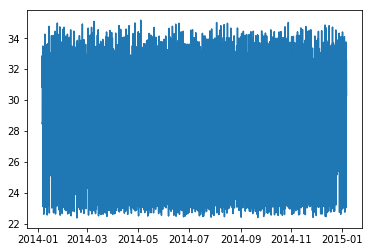

In [264]:
plt.plot(dataToPlot.iloc[:,-2])

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


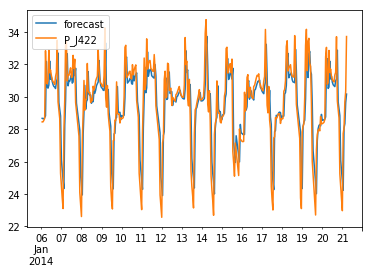

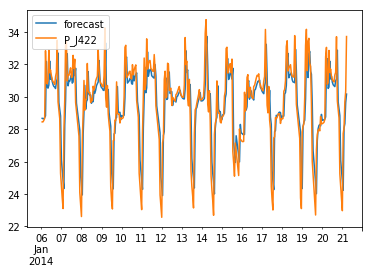

In [233]:
model_fit.plot_predict(start=1, end=365)

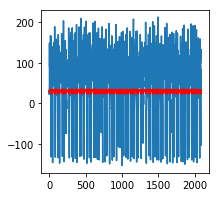

In [153]:
plt.figure(figsize=(3,3))

plt.plot(predictions)
plt.plot(errors,color='red')
plt.show()

In [134]:
#residuals = pd.DataFrame(residuals)
#residuals.hist()
#series = dataToPlot.iloc[:,2]
#X = series.values
#stationary = difference(X, months_in_year)
#stationary.index = series.index[months_in_year:]
#stationary.plot()
#plt.show()

ADF Statistic: -23.739310
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


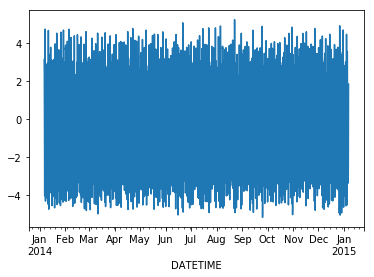

In [135]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
series = dataToPlot.iloc[:,1]
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

# plot
stationary.plot()
plt.show()

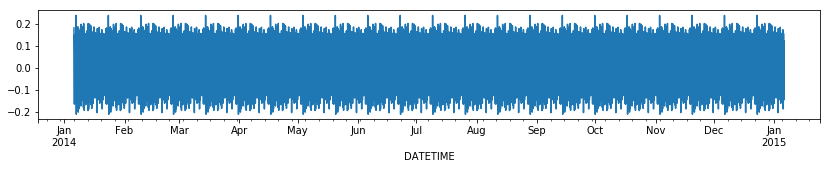

In [136]:
decomposition = sm.tsa.seasonal_decompose(dataToPlot.iloc[:,2],freq=400)
decompSeasonal = decomposition.seasonal
ax = decompSeasonal.plot(figsize=(14,2))

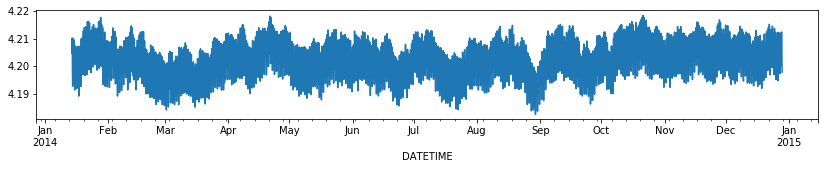

In [137]:
decompTrend = decomposition.trend
ax = decompTrend.plot(figsize=(14,2))

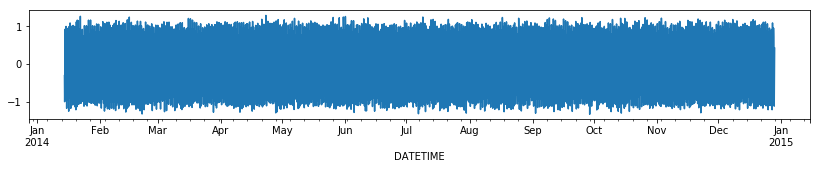

In [138]:
decompResid = decomposition.resid
ax = decompResid.plot(figsize=(14,2))

# PCA

In [237]:
from sklearn import preprocessing

x = dataToPlot.values #returns a numpy array

In [238]:

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalizedDataToPlot = pd.DataFrame(x_scaled)

In [239]:
## TODO use StandardScaler or not ? :S
#scaler = StandardScaler()
# Fit on training set only.
#scaler.fit(trainingTable)
# Apply transform to both the training set and the test set.
#train= scaler.transform(trainingTable)
#test = scaler.transform(dataToPlot2)
pca = PCA()
pca.fit(normalizedDataToPlot)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0.5,0,'PCA features')

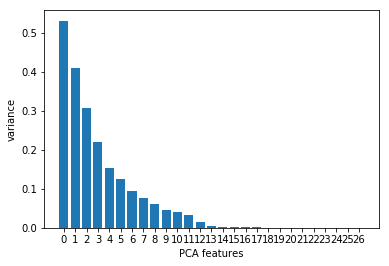

In [240]:
features = range(pca.n_components_)
plt.bar(features,pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA features')

In [241]:
var= pca.explained_variance_ratio_
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

[2.50415570e-01 1.93254937e-01 1.45121848e-01 1.03490334e-01
 7.23370239e-02 5.91946217e-02 4.39198683e-02 3.59511979e-02
 2.88181495e-02 2.13520946e-02 1.92880613e-02 1.53178126e-02
 6.65029960e-03 1.98328684e-03 8.60844247e-04 7.43517313e-04
 4.22385573e-04 3.84932364e-04 3.18841034e-04 1.05189819e-04
 5.53089079e-05 1.23540891e-05 1.46150837e-06 4.82277430e-08
 6.10879205e-09 5.60513676e-09 1.09106572e-33]


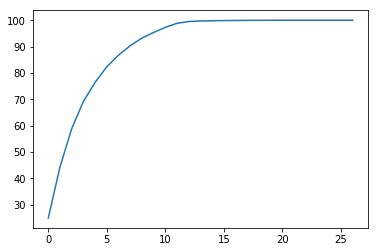

In [242]:
plt.plot(var1)
print(pca.explained_variance_ratio_) 

Text(0,0.5,'explained_variance_')

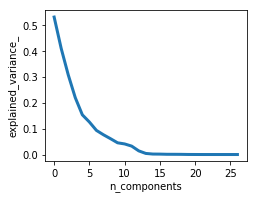

In [243]:
plt.figure(1, figsize=(4, 3))
plt.axes([.1, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=3)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

0         1         2         3         4         5         6   \
0     0.041663  0.326844  0.120893  0.294027  0.474946  0.728796  0.128789   
1     0.020317  0.319408  0.297909  0.308547  0.638842  0.992383  0.202221   
2     0.000000  0.315129  0.493043  0.466649  0.795042  1.000000  0.302105   
3     0.002805  0.319432  0.702160  0.648073  0.926695  1.000000  0.544778   
4     0.035899  0.334301  0.923501  0.895404  0.770673  1.000000  0.858088   
5     0.103489  0.461701  0.891294  0.719772  0.661543  0.737551  0.743827   
6     0.190384  0.603769  0.823907  0.377856  0.545864  0.358491  0.487468   
7     0.241768  0.666499  0.731170  0.587588  0.371740  0.485702  0.481456   
8     0.266899  0.715942  0.601953  0.727956  0.158590  0.845772  0.551120   
9     0.276064  0.783282  0.489108  0.829400  0.130161  1.000000  0.652524   
10    0.272111  0.869311  0.306789  0.357239  0.283735  1.000000  0.606174   
11    0.254996  0.894878  0.150828  0.365213  0.424513  1.000000  0.538826   
12    0.251518  0.907280  0.051746  0.497494  0.592531  1.000000  0.596684   
13    0.255722  0.875544  0.237051  0.586538  0.708539  1.000000  0.692265   
14    0.233691  0.839279  0.444382  0.693899  0.843479  1.000000  0.600581   
15    0.226635  0.806177  0.621516  0.694923  0.885703  1.000000  0.570950   
16    0.249276  0.783012  0.817849  0.759083  0.648490  1.000000  0.686202   
17    0.266204  0.775680  0.919475  0.836558  0.419931  1.000000  0.829015   
18    0.294973  0.819160  0.783675  0.898659  0.140297  0.936728  0.898725   
19    0.333733  0.913761  0.625877  0.548479  0.111768  0.371758  0.451111   
20    0.348097  0.939988  0.528975  0.420857  0.257803  0.490999  0.399537   
21    0.394052  0.839994  0.348458  0.369446  0.390798  0.706867  0.390544   
22    0.432005  0.740521  0.168596  0.344082  0.481601  0.925590  0.391191   
23    0.460703  0.625180  0.084250  0.376561  0.580013  0.963365  0.300387   
24    0.502505  0.462627  0.263588  0.349795  0.707984  1.000000  0.319885   
25    0.562008  0.301207  0.423530  0.411338  0.850879  1.000000  0.425490   
26    0.640637  0.142790  0.598313  0.450439  0.836295  1.000000  0.705568   
27    0.707012  0.056733  0.787738  0.599875  0.646854  1.000000  0.939310   
28    0.745120  0.132181  0.923722  0.875182  0.472325  0.651182  0.683746   
29    0.802051  0.288182  0.850653  0.748363  0.362821  0.237117  0.404398   
...        ...       ...       ...       ...       ...       ...       ...   
8731  0.038799  0.644216  0.581358  0.567513  0.927734  1.000000  0.358795   
8732  0.040381  0.673371  0.404335  0.526864  0.724780  1.000000  0.370360   
8733  0.055984  0.704009  0.216077  0.465129  0.391976  1.000000  0.315441   
8734  0.074042  0.735626  0.048002  0.584008  0.114248  1.000000  0.323331   
8735  0.065869  0.701484  0.227037  0.661848  0.103036  1.000000  0.425906   
8736  0.052570  0.670044  0.418652  0.770827  0.270412  1.000000  0.493813   
8737  0.048332  0.644596  0.620790  0.844207  0.414901  1.000000  0.583452   
8738  0.033865  0.639453  0.836787  0.804629  0.593976  1.000000  0.668579   
8739  0.050002  0.722841  0.890294  0.409523  0.785869  1.000000  0.860687   
8740  0.089362  0.774994  0.799111  0.608744  0.920841  0.811384  0.835336   
8741  0.167412  0.835103  0.700687  0.908612  0.785588  0.485069  0.609026   
8742  0.244230  0.952516  0.622004  0.620486  0.599429  0.227722  0.382772   
8743  0.323888  0.924284  0.553269  0.413345  0.419370  0.811225  0.635527   
8744  0.413379  0.826742  0.397003  0.576039  0.154956  1.000000  0.797968   
8745  0.469783  0.729602  0.247953  0.715418  0.174460  1.000000  0.855430   
8746  0.519947  0.631230  0.065293  0.680740  0.256620  1.000000  0.791967   
8747  0.564538  0.479807  0.207751  0.654540  0.396176  1.000000  0.860552   
8748  0.614700  0.318931  0.379380  0.640552  0.564572  1.000000  0.899830   
8749  0.690728  0.160522  0.545789  0.724885  0.712649  0.650250  0.671326   
8750  0.758053  0.050850  0.708134

In [247]:
#Looking at above plot I'm taking 3 variables
pca = PCA(n_components=8)
m=pca.fit(normalizedDataToPlot)
X1=pca.fit_transform(normalizedDataToPlot)

print(X1)

[[ 0.30269654 -0.94596103  0.17088517 ... -0.05604115  0.36867722
   0.28717226]
 [ 0.30106003 -0.95538179  0.24356859 ... -0.02892262  0.15853183
   0.14119566]
 [ 0.25465939 -0.92066616  0.29368718 ... -0.04358506  0.02245166
   0.13041453]
 ...
 [ 0.13844597 -0.84629892  0.03497806 ... -0.0457371   0.60868
   0.4453854 ]
 [ 0.13999242 -0.85486789  0.08811194 ... -0.03527171  0.49380453
   0.40410529]
 [ 0.13033642 -0.86339796  0.16594939 ... -0.03023392  0.33018222
   0.31886349]]


In [248]:
print(pca.explained_variance_ratio_)

[0.25041557 0.19325494 0.14512185 0.10349033 0.07233702 0.05919462
 0.04391987 0.0359512 ]


In [225]:
def hotelling_tsquared(pc):
    """`pc` should be the object returned by matplotlib.mlab.PCA()."""
    x = pc.a.T
    cov = pc.Wt.T.dot(np.diag(pc.s)).dot(pc.Wt) / (x.shape[1] - 1)
    w = np.linalg.solve(cov, x)
    t2 = (x * w).sum(axis=0)
    return t2

coeff:
[[ 8.44461347e-02 -2.12661736e-01 -1.52630675e-01 -1.10348593e-01
   4.27360185e-02  1.23902100e-01 -8.53462945e-02  2.22152799e-01
  -2.24521838e-01  2.16536485e-01  2.03591652e-01  1.85808086e-01
   1.85905573e-01  1.23628325e-02 -1.09777650e-01  1.98620456e-01
  -2.22351191e-01 -3.36388878e-01  1.56945273e-01 -3.35995256e-01
   1.61196342e-01 -2.25209236e-01  1.71019604e-01 -2.25885799e-01
   1.14435254e-01 -2.04695209e-03 -3.29630538e-01 -4.00863351e-03]
 [-2.61387108e-01  1.74081292e-01 -1.30856228e-01 -1.75544580e-02
  -2.86893747e-02  7.79739667e-02 -7.05092071e-02 -2.63308634e-02
   1.50549119e-01 -7.98714393e-03  3.92667949e-02  3.17045313e-01
   1.69420256e-01  2.97850190e-02  1.91054471e-01 -2.07690054e-01
   2.82071871e-02  2.09340204e-01 -3.03395278e-02  2.10657555e-01
   2.36968596e-02 -4.08069514e-01  3.05725871e-01 -4.07602441e-01
   1.12975686e-01 -2.40818345e-01  2.23496032e-01  6.59260183e-03]
 [ 2.47389579e-02  1.22721968e-01 -1.01829982e-01 -9.35362004e-02
 

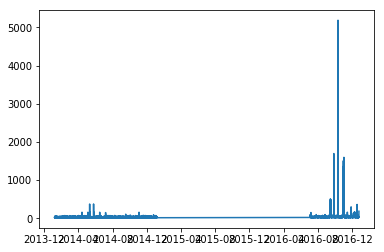

In [226]:
pcamat = PCAmat(trainingTable)
coeff = pcamat.Wt
print("coeff:")
print(coeff)
    
latent = pcamat.s / (trainingTable.shape[0] - 1)
print("latent:" + (" %9.4f"*len(latent)) % tuple(latent))
print()


tsquared = hotelling_tsquared(pcamat)
print("tsquared:")
print(tsquared)

plt.plot(tsquared)
plt.show()

# TODO : TO CHECK IF IT'S NEED

In [ ]:
test = trainingTable1[['L_T1']]
test.rolling(30).mean().plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);

In [ ]:
test.diff().plot(figsize=(20,20), linewidth=2, fontsize=20)

In [ ]:
indexMonth = trainingTable1.index.month
dataByMonth = trainingTable1.groupby(indexMonth).mean()

In [ ]:
ax =  dataByMonth.plot(figsize=(12,10),colormap='Dark2')
ax.legend(bbox_to_anchor=(1.0,0.5),loc='center left')

In [ ]:
trainingTable